# Policy gradients


In this notebook, we'll build a neural network that can learn to play games through reinforcement learning. More specifically, we'll use Q-learning to train an agent to play a game called [Cart-Pole](https://gym.openai.com/envs/CartPole-v0). In this game, a freely swinging pole is attached to a cart. The cart can move to the left and right, and the goal is to keep the pole upright as long as possible.

![Cart-Pole](assets/cart-pole.jpg)

We can simulate this game using [OpenAI Gym](https://gym.openai.com/). First, let's check out how OpenAI Gym works. Then, we'll get into training an agent to play the Cart-Pole game.

In [1]:
# In this one we should define and detect GPUs for tensorflow
# GPUs or CPU
import tensorflow as tf

# Check TensorFlow Version
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.7.1
Default GPU Device: 


>**Note:** Make sure you have OpenAI Gym cloned into the same directory with this notebook. I've included `gym` as a submodule, so you can run `git submodule --init --recursive` to pull the contents into the `gym` repo.

##### >**Note:** Make sure you have OpenAI Gym cloned. Then run this command `pip install -e gym/[all]`.

In [2]:
import gym

## Create the Cart-Pole game environment
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('MountainCarContinuous-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.


/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


We interact with the simulation through `env`. To show the simulation running, you can use `env.render()` to render one frame. Passing in an action as an integer to `env.step` will generate the next step in the simulation.  You can see how many actions are possible from `env.action_space` and to get a random action you can use `env.action_space.sample()`. This is general to all Gym games. In the Cart-Pole game, there are two possible actions, moving the cart left or right. So there are two actions we can take, encoded as 0 and 1.

Run the code below to watch the simulation run.

In [3]:
env.reset()
batch = []
for _ in range(1111):
    #env.render()
    action = env.action_space.sample()
    state, reward, done, info = env.step(action) # take a random action
    batch.append([action, state, reward, done, info])
    #print('state, action, reward, done, info:', state, action, reward, done, info)
    if done:
        env.reset()

To shut the window showing the simulation, use `env.close()`.

In [4]:
# env.close()

If you ran the simulation above, we can look at the rewards:

In [5]:
batch[0], 
batch[0][1].shape, state.shape

((4,), (4,))

In [6]:
import numpy as np
actions = np.array([each[0] for each in batch])
states = np.array([each[1] for each in batch])
rewards = np.array([each[2] for each in batch])
dones = np.array([each[3] for each in batch])
infos = np.array([each[4] for each in batch])

In [7]:
# print(rewards[-20:])
print('shapes:', np.array(rewards).shape, np.array(states).shape, np.array(actions).shape, np.array(dones).shape)
print('dtypes:', np.array(rewards).dtype, np.array(states).dtype, np.array(actions).dtype, np.array(dones).dtype)
print('states:', np.max(np.array(states)), np.min(np.array(states)))
print('actions:', np.max(np.array(actions)), np.min(np.array(actions)))
# print((np.max(np.array(actions)) - np.min(np.array(actions)))+1)
print('rewards:', np.max(np.array(rewards)), np.min(np.array(rewards)))

shapes: (1111,) (1111, 4) (1111,) (1111,)
dtypes: float64 float64 int64 bool
states: 2.448188133303783 -2.624887772077649
actions: 1 0
rewards: 1.0 1.0


In [8]:
actions[:10]

array([0, 1, 1, 0, 1, 1, 1, 1, 1, 1])

In [9]:
rewards[:10]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

In [10]:
# import numpy as np
def sigmoid(x, derivative=False):
  return x*(1-x) if derivative else 1/(1+np.exp(-x))

In [11]:
sigmoid(np.max(np.array(rewards))), sigmoid(np.min(np.array(rewards)))

(0.7310585786300049, 0.7310585786300049)

In [12]:
print('rewards:', np.max(np.array(rewards))/100, np.min(np.array(rewards))/100)

rewards: 0.01 0.01


The game resets after the pole has fallen past a certain angle. For each frame while the simulation is running, it returns a reward of 1.0. The longer the game runs, the more reward we get. Then, our network's goal is to maximize the reward by keeping the pole vertical. It will do this by moving the cart to the left and the right.

## Q-Network

We train our Q-learning agent using the Bellman Equation:

$$
Q(s, a) = r + \gamma \max{Q(s', a')}
$$

where $s$ is a state, $a$ is an action, and $s'$ is the next state from state $s$ and action $a$.

Before we used this equation to learn values for a Q-_table_. However, for this game there are a huge number of states available. The state has four values: the position and velocity of the cart, and the position and velocity of the pole. These are all real-valued numbers, so ignoring floating point precisions, you practically have infinite states. Instead of using a table then, we'll replace it with a neural network that will approximate the Q-table lookup function.

<img src="assets/deep-q-learning.png" width=450px>

Now, our Q value, $Q(s, a)$ is calculated by passing in a state to the network. The output will be Q-values for each available action, with fully connected hidden layers.

<img src="assets/q-network.png" width=550px>


As I showed before, we can define our targets for training as $\hat{Q}(s,a) = r + \gamma \max{Q(s', a')}$. Then we update the weights by minimizing $(\hat{Q}(s,a) - Q(s,a))^2$. 

For this Cart-Pole game, we have four inputs, one for each value in the state, and two outputs, one for each action. To get $\hat{Q}$, we'll first choose an action, then simulate the game using that action. This will get us the next state, $s'$, and the reward. With that, we can calculate $\hat{Q}$ then pass it back into the $Q$ network to run the optimizer and update the weights.

Below is my implementation of the Q-network. I used two fully connected layers with ReLU activations. Two seems to be good enough, three might be better. Feel free to try it out.

In [32]:
# Data of the model
def model_input(state_size):
    states = tf.placeholder(tf.float32, [None, state_size], name='states')
    actions = tf.placeholder(tf.int32, [None], name='actions')
    targetQs = tf.placeholder(tf.float32, [None], name='targetQs')
    reward = tf.placeholder(tf.float32, [], name='reward')
    training = tf.placeholder(tf.bool, [], name='training')
    return states, actions, targetQs, reward, training

In [33]:
# Generator/Controller: Generating/prediting the actions
def generator(states, action_size, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('generator', reuse=reuse):
        # First fully connected layer
        h1 = tf.layers.dense(inputs=states, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=action_size)        
        #predictions = tf.nn.softmax(logits)

        # return actions logits
        return logits

In [34]:
# Discriminator/Dopamine: Reward function/planner/naviator/advisor/supervisor/cortical columns
def discriminator(states, actions, hidden_size, reuse=False, alpha=0.1, training=False):
    with tf.variable_scope('discriminator', reuse=reuse):
        # Fusion/merge states and actions/ SA/ SM
        x_fused = tf.concat(axis=1, values=[states, actions])
        
        # First fully connected layer
        h1 = tf.layers.dense(inputs=x_fused, units=hidden_size)
        bn1 = tf.layers.batch_normalization(h1, training=training)        
        nl1 = tf.maximum(alpha * bn1, bn1)
        
        # Second fully connected layer
        h2 = tf.layers.dense(inputs=nl1, units=hidden_size)
        bn2 = tf.layers.batch_normalization(h2, training=training)        
        nl2 = tf.maximum(alpha * bn2, bn2)
        
        # Output layer
        logits = tf.layers.dense(inputs=nl2, units=1)        
        #predictions = tf.nn.softmax(logits)

        # return rewards logits
        return logits

In [35]:
def model_loss(action_size, hidden_size, states, actions, targetQs, reward, training): # model input
    actions_logits = generator(states=states, hidden_size=hidden_size, action_size=action_size)
    actions_labels = tf.one_hot(indices=actions, depth=action_size, dtype=actions_logits.dtype)
    neg_log_prob_actions = tf.nn.softmax_cross_entropy_with_logits_v2(logits=actions_logits, 
                                                                      labels=actions_labels)
    #Qs_label = tf.reshape(0.01*targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    Qs_label = tf.reshape(tf.nn.sigmoid(targetQs[:-1]) + (0.99*targetQs[1:]), shape=[-1, 1])
    g_loss_p = tf.reduce_mean(neg_log_prob_actions * Qs_label) * reward 
    # reward/rate = episode_total_reward/goal_total_reward --> success/fail rate of episode
    
    Qs_logits = discriminator(actions=actions_logits, hidden_size=hidden_size, states=states) # Q=sum(rewards)
    Qs_logits += discriminator(actions=tf.nn.softmax(actions_logits), hidden_size=hidden_size, states=states, 
                               reuse=True) # Q=sum(rewards)
    Qs_logits += discriminator(actions=actions_labels, hidden_size=hidden_size, states=states, reuse=True)
    Qs_logits /= 3
    d_loss = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits, 
                                                                    labels=reward*tf.ones_like(Qs_logits)))
    g_loss_q = tf.reduce_mean(tf.square(Qs_logits[:-1]-Qs_label))
    # g_loss_q = tf.reduce_mean(tf.nn.sigmoid_cross_entropy_with_logits(logits=Qs_logits[:-1],
    #                                                                   labels=tf.nn.sigmoid(Qs_label)))
    g_loss = g_loss_p + g_loss_q
    return actions_logits, Qs_logits, g_loss, d_loss, g_loss_p, g_loss_q

In [36]:
# Optimizating/training/learning G & D
def model_opt(g_loss, d_loss, learning_rate):
    """
    Get optimization operations in order
    :param g_loss: Generator loss Tensor for action prediction
    :param d_loss: Discriminator loss Tensor for reward prediction for generated/prob/logits action
    :param learning_rate: Learning Rate Placeholder
    :return: A tuple of (qfunction training, generator training, discriminator training)
    """
    # Get weights and bias to update
    t_vars = tf.trainable_variables()
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]

    # Optimize
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)): # Required for batchnorm (BN)
        g_opt = tf.train.AdamOptimizer(learning_rate).minimize(g_loss, var_list=g_vars)
        d_opt = tf.train.AdamOptimizer(learning_rate).minimize(d_loss, var_list=d_vars)

    return g_opt, d_opt

In [37]:
class Model:
    def __init__(self, state_size, action_size, hidden_size, learning_rate):

        # Data of the Model: make the data available inside the framework
        self.states, self.actions, self.targetQs, self.reward, self.training = model_input(state_size=state_size)

        # Create the Model: calculating the loss and forwad pass
        self.actions_logits, self.Qs_logits, self.g_loss, self.d_loss, self.g_loss_p, self.g_loss_q = model_loss(
            action_size=action_size, hidden_size=hidden_size, # model init parameters
            states=self.states, actions=self.actions, reward=self.reward, targetQs=self.targetQs, 
            training=self.training) # model input
        
        # Update the model: backward pass and backprop
        self.g_opt, self.d_opt = model_opt(g_loss=self.g_loss, d_loss=self.d_loss, learning_rate=learning_rate)

## Hyperparameters

One of the more difficult aspects of reinforcememt learning are the large number of hyperparameters. Not only are we tuning the network, but we're tuning the simulation.

In [38]:
print('state size:{}'.format(states.shape), 
      'actions:{}'.format(actions.shape)) 
print('action size:{}'.format(np.max(actions) - np.min(actions)+1))

state size:(10, 4) actions:(10,)
action size:1


In [39]:
# Training parameters
# Network parameters
state_size = 4               # number of units for the input state/observation -- simulation
action_size = 2              # number of units for the output actions -- simulation
hidden_size = 64             # number of units in each Q-network hidden layer -- simulation
learning_rate = 0.001          # learning rate for adam

In [40]:
# Reset/init the graph/session
graph = tf.reset_default_graph()

# Init the model
model = Model(action_size=action_size, hidden_size=hidden_size, state_size=state_size, learning_rate=learning_rate)

## Training the model

Below we'll train our agent. If you want to watch it train, uncomment the `env.render()` line. This is slow because it's rendering the frames slower than the network can train. But, it's cool to watch the agent get better at the game.

In [41]:
# import gym

# ## Create the Cart-Pole game environment
# env = gym.make('CartPole-v0')
# env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# # env = gym.make('MountainCar-v0')
# # env = gym.make('Pendulum-v0')
# # env = gym.make('Blackjack-v0')
# # env = gym.make('FrozenLake-v0')
# # env = gym.make('AirRaid-ram-v0')
# # env = gym.make('AirRaid-v0')
# # env = gym.make('BipedalWalker-v2')
# # env = gym.make('Copy-v0')
# # env = gym.make('CarRacing-v0')
# # env = gym.make('Ant-v2') #mujoco
# # env = gym.make('FetchPickAndPlace-v1') # mujoco required!

In [55]:
from collections import deque
episodes_total_reward = deque(maxlen=100) # 100 episodes average/running average/running mean/window

# Now train with experiences
saver = tf.train.Saver()
rewards_list, g_loss_list, d_loss_list = [], [], []

# TF session for training
with tf.Session(graph=graph) as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    #saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Training episodes/epochs
    for ep in range(11111):
        batch = [] # every data batch
        total_reward = 0
        state = env.reset() # env first state

        # Training steps/batches
        while True:
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            next_state, reward, done, _ = env.step(action)
            total_reward += reward
            Q_logits = sess.run(model.Qs_logits, feed_dict={model.states: np.reshape(state, [1, -1]), 
                                                            model.actions: np.array([action])})
            targetQ = Q_logits * (1-float(done))
            batch.append([state, action, targetQ])
            state = next_state
            if done is True: # episode ended success/failure
                episodes_total_reward.append(total_reward) # success criteria
                success_rate = total_reward/500 # success rate
                break

        # Training using batches
        #batch = memory.buffer
        states = np.array([each[0] for each in batch])
        actions = np.array([each[1] for each in batch])
        targetQs = np.array([each[2] for each in batch])
        g_loss, d_loss, g_loss_p, g_loss_q, _, _ = sess.run([model.g_loss, model.d_loss, 
                                                             model.g_loss_p, model.g_loss_q, 
                                                             model.g_opt, model.d_opt],
                                                            feed_dict = {model.states: states, 
                                                                         model.actions: actions,
                                                                         model.reward: success_rate,
                                                                         model.targetQs: targetQs.reshape([-1])})
        # Average 100 episode total reward
        # Print out
        print('Episode:{}'.format(ep),
              'meanR:{:.4f}'.format(np.mean(episodes_total_reward)),
              'stdR:{:.4f}'.format(np.std(episodes_total_reward)),
              'glossP:{:.4f}'.format(g_loss_p),
              'glossQ:{:.4f}'.format(g_loss_q),
              'gloss:{:.4f}'.format(g_loss),
              'dloss:{:.4f}'.format(d_loss))
        # Ploting out
        rewards_list.append([ep, np.mean(episodes_total_reward)])
        g_loss_list.append([ep, g_loss])
        d_loss_list.append([ep, d_loss])
        # Break episode/epoch loop
        if np.mean(episodes_total_reward) > 500:
            break
            
    # At the end of all training episodes/epochs
    saver.save(sess, 'checkpoints/model.ckpt')

Episode: 0 meanR: 10.0000 glossP: 0.0052 glossQ: 0.2364 gloss: 0.2416 dloss: 0.6542
Episode: 1 meanR: 9.5000 glossP: 0.0077 glossQ: 0.3020 gloss: 0.3097 dloss: 0.7957
Episode: 2 meanR: 9.3333 glossP: 0.0066 glossQ: 0.2847 gloss: 0.2913 dloss: 0.7601
Episode: 3 meanR: 9.5000 glossP: 0.0062 glossQ: 0.2691 gloss: 0.2753 dloss: 0.7274
Episode: 4 meanR: 9.4000 glossP: 0.0045 glossQ: 0.2547 gloss: 0.2592 dloss: 0.6906
Episode: 5 meanR: 9.1667 glossP: 0.0034 glossQ: 0.2437 gloss: 0.2471 dloss: 0.6585
Episode: 6 meanR: 9.1429 glossP: 0.0029 glossQ: 0.2332 gloss: 0.2361 dloss: 0.6264
Episode: 7 meanR: 9.1250 glossP: 0.0022 glossQ: 0.2258 gloss: 0.2280 dloss: 0.5956
Episode: 8 meanR: 9.3333 glossP: 0.0013 glossQ: 0.2133 gloss: 0.2146 dloss: 0.5564
Episode: 9 meanR: 9.3000 glossP: 0.0008 glossQ: 0.2208 gloss: 0.2217 dloss: 0.5373
Episode: 10 meanR: 9.3636 glossP: -0.0001 glossQ: 0.2172 gloss: 0.2171 dloss: 0.5019
Episode: 11 meanR: 9.3333 glossP: -0.0006 glossQ: 0.2293 gloss: 0.2287 dloss: 0.4785

Episode: 97 meanR: 29.2041 glossP: -0.4095 glossQ: 0.0831 gloss: -0.3264 dloss: 0.6940
Episode: 98 meanR: 29.6970 glossP: -0.2751 glossQ: 0.1193 gloss: -0.1558 dloss: 0.4874
Episode: 99 meanR: 30.3500 glossP: -0.3239 glossQ: 0.0988 gloss: -0.2251 dloss: 0.5697
Episode: 100 meanR: 31.0500 glossP: -0.2684 glossQ: 0.1158 gloss: -0.1526 dloss: 0.4887
Episode: 101 meanR: 31.7100 glossP: -0.2456 glossQ: 0.1110 gloss: -0.1346 dloss: 0.4577
Episode: 102 meanR: 32.3800 glossP: -0.2418 glossQ: 0.1016 gloss: -0.1401 dloss: 0.4564
Episode: 103 meanR: 34.1700 glossP: -0.5675 glossQ: 0.0489 gloss: -0.5187 dloss: 0.9752
Episode: 104 meanR: 35.4300 glossP: -0.3996 glossQ: 0.0748 gloss: -0.3248 dloss: 0.7226
Episode: 105 meanR: 35.7300 glossP: -0.1135 glossQ: 0.3356 gloss: 0.2221 dloss: 0.2793
Episode: 106 meanR: 35.9800 glossP: -0.1013 glossQ: 0.5109 gloss: 0.4096 dloss: 0.2624
Episode: 107 meanR: 36.1100 glossP: -0.0530 glossQ: 0.2292 gloss: 0.1762 dloss: 0.2136
Episode: 108 meanR: 36.2000 glossP: -0

Episode: 191 meanR: 48.1100 glossP: -0.0719 glossQ: 0.2613 gloss: 0.1893 dloss: 0.2108
Episode: 192 meanR: 45.5400 glossP: -0.1179 glossQ: 0.1675 gloss: 0.0496 dloss: 0.2795
Episode: 193 meanR: 46.4400 glossP: -0.2901 glossQ: 0.0669 gloss: -0.2231 dloss: 0.5552
Episode: 194 meanR: 46.6000 glossP: -0.1208 glossQ: 0.1897 gloss: 0.0688 dloss: 0.2793
Episode: 195 meanR: 47.1600 glossP: -0.2648 glossQ: 0.0900 gloss: -0.1748 dloss: 0.4949
Episode: 196 meanR: 47.4000 glossP: -0.1604 glossQ: 0.1496 gloss: -0.0108 dloss: 0.3367
Episode: 197 meanR: 46.6700 glossP: -0.1390 glossQ: 0.2024 gloss: 0.0634 dloss: 0.2992
Episode: 198 meanR: 47.2200 glossP: -0.3879 glossQ: 0.0557 gloss: -0.3321 dloss: 0.7004
Episode: 199 meanR: 46.3800 glossP: -0.0331 glossQ: 0.7063 gloss: 0.6732 dloss: 0.1336
Episode: 200 meanR: 46.5100 glossP: -0.2572 glossQ: 0.0713 gloss: -0.1859 dloss: 0.5118
Episode: 201 meanR: 46.5100 glossP: -0.2111 glossQ: 0.0810 gloss: -0.1302 dloss: 0.4363
Episode: 202 meanR: 46.4700 glossP: -

Episode: 285 meanR: 46.7600 glossP: -0.0682 glossQ: 0.2842 gloss: 0.2160 dloss: 0.1988
Episode: 286 meanR: 45.8800 glossP: -0.0811 glossQ: 0.2543 gloss: 0.1732 dloss: 0.2173
Episode: 287 meanR: 45.4300 glossP: -0.0859 glossQ: 0.2571 gloss: 0.1712 dloss: 0.2210
Episode: 288 meanR: 45.4600 glossP: -0.0778 glossQ: 0.2902 gloss: 0.2124 dloss: 0.2053
Episode: 289 meanR: 45.3600 glossP: -0.0728 glossQ: 0.3241 gloss: 0.2513 dloss: 0.1940
Episode: 290 meanR: 45.2900 glossP: -0.0829 glossQ: 0.3486 gloss: 0.2658 dloss: 0.2094
Episode: 291 meanR: 45.6500 glossP: -0.2079 glossQ: 0.1630 gloss: -0.0450 dloss: 0.3906
Episode: 292 meanR: 45.6700 glossP: -0.1431 glossQ: 0.2222 gloss: 0.0791 dloss: 0.2915
Episode: 293 meanR: 44.7700 glossP: -0.0411 glossQ: 0.7804 gloss: 0.7394 dloss: 0.1275
Episode: 294 meanR: 45.1200 glossP: -0.2518 glossQ: 0.1199 gloss: -0.1319 dloss: 0.4592
Episode: 295 meanR: 45.0600 glossP: -0.2612 glossQ: 0.0984 gloss: -0.1627 dloss: 0.4760
Episode: 296 meanR: 46.1600 glossP: -0.5

Episode: 380 meanR: 42.5200 glossP: -0.3523 glossQ: 0.0900 gloss: -0.2623 dloss: 0.6023
Episode: 381 meanR: 43.1600 glossP: -0.2542 glossQ: 0.0573 gloss: -0.1969 dloss: 0.4979
Episode: 382 meanR: 43.6300 glossP: -0.2499 glossQ: 0.1245 gloss: -0.1254 dloss: 0.4480
Episode: 383 meanR: 44.1500 glossP: -0.2458 glossQ: 0.0554 gloss: -0.1904 dloss: 0.4983
Episode: 384 meanR: 44.9800 glossP: -0.2957 glossQ: 0.0535 gloss: -0.2422 dloss: 0.5708
Episode: 385 meanR: 45.5900 glossP: -0.2347 glossQ: 0.0726 gloss: -0.1620 dloss: 0.4749
Episode: 386 meanR: 45.4500 glossP: -0.0412 glossQ: 0.6082 gloss: 0.5670 dloss: 0.1400
Episode: 387 meanR: 45.2700 glossP: -0.0304 glossQ: 0.8325 gloss: 0.8020 dloss: 0.1263
Episode: 388 meanR: 45.1500 glossP: -0.0398 glossQ: 0.5702 gloss: 0.5305 dloss: 0.1442
Episode: 389 meanR: 45.1000 glossP: -0.0500 glossQ: 0.2872 gloss: 0.2372 dloss: 0.1817
Episode: 390 meanR: 45.1400 glossP: -0.0824 glossQ: 0.1739 gloss: 0.0914 dloss: 0.2384
Episode: 391 meanR: 45.4100 glossP: -

Episode: 474 meanR: 40.6000 glossP: -0.5026 glossQ: 0.1100 gloss: -0.3927 dloss: 0.8246
Episode: 475 meanR: 41.6700 glossP: -0.4249 glossQ: 0.0516 gloss: -0.3732 dloss: 0.7202
Episode: 476 meanR: 41.8100 glossP: -0.2064 glossQ: 0.2274 gloss: 0.0211 dloss: 0.3790
Episode: 477 meanR: 41.8600 glossP: -0.2134 glossQ: 0.2303 gloss: 0.0169 dloss: 0.3847
Episode: 478 meanR: 42.1600 glossP: -0.2328 glossQ: 0.1769 gloss: -0.0560 dloss: 0.4182
Episode: 479 meanR: 42.2000 glossP: -0.2237 glossQ: 0.0828 gloss: -0.1409 dloss: 0.4306
Episode: 480 meanR: 41.9000 glossP: -0.2108 glossQ: 0.0908 gloss: -0.1200 dloss: 0.4219
Episode: 481 meanR: 41.6000 glossP: -0.1599 glossQ: 0.0913 gloss: -0.0686 dloss: 0.3645
Episode: 482 meanR: 41.0200 glossP: -0.0390 glossQ: 0.5102 gloss: 0.4712 dloss: 0.1462
Episode: 483 meanR: 40.2600 glossP: -0.0387 glossQ: 0.5025 gloss: 0.4638 dloss: 0.1473
Episode: 484 meanR: 39.3500 glossP: -0.0410 glossQ: 0.4325 gloss: 0.3915 dloss: 0.1550
Episode: 485 meanR: 39.1500 glossP: -

Episode: 571 meanR: 56.3900 glossP: -0.1233 glossQ: 0.1181 gloss: -0.0052 dloss: 0.3038
Episode: 572 meanR: 56.5800 glossP: -0.1536 glossQ: 0.1014 gloss: -0.0523 dloss: 0.3515
Episode: 573 meanR: 57.0300 glossP: -0.2559 glossQ: 0.1007 gloss: -0.1551 dloss: 0.4889
Episode: 574 meanR: 56.5600 glossP: -0.2559 glossQ: 0.0575 gloss: -0.1985 dloss: 0.5105
Episode: 575 meanR: 55.8700 glossP: -0.1733 glossQ: 0.1297 gloss: -0.0436 dloss: 0.3593
Episode: 576 meanR: 55.8500 glossP: -0.1674 glossQ: 0.1415 gloss: -0.0260 dloss: 0.3500
Episode: 577 meanR: 55.5200 glossP: -0.0752 glossQ: 0.3212 gloss: 0.2461 dloss: 0.2000
Episode: 578 meanR: 55.1400 glossP: -0.0813 glossQ: 0.3008 gloss: 0.2195 dloss: 0.2101
Episode: 579 meanR: 54.6100 glossP: -0.0577 glossQ: 0.4860 gloss: 0.4282 dloss: 0.1671
Episode: 580 meanR: 54.0600 glossP: -0.0479 glossQ: 0.5328 gloss: 0.4849 dloss: 0.1513
Episode: 581 meanR: 53.6400 glossP: -0.0509 glossQ: 0.4703 gloss: 0.4194 dloss: 0.1568
Episode: 582 meanR: 54.1300 glossP: -

Episode: 665 meanR: 58.8300 glossP: -0.2917 glossQ: 0.0502 gloss: -0.2415 dloss: 0.6569
Episode: 666 meanR: 59.2500 glossP: -0.1401 glossQ: 0.0881 gloss: -0.0520 dloss: 0.3916
Episode: 667 meanR: 58.6600 glossP: -0.0899 glossQ: 0.1193 gloss: 0.0294 dloss: 0.3068
Episode: 668 meanR: 58.7100 glossP: -0.0736 glossQ: 0.1368 gloss: 0.0632 dloss: 0.2770
Episode: 669 meanR: 58.6400 glossP: -0.0726 glossQ: 0.1424 gloss: 0.0699 dloss: 0.2715
Episode: 670 meanR: 58.5800 glossP: -0.0511 glossQ: 0.1891 gloss: 0.1380 dloss: 0.2323
Episode: 671 meanR: 58.3800 glossP: -0.0573 glossQ: 0.1852 gloss: 0.1278 dloss: 0.2358
Episode: 672 meanR: 58.0900 glossP: -0.0620 glossQ: 0.1822 gloss: 0.1202 dloss: 0.2430
Episode: 673 meanR: 57.4800 glossP: -0.0570 glossQ: 0.1893 gloss: 0.1323 dloss: 0.2273
Episode: 674 meanR: 56.7300 glossP: -0.0430 glossQ: 0.2848 gloss: 0.2418 dloss: 0.2013
Episode: 675 meanR: 56.4100 glossP: -0.0598 glossQ: 0.1872 gloss: 0.1274 dloss: 0.2309
Episode: 676 meanR: 56.1100 glossP: -0.06

Episode: 760 meanR: 50.1000 glossP: -0.1433 glossQ: 0.0772 gloss: -0.0661 dloss: 0.3577
Episode: 761 meanR: 49.1600 glossP: -0.1395 glossQ: 0.0764 gloss: -0.0630 dloss: 0.3586
Episode: 762 meanR: 48.8600 glossP: -0.1229 glossQ: 0.2115 gloss: 0.0885 dloss: 0.2742
Episode: 763 meanR: 48.5500 glossP: -0.1025 glossQ: 0.2389 gloss: 0.1365 dloss: 0.2392
Episode: 764 meanR: 47.7600 glossP: -0.0967 glossQ: 0.2624 gloss: 0.1657 dloss: 0.2289
Episode: 765 meanR: 46.5700 glossP: -0.0897 glossQ: 0.2996 gloss: 0.2098 dloss: 0.2122
Episode: 766 meanR: 46.1600 glossP: -0.0838 glossQ: 0.3318 gloss: 0.2480 dloss: 0.2013
Episode: 767 meanR: 45.9900 glossP: -0.0845 glossQ: 0.3260 gloss: 0.2415 dloss: 0.2010
Episode: 768 meanR: 45.9300 glossP: -0.0944 glossQ: 0.3180 gloss: 0.2237 dloss: 0.2171
Episode: 769 meanR: 45.9100 glossP: -0.1060 glossQ: 0.2707 gloss: 0.1647 dloss: 0.2327
Episode: 770 meanR: 45.9800 glossP: -0.1021 glossQ: 0.2753 gloss: 0.1732 dloss: 0.2275
Episode: 771 meanR: 46.1200 glossP: -0.13

Episode: 855 meanR: 60.5400 glossP: -0.2364 glossQ: 0.0730 gloss: -0.1634 dloss: 0.5046
Episode: 856 meanR: 61.2500 glossP: -0.2387 glossQ: 0.0688 gloss: -0.1700 dloss: 0.5057
Episode: 857 meanR: 61.5900 glossP: -0.1777 glossQ: 0.1150 gloss: -0.0627 dloss: 0.3976
Episode: 858 meanR: 62.2100 glossP: -0.2566 glossQ: 0.0975 gloss: -0.1590 dloss: 0.5175
Episode: 859 meanR: 62.4100 glossP: -0.1855 glossQ: 0.0989 gloss: -0.0866 dloss: 0.4131
Episode: 860 meanR: 62.5500 glossP: -0.1862 glossQ: 0.1092 gloss: -0.0770 dloss: 0.4136
Episode: 861 meanR: 62.5000 glossP: -0.1343 glossQ: 0.1334 gloss: -0.0010 dloss: 0.3349
Episode: 862 meanR: 63.0700 glossP: -0.2297 glossQ: 0.0697 gloss: -0.1600 dloss: 0.5058
Episode: 863 meanR: 63.4200 glossP: -0.1581 glossQ: 0.0727 gloss: -0.0853 dloss: 0.3949
Episode: 864 meanR: 63.3700 glossP: -0.0607 glossQ: 0.2025 gloss: 0.1418 dloss: 0.2280
Episode: 865 meanR: 63.3000 glossP: -0.0482 glossQ: 0.2505 gloss: 0.2022 dloss: 0.2072
Episode: 866 meanR: 63.6900 glossP

Episode: 950 meanR: 54.9900 glossP: -0.2525 glossQ: 0.0751 gloss: -0.1774 dloss: 0.5157
Episode: 951 meanR: 55.2500 glossP: -0.1296 glossQ: 0.1032 gloss: -0.0264 dloss: 0.3263
Episode: 952 meanR: 55.4300 glossP: -0.1251 glossQ: 0.1082 gloss: -0.0169 dloss: 0.3179
Episode: 953 meanR: 55.4800 glossP: -0.0656 glossQ: 0.2174 gloss: 0.1518 dloss: 0.2199
Episode: 954 meanR: 55.5900 glossP: -0.1961 glossQ: 0.0903 gloss: -0.1058 dloss: 0.4260
Episode: 955 meanR: 55.2900 glossP: -0.1581 glossQ: 0.0805 gloss: -0.0776 dloss: 0.3878
Episode: 956 meanR: 54.7900 glossP: -0.1228 glossQ: 0.1770 gloss: 0.0542 dloss: 0.3048
Episode: 957 meanR: 55.0200 glossP: -0.2440 glossQ: 0.0973 gloss: -0.1467 dloss: 0.4926
Episode: 958 meanR: 54.4500 glossP: -0.1009 glossQ: 0.1743 gloss: 0.0734 dloss: 0.2702
Episode: 959 meanR: 54.2600 glossP: -0.1476 glossQ: 0.1385 gloss: -0.0090 dloss: 0.3348
Episode: 960 meanR: 53.7400 glossP: -0.0546 glossQ: 0.3010 gloss: 0.2464 dloss: 0.1838
Episode: 961 meanR: 53.3700 glossP: 

Episode: 1045 meanR: 51.3700 glossP: -0.0840 glossQ: 0.1077 gloss: 0.0237 dloss: 0.3019
Episode: 1046 meanR: 51.5800 glossP: -0.1444 glossQ: 0.0732 gloss: -0.0712 dloss: 0.4183
Episode: 1047 meanR: 51.8100 glossP: -0.1784 glossQ: 0.0675 gloss: -0.1109 dloss: 0.4671
Episode: 1048 meanR: 52.6800 glossP: -0.3333 glossQ: 0.0521 gloss: -0.2812 dloss: 0.7054
Episode: 1049 meanR: 52.2400 glossP: -0.0872 glossQ: 0.1079 gloss: 0.0206 dloss: 0.2989
Episode: 1050 meanR: 51.6500 glossP: -0.0815 glossQ: 0.1321 gloss: 0.0506 dloss: 0.2865
Episode: 1051 meanR: 51.3200 glossP: -0.0390 glossQ: 0.2943 gloss: 0.2554 dloss: 0.2029
Episode: 1052 meanR: 51.0000 glossP: -0.0374 glossQ: 0.3289 gloss: 0.2915 dloss: 0.1955
Episode: 1053 meanR: 50.8900 glossP: -0.0331 glossQ: 0.3837 gloss: 0.3507 dloss: 0.1836
Episode: 1054 meanR: 50.3000 glossP: -0.0357 glossQ: 0.3689 gloss: 0.3332 dloss: 0.1877
Episode: 1055 meanR: 49.7700 glossP: -0.0285 glossQ: 0.4633 gloss: 0.4348 dloss: 0.1734
Episode: 1056 meanR: 49.5100 

Episode: 1139 meanR: 52.2300 glossP: -0.0938 glossQ: 0.1101 gloss: 0.0162 dloss: 0.2977
Episode: 1140 meanR: 51.6400 glossP: -0.0538 glossQ: 0.2154 gloss: 0.1617 dloss: 0.2248
Episode: 1141 meanR: 51.1500 glossP: -0.0860 glossQ: 0.1281 gloss: 0.0421 dloss: 0.2808
Episode: 1142 meanR: 51.0500 glossP: -0.1005 glossQ: 0.1162 gloss: 0.0157 dloss: 0.3036
Episode: 1143 meanR: 51.8400 glossP: -0.2286 glossQ: 0.0606 gloss: -0.1680 dloss: 0.5166
Episode: 1144 meanR: 52.0800 glossP: -0.1511 glossQ: 0.1142 gloss: -0.0368 dloss: 0.3780
Episode: 1145 meanR: 52.2100 glossP: -0.1324 glossQ: 0.1288 gloss: -0.0036 dloss: 0.3419
Episode: 1146 meanR: 51.9400 glossP: -0.1198 glossQ: 0.1422 gloss: 0.0225 dloss: 0.3126
Episode: 1147 meanR: 51.3600 glossP: -0.0841 glossQ: 0.2514 gloss: 0.1674 dloss: 0.2378
Episode: 1148 meanR: 49.9200 glossP: -0.0387 glossQ: 0.5552 gloss: 0.5165 dloss: 0.1480
Episode: 1149 meanR: 50.1000 glossP: -0.1490 glossQ: 0.1305 gloss: -0.0185 dloss: 0.3632
Episode: 1150 meanR: 50.3200

Episode: 1232 meanR: 49.1700 glossP: -0.1212 glossQ: 0.1395 gloss: 0.0183 dloss: 0.2800
Episode: 1233 meanR: 49.2300 glossP: -0.0769 glossQ: 0.3240 gloss: 0.2471 dloss: 0.1986
Episode: 1234 meanR: 49.3400 glossP: -0.0807 glossQ: 0.3067 gloss: 0.2260 dloss: 0.2032
Episode: 1235 meanR: 49.5500 glossP: -0.1390 glossQ: 0.1265 gloss: -0.0125 dloss: 0.3038
Episode: 1236 meanR: 49.2400 glossP: -0.0685 glossQ: 0.3697 gloss: 0.3013 dloss: 0.1816
Episode: 1237 meanR: 48.8700 glossP: -0.1451 glossQ: 0.1207 gloss: -0.0244 dloss: 0.3136
Episode: 1238 meanR: 48.3600 glossP: -0.1359 glossQ: 0.1403 gloss: 0.0045 dloss: 0.2992
Episode: 1239 meanR: 48.4700 glossP: -0.1633 glossQ: 0.1181 gloss: -0.0452 dloss: 0.3380
Episode: 1240 meanR: 48.7400 glossP: -0.1569 glossQ: 0.1243 gloss: -0.0327 dloss: 0.3284
Episode: 1241 meanR: 48.8900 glossP: -0.1664 glossQ: 0.1245 gloss: -0.0418 dloss: 0.3392
Episode: 1242 meanR: 48.6500 glossP: -0.0649 glossQ: 0.4403 gloss: 0.3754 dloss: 0.1682
Episode: 1243 meanR: 48.110

Episode: 1326 meanR: 58.8400 glossP: -0.0494 glossQ: 0.3654 gloss: 0.3159 dloss: 0.1719
Episode: 1327 meanR: 58.8200 glossP: -0.1508 glossQ: 0.0877 gloss: -0.0631 dloss: 0.3777
Episode: 1328 meanR: 58.4500 glossP: -0.0494 glossQ: 0.2458 gloss: 0.1964 dloss: 0.2049
Episode: 1329 meanR: 58.2200 glossP: -0.0685 glossQ: 0.1901 gloss: 0.1216 dloss: 0.2399
Episode: 1330 meanR: 58.3200 glossP: -0.0749 glossQ: 0.1630 gloss: 0.0881 dloss: 0.2464
Episode: 1331 meanR: 58.9200 glossP: -0.2429 glossQ: 0.0736 gloss: -0.1693 dloss: 0.4995
Episode: 1332 meanR: 59.2300 glossP: -0.1922 glossQ: 0.0917 gloss: -0.1005 dloss: 0.4144
Episode: 1333 meanR: 59.6600 glossP: -0.1607 glossQ: 0.0807 gloss: -0.0800 dloss: 0.3989
Episode: 1334 meanR: 59.9500 glossP: -0.1422 glossQ: 0.1037 gloss: -0.0385 dloss: 0.3451
Episode: 1335 meanR: 60.1000 glossP: -0.1617 glossQ: 0.0968 gloss: -0.0649 dloss: 0.3700
Episode: 1336 meanR: 60.0800 glossP: -0.0585 glossQ: 0.3457 gloss: 0.2873 dloss: 0.1766
Episode: 1337 meanR: 60.08

Episode: 1419 meanR: 55.8600 glossP: -0.0419 glossQ: 0.5223 gloss: 0.4804 dloss: 0.1525
Episode: 1420 meanR: 56.1300 glossP: -0.2246 glossQ: 0.0971 gloss: -0.1275 dloss: 0.4520
Episode: 1421 meanR: 56.2200 glossP: -0.2227 glossQ: 0.0871 gloss: -0.1357 dloss: 0.4479
Episode: 1422 meanR: 56.2400 glossP: -0.1406 glossQ: 0.1458 gloss: 0.0052 dloss: 0.3182
Episode: 1423 meanR: 56.4700 glossP: -0.1410 glossQ: 0.1656 gloss: 0.0247 dloss: 0.3182
Episode: 1424 meanR: 57.2500 glossP: -0.2783 glossQ: 0.0941 gloss: -0.1842 dloss: 0.5346
Episode: 1425 meanR: 57.5700 glossP: -0.1474 glossQ: 0.1208 gloss: -0.0266 dloss: 0.3317
Episode: 1426 meanR: 57.7300 glossP: -0.0930 glossQ: 0.2140 gloss: 0.1210 dloss: 0.2508
Episode: 1427 meanR: 57.6000 glossP: -0.1345 glossQ: 0.1415 gloss: 0.0070 dloss: 0.3217
Episode: 1428 meanR: 57.8300 glossP: -0.1136 glossQ: 0.1465 gloss: 0.0329 dloss: 0.2972
Episode: 1429 meanR: 57.9500 glossP: -0.1010 glossQ: 0.1573 gloss: 0.0563 dloss: 0.2876
Episode: 1430 meanR: 58.1700

Episode: 1512 meanR: 69.6400 glossP: -0.1701 glossQ: 0.0784 gloss: -0.0917 dloss: 0.4137
Episode: 1513 meanR: 69.3500 glossP: -0.1937 glossQ: 0.0719 gloss: -0.1219 dloss: 0.4513
Episode: 1514 meanR: 69.6500 glossP: -0.2075 glossQ: 0.0732 gloss: -0.1343 dloss: 0.4768
Episode: 1515 meanR: 69.7200 glossP: -0.1684 glossQ: 0.0781 gloss: -0.0902 dloss: 0.4137
Episode: 1516 meanR: 69.8600 glossP: -0.1589 glossQ: 0.0829 gloss: -0.0760 dloss: 0.4027
Episode: 1517 meanR: 69.5700 glossP: -0.0357 glossQ: 0.3991 gloss: 0.3635 dloss: 0.1749
Episode: 1518 meanR: 69.1300 glossP: -0.0356 glossQ: 0.4104 gloss: 0.3748 dloss: 0.1753
Episode: 1519 meanR: 69.1100 glossP: -0.0296 glossQ: 0.4988 gloss: 0.4692 dloss: 0.1681
Episode: 1520 meanR: 68.9000 glossP: -0.1423 glossQ: 0.1181 gloss: -0.0242 dloss: 0.3571
Episode: 1521 meanR: 68.2700 glossP: -0.0364 glossQ: 0.4448 gloss: 0.4084 dloss: 0.1708
Episode: 1522 meanR: 67.9400 glossP: -0.0393 glossQ: 0.3567 gloss: 0.3174 dloss: 0.1763
Episode: 1523 meanR: 68.34

Episode: 1605 meanR: 66.1300 glossP: -0.1591 glossQ: 0.1081 gloss: -0.0510 dloss: 0.3876
Episode: 1606 meanR: 66.4400 glossP: -0.1945 glossQ: 0.0898 gloss: -0.1047 dloss: 0.4452
Episode: 1607 meanR: 67.2600 glossP: -0.2460 glossQ: 0.0762 gloss: -0.1698 dloss: 0.5238
Episode: 1608 meanR: 67.3600 glossP: -0.1591 glossQ: 0.1045 gloss: -0.0546 dloss: 0.3732
Episode: 1609 meanR: 67.3000 glossP: -0.1136 glossQ: 0.1163 gloss: 0.0027 dloss: 0.2989
Episode: 1610 meanR: 66.5900 glossP: -0.1541 glossQ: 0.0953 gloss: -0.0588 dloss: 0.3803
Episode: 1611 meanR: 65.9500 glossP: -0.0611 glossQ: 0.2660 gloss: 0.2049 dloss: 0.2099
Episode: 1612 meanR: 65.5300 glossP: -0.0795 glossQ: 0.2077 gloss: 0.1282 dloss: 0.2415
Episode: 1613 meanR: 64.9800 glossP: -0.0730 glossQ: 0.2490 gloss: 0.1761 dloss: 0.2265
Episode: 1614 meanR: 64.8600 glossP: -0.1909 glossQ: 0.0939 gloss: -0.0971 dloss: 0.4349
Episode: 1615 meanR: 64.9100 glossP: -0.1793 glossQ: 0.0788 gloss: -0.1005 dloss: 0.4325
Episode: 1616 meanR: 64.4

Episode: 1701 meanR: 65.0700 glossP: -0.0498 glossQ: 0.1237 gloss: 0.0739 dloss: 0.5094
Episode: 1702 meanR: 64.6300 glossP: -0.0219 glossQ: 0.2128 gloss: 0.1908 dloss: 0.2824
Episode: 1703 meanR: 64.2000 glossP: -0.0280 glossQ: 0.1595 gloss: 0.1315 dloss: 0.3045
Episode: 1704 meanR: 64.0200 glossP: -0.0601 glossQ: 0.0977 gloss: 0.0377 dloss: 0.3924
Episode: 1705 meanR: 64.8300 glossP: -0.1730 glossQ: 0.0774 gloss: -0.0956 dloss: 0.6109
Episode: 1706 meanR: 64.3900 glossP: -0.0561 glossQ: 0.1129 gloss: 0.0569 dloss: 0.3243
Episode: 1707 meanR: 63.6200 glossP: -0.0389 glossQ: 0.1731 gloss: 0.1342 dloss: 0.2733
Episode: 1708 meanR: 63.3000 glossP: -0.0505 glossQ: 0.1495 gloss: 0.0990 dloss: 0.2882
Episode: 1709 meanR: 63.1900 glossP: -0.0556 glossQ: 0.1365 gloss: 0.0809 dloss: 0.2978
Episode: 1710 meanR: 62.8700 glossP: -0.0549 glossQ: 0.1351 gloss: 0.0801 dloss: 0.2914
Episode: 1711 meanR: 63.2700 glossP: -0.1097 glossQ: 0.0929 gloss: -0.0168 dloss: 0.3917
Episode: 1712 meanR: 63.7000 g

Episode: 1794 meanR: 85.6900 glossP: -0.1635 glossQ: 0.1096 gloss: -0.0539 dloss: 0.3960
Episode: 1795 meanR: 85.7000 glossP: -0.0468 glossQ: 0.2913 gloss: 0.2445 dloss: 0.2029
Episode: 1796 meanR: 85.8600 glossP: -0.0895 glossQ: 0.1804 gloss: 0.0909 dloss: 0.2752
Episode: 1797 meanR: 85.9000 glossP: -0.0791 glossQ: 0.1648 gloss: 0.0857 dloss: 0.2659
Episode: 1798 meanR: 85.9300 glossP: -0.0413 glossQ: 0.3764 gloss: 0.3352 dloss: 0.1837
Episode: 1799 meanR: 85.7200 glossP: -0.0460 glossQ: 0.2674 gloss: 0.2215 dloss: 0.1956
Episode: 1800 meanR: 85.5600 glossP: -0.0893 glossQ: 0.1454 gloss: 0.0561 dloss: 0.2861
Episode: 1801 meanR: 87.5500 glossP: -0.6407 glossQ: 0.0461 gloss: -0.5946 dloss: 1.1719
Episode: 1802 meanR: 88.7900 glossP: -0.3081 glossQ: 0.0629 gloss: -0.2452 dloss: 0.6569
Episode: 1803 meanR: 90.5300 glossP: -0.4478 glossQ: 0.0467 gloss: -0.4012 dloss: 0.8637
Episode: 1804 meanR: 90.9000 glossP: -0.1925 glossQ: 0.0675 gloss: -0.1250 dloss: 0.4670
Episode: 1805 meanR: 90.120

Episode: 1889 meanR: 72.6500 glossP: -0.0345 glossQ: 0.1545 gloss: 0.1200 dloss: 0.2911
Episode: 1890 meanR: 72.6100 glossP: -0.0827 glossQ: 0.0927 gloss: 0.0100 dloss: 0.4480
Episode: 1891 meanR: 72.6800 glossP: -0.0947 glossQ: 0.0882 gloss: -0.0065 dloss: 0.4674
Episode: 1892 meanR: 71.9600 glossP: -0.1113 glossQ: 0.0856 gloss: -0.0257 dloss: 0.5045
Episode: 1893 meanR: 72.2000 glossP: -0.1064 glossQ: 0.0872 gloss: -0.0192 dloss: 0.4938
Episode: 1894 meanR: 72.7900 glossP: -0.1347 glossQ: 0.0858 gloss: -0.0488 dloss: 0.5695
Episode: 1895 meanR: 73.5000 glossP: -0.1160 glossQ: 0.0810 gloss: -0.0350 dloss: 0.4808
Episode: 1896 meanR: 73.9300 glossP: -0.1136 glossQ: 0.0809 gloss: -0.0327 dloss: 0.4474
Episode: 1897 meanR: 74.4800 glossP: -0.1331 glossQ: 0.0767 gloss: -0.0565 dloss: 0.4688
Episode: 1898 meanR: 75.0700 glossP: -0.1127 glossQ: 0.0850 gloss: -0.0277 dloss: 0.4343
Episode: 1899 meanR: 75.6700 glossP: -0.1180 glossQ: 0.0815 gloss: -0.0365 dloss: 0.4419
Episode: 1900 meanR: 76

Episode: 1983 meanR: 100.0900 glossP: -0.1239 glossQ: 0.0824 gloss: -0.0415 dloss: 0.4732
Episode: 1984 meanR: 99.7900 glossP: -0.0220 glossQ: 0.3409 gloss: 0.3189 dloss: 0.2218
Episode: 1985 meanR: 100.3400 glossP: -0.0970 glossQ: 0.0946 gloss: -0.0023 dloss: 0.4261
Episode: 1986 meanR: 100.5900 glossP: -0.0599 glossQ: 0.1166 gloss: 0.0567 dloss: 0.3483
Episode: 1987 meanR: 101.0300 glossP: -0.0842 glossQ: 0.0977 gloss: 0.0135 dloss: 0.4025
Episode: 1988 meanR: 101.6200 glossP: -0.1024 glossQ: 0.0910 gloss: -0.0115 dloss: 0.4459
Episode: 1989 meanR: 102.8200 glossP: -0.1782 glossQ: 0.0808 gloss: -0.0975 dloss: 0.6059
Episode: 1990 meanR: 102.9900 glossP: -0.1230 glossQ: 0.0830 gloss: -0.0399 dloss: 0.4759
Episode: 1991 meanR: 103.2200 glossP: -0.1404 glossQ: 0.0817 gloss: -0.0587 dloss: 0.5134
Episode: 1992 meanR: 103.1300 glossP: -0.1206 glossQ: 0.0865 gloss: -0.0340 dloss: 0.4738
Episode: 1993 meanR: 103.0900 glossP: -0.1272 glossQ: 0.0936 gloss: -0.0335 dloss: 0.4750
Episode: 1994 

Episode: 2075 meanR: 186.5500 glossP: 0.2576 glossQ: 0.3824 gloss: 0.6400 dloss: 0.8025
Episode: 2076 meanR: 186.3800 glossP: 0.1910 glossQ: 0.3586 gloss: 0.5496 dloss: 0.8007
Episode: 2077 meanR: 187.5500 glossP: 0.3503 glossQ: 0.3657 gloss: 0.7160 dloss: 0.7158
Episode: 2078 meanR: 190.0000 glossP: 0.4294 glossQ: 0.3701 gloss: 0.7995 dloss: 0.6705
Episode: 2079 meanR: 193.3200 glossP: 0.5460 glossQ: 0.3661 gloss: 0.9121 dloss: 0.5957
Episode: 2080 meanR: 192.1900 glossP: 0.2300 glossQ: 0.2415 gloss: 0.4715 dloss: 0.7110
Episode: 2081 meanR: 192.6900 glossP: 0.2700 glossQ: 0.3770 gloss: 0.6470 dloss: 0.7788
Episode: 2082 meanR: 193.4400 glossP: 0.1918 glossQ: 0.3605 gloss: 0.5523 dloss: 0.8007
Episode: 2083 meanR: 193.9900 glossP: 0.1894 glossQ: 0.3694 gloss: 0.5588 dloss: 0.8180
Episode: 2084 meanR: 195.3500 glossP: 0.1657 glossQ: 0.3308 gloss: 0.4965 dloss: 0.7696
Episode: 2085 meanR: 195.9600 glossP: 0.1352 glossQ: 0.3187 gloss: 0.4539 dloss: 0.7700
Episode: 2086 meanR: 197.3500 gl

Episode: 2168 meanR: 255.4100 glossP: 0.3467 glossQ: 0.3385 gloss: 0.6852 dloss: 0.5575
Episode: 2169 meanR: 255.4100 glossP: 0.3519 glossQ: 0.3523 gloss: 0.7041 dloss: 0.5329
Episode: 2170 meanR: 255.4100 glossP: 0.3844 glossQ: 0.3825 gloss: 0.7669 dloss: 0.4948
Episode: 2171 meanR: 255.4100 glossP: 0.4080 glossQ: 0.4205 gloss: 0.8284 dloss: 0.4382
Episode: 2172 meanR: 256.7000 glossP: 0.4885 glossQ: 0.4928 gloss: 0.9812 dloss: 0.3712
Episode: 2173 meanR: 255.5700 glossP: 0.2625 glossQ: 0.4757 gloss: 0.7382 dloss: 0.7272
Episode: 2174 meanR: 255.2000 glossP: 0.1056 glossQ: 0.3968 gloss: 0.5024 dloss: 0.8451
Episode: 2175 meanR: 254.8300 glossP: 0.0706 glossQ: 0.3616 gloss: 0.4321 dloss: 0.8168
Episode: 2176 meanR: 254.8100 glossP: 0.0705 glossQ: 0.3441 gloss: 0.4146 dloss: 0.7936
Episode: 2177 meanR: 253.6300 glossP: 0.0585 glossQ: 0.3343 gloss: 0.3928 dloss: 0.7837
Episode: 2178 meanR: 251.9400 glossP: 0.0524 glossQ: 0.3102 gloss: 0.3626 dloss: 0.7567
Episode: 2179 meanR: 249.1800 gl

Episode: 2261 meanR: 243.7800 glossP: -0.0733 glossQ: 0.1058 gloss: 0.0324 dloss: 0.5683
Episode: 2262 meanR: 240.0000 glossP: -0.0638 glossQ: 0.1092 gloss: 0.0454 dloss: 0.5623
Episode: 2263 meanR: 236.2400 glossP: -0.0633 glossQ: 0.1079 gloss: 0.0446 dloss: 0.5651
Episode: 2264 meanR: 232.4200 glossP: -0.0487 glossQ: 0.1068 gloss: 0.0581 dloss: 0.5506
Episode: 2265 meanR: 228.6600 glossP: -0.0543 glossQ: 0.1111 gloss: 0.0569 dloss: 0.5637
Episode: 2266 meanR: 225.0500 glossP: -0.0630 glossQ: 0.1127 gloss: 0.0497 dloss: 0.5955
Episode: 2267 meanR: 221.4900 glossP: -0.0557 glossQ: 0.1173 gloss: 0.0616 dloss: 0.6036
Episode: 2268 meanR: 217.9700 glossP: -0.0516 glossQ: 0.1228 gloss: 0.0712 dloss: 0.6108
Episode: 2269 meanR: 214.4600 glossP: -0.0447 glossQ: 0.1264 gloss: 0.0816 dloss: 0.6118
Episode: 2270 meanR: 210.9400 glossP: -0.0383 glossQ: 0.1300 gloss: 0.0917 dloss: 0.6102
Episode: 2271 meanR: 207.4400 glossP: -0.0285 glossQ: 0.1383 gloss: 0.1098 dloss: 0.6154
Episode: 2272 meanR: 

Episode: 2357 meanR: 188.9900 glossP: -0.0211 glossQ: 0.2036 gloss: 0.1826 dloss: 0.3275
Episode: 2358 meanR: 188.0900 glossP: -0.0221 glossQ: 0.2607 gloss: 0.2386 dloss: 0.2963
Episode: 2359 meanR: 187.2700 glossP: -0.0239 glossQ: 0.2258 gloss: 0.2019 dloss: 0.2769
Episode: 2360 meanR: 186.3400 glossP: -0.0221 glossQ: 0.3055 gloss: 0.2834 dloss: 0.2245
Episode: 2361 meanR: 185.3300 glossP: -0.0289 glossQ: 0.3804 gloss: 0.3515 dloss: 0.2299
Episode: 2362 meanR: 184.2800 glossP: -0.0258 glossQ: 0.4367 gloss: 0.4109 dloss: 0.1847
Episode: 2363 meanR: 183.2100 glossP: -0.0276 glossQ: 0.4491 gloss: 0.4215 dloss: 0.1793
Episode: 2364 meanR: 182.2000 glossP: -0.0301 glossQ: 0.4896 gloss: 0.4596 dloss: 0.1723
Episode: 2365 meanR: 181.1600 glossP: -0.0393 glossQ: 0.5756 gloss: 0.5362 dloss: 0.1821
Episode: 2366 meanR: 179.9400 glossP: -0.0374 glossQ: 0.8863 gloss: 0.8488 dloss: 0.1595
Episode: 2367 meanR: 178.6400 glossP: -0.0303 glossQ: 0.7749 gloss: 0.7446 dloss: 0.1406
Episode: 2368 meanR: 

Episode: 2450 meanR: 23.5400 glossP: -0.1282 glossQ: 0.1579 gloss: 0.0297 dloss: 0.3724
Episode: 2451 meanR: 23.7400 glossP: -0.0971 glossQ: 0.1988 gloss: 0.1017 dloss: 0.2998
Episode: 2452 meanR: 23.9900 glossP: -0.1152 glossQ: 0.1663 gloss: 0.0511 dloss: 0.3467
Episode: 2453 meanR: 24.2700 glossP: -0.1075 glossQ: 0.1739 gloss: 0.0665 dloss: 0.3273
Episode: 2454 meanR: 24.4600 glossP: -0.0940 glossQ: 0.1700 gloss: 0.0760 dloss: 0.3094
Episode: 2455 meanR: 24.6400 glossP: -0.0987 glossQ: 0.1640 gloss: 0.0654 dloss: 0.3179
Episode: 2456 meanR: 24.9100 glossP: -0.1059 glossQ: 0.1386 gloss: 0.0327 dloss: 0.3402
Episode: 2457 meanR: 25.1000 glossP: -0.0959 glossQ: 0.1546 gloss: 0.0587 dloss: 0.3186
Episode: 2458 meanR: 25.3200 glossP: -0.0928 glossQ: 0.1446 gloss: 0.0518 dloss: 0.3201
Episode: 2459 meanR: 25.6000 glossP: -0.1049 glossQ: 0.1350 gloss: 0.0301 dloss: 0.3402
Episode: 2460 meanR: 25.8800 glossP: -0.0964 glossQ: 0.1471 gloss: 0.0508 dloss: 0.3143
Episode: 2461 meanR: 26.0800 glo

Episode: 2544 meanR: 56.5700 glossP: -0.0394 glossQ: 0.2143 gloss: 0.1749 dloss: 0.2159
Episode: 2545 meanR: 56.8600 glossP: -0.1132 glossQ: 0.0962 gloss: -0.0170 dloss: 0.3730
Episode: 2546 meanR: 57.0300 glossP: -0.1164 glossQ: 0.0957 gloss: -0.0207 dloss: 0.3763
Episode: 2547 meanR: 57.1300 glossP: -0.1072 glossQ: 0.1120 gloss: 0.0048 dloss: 0.3543
Episode: 2548 meanR: 57.2400 glossP: -0.1298 glossQ: 0.0916 gloss: -0.0382 dloss: 0.3896
Episode: 2549 meanR: 57.4400 glossP: -0.1265 glossQ: 0.0963 gloss: -0.0302 dloss: 0.3823
Episode: 2550 meanR: 57.4600 glossP: -0.1248 glossQ: 0.0959 gloss: -0.0290 dloss: 0.3750
Episode: 2551 meanR: 57.6100 glossP: -0.1234 glossQ: 0.1168 gloss: -0.0067 dloss: 0.3669
Episode: 2552 meanR: 57.6700 glossP: -0.1287 glossQ: 0.1067 gloss: -0.0220 dloss: 0.3699
Episode: 2553 meanR: 57.9200 glossP: -0.1647 glossQ: 0.0898 gloss: -0.0749 dloss: 0.4275
Episode: 2554 meanR: 58.1100 glossP: -0.1444 glossQ: 0.1176 gloss: -0.0268 dloss: 0.3889
Episode: 2555 meanR: 58

Episode: 2637 meanR: 92.4600 glossP: 0.0694 glossQ: 0.2254 gloss: 0.2947 dloss: 0.6736
Episode: 2638 meanR: 93.8900 glossP: 0.0809 glossQ: 0.2352 gloss: 0.3161 dloss: 0.6824
Episode: 2639 meanR: 95.1800 glossP: 0.0787 glossQ: 0.2380 gloss: 0.3167 dloss: 0.6825
Episode: 2640 meanR: 96.2300 glossP: 0.0649 glossQ: 0.2345 gloss: 0.2995 dloss: 0.6753
Episode: 2641 meanR: 96.1100 glossP: 0.0062 glossQ: 0.2349 gloss: 0.2411 dloss: 0.7023
Episode: 2642 meanR: 96.0200 glossP: 0.0045 glossQ: 0.2341 gloss: 0.2387 dloss: 0.7077
Episode: 2643 meanR: 95.9400 glossP: 0.0031 glossQ: 0.2177 gloss: 0.2208 dloss: 0.6472
Episode: 2644 meanR: 95.8300 glossP: 0.0021 glossQ: 0.2063 gloss: 0.2084 dloss: 0.5892
Episode: 2645 meanR: 95.3300 glossP: 0.0006 glossQ: 0.2004 gloss: 0.2009 dloss: 0.5384
Episode: 2646 meanR: 94.8200 glossP: -0.0010 glossQ: 0.1964 gloss: 0.1954 dloss: 0.4843
Episode: 2647 meanR: 94.3800 glossP: -0.0020 glossQ: 0.2122 gloss: 0.2102 dloss: 0.4344
Episode: 2648 meanR: 93.8300 glossP: -0.0

Episode: 2731 meanR: 71.2200 glossP: -0.0760 glossQ: 0.2521 gloss: 0.1761 dloss: 0.2389
Episode: 2732 meanR: 69.4500 glossP: -0.1089 glossQ: 0.2295 gloss: 0.1206 dloss: 0.3126
Episode: 2733 meanR: 67.8600 glossP: -0.0724 glossQ: 0.3444 gloss: 0.2721 dloss: 0.2287
Episode: 2734 meanR: 66.1200 glossP: -0.0780 glossQ: 0.2294 gloss: 0.1514 dloss: 0.2381
Episode: 2735 meanR: 65.0900 glossP: -0.2097 glossQ: 0.0934 gloss: -0.1163 dloss: 0.5075
Episode: 2736 meanR: 63.9800 glossP: -0.1205 glossQ: 0.2352 gloss: 0.1148 dloss: 0.3184
Episode: 2737 meanR: 62.6900 glossP: -0.0708 glossQ: 0.3607 gloss: 0.2899 dloss: 0.2175
Episode: 2738 meanR: 61.7700 glossP: -0.1705 glossQ: 0.1247 gloss: -0.0459 dloss: 0.4305
Episode: 2739 meanR: 60.5800 glossP: -0.0693 glossQ: 0.3684 gloss: 0.2990 dloss: 0.2244
Episode: 2740 meanR: 59.7400 glossP: -0.1128 glossQ: 0.2038 gloss: 0.0910 dloss: 0.2988
Episode: 2741 meanR: 60.0400 glossP: -0.1079 glossQ: 0.2183 gloss: 0.1104 dloss: 0.2935
Episode: 2742 meanR: 60.4100 g

Episode: 2826 meanR: 41.0100 glossP: -0.0763 glossQ: 0.4135 gloss: 0.3372 dloss: 0.2096
Episode: 2827 meanR: 40.6900 glossP: -0.0344 glossQ: 0.6556 gloss: 0.6212 dloss: 0.1385
Episode: 2828 meanR: 40.5000 glossP: -0.0275 glossQ: 1.0842 gloss: 1.0567 dloss: 0.1250
Episode: 2829 meanR: 40.8300 glossP: -0.1299 glossQ: 0.2284 gloss: 0.0985 dloss: 0.3099
Episode: 2830 meanR: 41.1900 glossP: -0.1345 glossQ: 0.2462 gloss: 0.1117 dloss: 0.3222
Episode: 2831 meanR: 41.3500 glossP: -0.1354 glossQ: 0.2408 gloss: 0.1054 dloss: 0.3216
Episode: 2832 meanR: 41.3100 glossP: -0.1205 glossQ: 0.2145 gloss: 0.0940 dloss: 0.2875
Episode: 2833 meanR: 41.7600 glossP: -0.2185 glossQ: 0.1223 gloss: -0.0962 dloss: 0.4524
Episode: 2834 meanR: 44.3200 glossP: -0.6777 glossQ: 0.0415 gloss: -0.6361 dloss: 1.2880
Episode: 2835 meanR: 45.2100 glossP: -0.3456 glossQ: 0.0539 gloss: -0.2917 dloss: 0.7806
Episode: 2836 meanR: 46.9400 glossP: -0.4685 glossQ: 0.0483 gloss: -0.4202 dloss: 0.9694
Episode: 2837 meanR: 48.1000

Episode: 2919 meanR: 46.2100 glossP: -0.1344 glossQ: 0.1244 gloss: -0.0099 dloss: 0.3253
Episode: 2920 meanR: 46.1700 glossP: -0.0843 glossQ: 0.1681 gloss: 0.0837 dloss: 0.2489
Episode: 2921 meanR: 46.0800 glossP: -0.0843 glossQ: 0.1951 gloss: 0.1108 dloss: 0.2425
Episode: 2922 meanR: 46.0300 glossP: -0.0459 glossQ: 0.3321 gloss: 0.2862 dloss: 0.1783
Episode: 2923 meanR: 46.4500 glossP: -0.2171 glossQ: 0.1532 gloss: -0.0639 dloss: 0.4200
Episode: 2924 meanR: 46.5500 glossP: -0.0879 glossQ: 0.1694 gloss: 0.0815 dloss: 0.2525
Episode: 2925 meanR: 46.6800 glossP: -0.1806 glossQ: 0.2098 gloss: 0.0293 dloss: 0.3543
Episode: 2926 meanR: 47.0500 glossP: -0.2146 glossQ: 0.1898 gloss: -0.0248 dloss: 0.4094
Episode: 2927 meanR: 47.3300 glossP: -0.1363 glossQ: 0.2015 gloss: 0.0651 dloss: 0.2838
Episode: 2928 meanR: 47.7500 glossP: -0.1749 glossQ: 0.1940 gloss: 0.0191 dloss: 0.3466
Episode: 2929 meanR: 47.4800 glossP: -0.0587 glossQ: 0.5042 gloss: 0.4456 dloss: 0.1648
Episode: 2930 meanR: 47.1500 

Episode: 3014 meanR: 27.3300 glossP: -0.1309 glossQ: 0.2031 gloss: 0.0722 dloss: 0.2749
Episode: 3015 meanR: 27.5200 glossP: -0.1424 glossQ: 0.1605 gloss: 0.0181 dloss: 0.2952
Episode: 3016 meanR: 27.6100 glossP: -0.1966 glossQ: 0.2403 gloss: 0.0437 dloss: 0.3530
Episode: 3017 meanR: 27.5100 glossP: -0.0834 glossQ: 0.5207 gloss: 0.4373 dloss: 0.1810
Episode: 3018 meanR: 27.4400 glossP: -0.1777 glossQ: 0.2589 gloss: 0.0813 dloss: 0.3239
Episode: 3019 meanR: 27.2300 glossP: -0.1110 glossQ: 0.3759 gloss: 0.2648 dloss: 0.2229
Episode: 3020 meanR: 27.1500 glossP: -0.0916 glossQ: 0.4528 gloss: 0.3612 dloss: 0.1930
Episode: 3021 meanR: 27.0800 glossP: -0.0925 glossQ: 0.4538 gloss: 0.3613 dloss: 0.1929
Episode: 3022 meanR: 27.1000 glossP: -0.0719 glossQ: 0.5793 gloss: 0.5074 dloss: 0.1629
Episode: 3023 meanR: 26.5600 glossP: -0.0486 glossQ: 0.8609 gloss: 0.8122 dloss: 0.1258
Episode: 3024 meanR: 26.6100 glossP: -0.1493 glossQ: 0.3215 gloss: 0.1722 dloss: 0.2779
Episode: 3025 meanR: 26.6400 glo

Episode: 3110 meanR: 30.6600 glossP: -0.0984 glossQ: 0.3744 gloss: 0.2760 dloss: 0.2133
Episode: 3111 meanR: 30.6800 glossP: -0.0970 glossQ: 0.4006 gloss: 0.3036 dloss: 0.2132
Episode: 3112 meanR: 30.6300 glossP: -0.0331 glossQ: 1.0782 gloss: 1.0450 dloss: 0.1127
Episode: 3113 meanR: 30.7200 glossP: -0.1116 glossQ: 0.2829 gloss: 0.1713 dloss: 0.2305
Episode: 3114 meanR: 30.4500 glossP: -0.0406 glossQ: 0.8002 gloss: 0.7596 dloss: 0.1255
Episode: 3115 meanR: 30.1500 glossP: -0.0442 glossQ: 0.8013 gloss: 0.7572 dloss: 0.1311
Episode: 3116 meanR: 30.0200 glossP: -0.1371 glossQ: 0.2612 gloss: 0.1241 dloss: 0.2731
Episode: 3117 meanR: 30.4700 glossP: -0.2398 glossQ: 0.1818 gloss: -0.0580 dloss: 0.4347
Episode: 3118 meanR: 30.7600 glossP: -0.2689 glossQ: 0.1594 gloss: -0.1095 dloss: 0.4785
Episode: 3119 meanR: 31.2200 glossP: -0.2175 glossQ: 0.0841 gloss: -0.1334 dloss: 0.4412
Episode: 3120 meanR: 31.4500 glossP: -0.1458 glossQ: 0.1353 gloss: -0.0105 dloss: 0.3138
Episode: 3121 meanR: 31.4000

Episode: 3204 meanR: 36.0100 glossP: -0.1980 glossQ: 0.1646 gloss: -0.0333 dloss: 0.3785
Episode: 3205 meanR: 35.8900 glossP: -0.0681 glossQ: 0.3715 gloss: 0.3035 dloss: 0.1812
Episode: 3206 meanR: 35.9300 glossP: -0.0522 glossQ: 0.5603 gloss: 0.5081 dloss: 0.1533
Episode: 3207 meanR: 35.9700 glossP: -0.0492 glossQ: 0.5489 gloss: 0.4997 dloss: 0.1471
Episode: 3208 meanR: 36.4000 glossP: -0.1868 glossQ: 0.1796 gloss: -0.0072 dloss: 0.3602
Episode: 3209 meanR: 36.5900 glossP: -0.1827 glossQ: 0.1773 gloss: -0.0054 dloss: 0.3539
Episode: 3210 meanR: 36.8300 glossP: -0.1710 glossQ: 0.1776 gloss: 0.0066 dloss: 0.3377
Episode: 3211 meanR: 36.7400 glossP: -0.0577 glossQ: 0.4276 gloss: 0.3699 dloss: 0.1663
Episode: 3212 meanR: 37.5100 glossP: -0.2928 glossQ: 0.1185 gloss: -0.1743 dloss: 0.5256
Episode: 3213 meanR: 37.3900 glossP: -0.0588 glossQ: 0.4355 gloss: 0.3767 dloss: 0.1654
Episode: 3214 meanR: 37.3900 glossP: -0.0399 glossQ: 0.7320 gloss: 0.6921 dloss: 0.1290
Episode: 3215 meanR: 37.3900

Episode: 3298 meanR: 34.1600 glossP: -0.0489 glossQ: 0.6500 gloss: 0.6011 dloss: 0.1371
Episode: 3299 meanR: 33.5100 glossP: -0.0524 glossQ: 0.6185 gloss: 0.5661 dloss: 0.1434
Episode: 3300 meanR: 33.2900 glossP: -0.0745 glossQ: 0.3686 gloss: 0.2941 dloss: 0.1918
Episode: 3301 meanR: 33.0000 glossP: -0.0680 glossQ: 0.4276 gloss: 0.3596 dloss: 0.1810
Episode: 3302 meanR: 32.5400 glossP: -0.0423 glossQ: 0.6806 gloss: 0.6382 dloss: 0.1344
Episode: 3303 meanR: 32.1000 glossP: -0.0427 glossQ: 0.6711 gloss: 0.6284 dloss: 0.1341
Episode: 3304 meanR: 31.6500 glossP: -0.0457 glossQ: 0.6660 gloss: 0.6204 dloss: 0.1406
Episode: 3305 meanR: 31.9000 glossP: -0.1496 glossQ: 0.1844 gloss: 0.0348 dloss: 0.3100
Episode: 3306 meanR: 32.0400 glossP: -0.1003 glossQ: 0.2727 gloss: 0.1724 dloss: 0.2280
Episode: 3307 meanR: 32.0600 glossP: -0.0587 glossQ: 0.5286 gloss: 0.4700 dloss: 0.1553
Episode: 3308 meanR: 31.7200 glossP: -0.0727 glossQ: 0.4039 gloss: 0.3311 dloss: 0.1780
Episode: 3309 meanR: 32.1700 glo

Episode: 3391 meanR: 37.0400 glossP: -0.0656 glossQ: 0.3339 gloss: 0.2682 dloss: 0.1930
Episode: 3392 meanR: 37.2300 glossP: -0.1051 glossQ: 0.1949 gloss: 0.0899 dloss: 0.2614
Episode: 3393 meanR: 36.8600 glossP: -0.0366 glossQ: 0.8975 gloss: 0.8609 dloss: 0.1239
Episode: 3394 meanR: 36.8100 glossP: -0.0394 glossQ: 0.6725 gloss: 0.6331 dloss: 0.1317
Episode: 3395 meanR: 36.6000 glossP: -0.0754 glossQ: 0.2944 gloss: 0.2189 dloss: 0.2069
Episode: 3396 meanR: 36.3400 glossP: -0.0611 glossQ: 0.3677 gloss: 0.3065 dloss: 0.1811
Episode: 3397 meanR: 36.3600 glossP: -0.0498 glossQ: 0.4682 gloss: 0.4184 dloss: 0.1581
Episode: 3398 meanR: 36.4200 glossP: -0.0621 glossQ: 0.3722 gloss: 0.3101 dloss: 0.1795
Episode: 3399 meanR: 36.5900 glossP: -0.0988 glossQ: 0.2392 gloss: 0.1405 dloss: 0.2404
Episode: 3400 meanR: 36.9100 glossP: -0.1678 glossQ: 0.1328 gloss: -0.0350 dloss: 0.3506
Episode: 3401 meanR: 37.4400 glossP: -0.2191 glossQ: 0.0855 gloss: -0.1336 dloss: 0.4365
Episode: 3402 meanR: 38.6000 g

Episode: 3484 meanR: 43.6200 glossP: -0.2757 glossQ: 0.0848 gloss: -0.1909 dloss: 0.5785
Episode: 3485 meanR: 44.3100 glossP: -0.2242 glossQ: 0.0585 gloss: -0.1656 dloss: 0.4818
Episode: 3486 meanR: 44.9700 glossP: -0.2101 glossQ: 0.0645 gloss: -0.1456 dloss: 0.4646
Episode: 3487 meanR: 44.9400 glossP: -0.1018 glossQ: 0.1895 gloss: 0.0877 dloss: 0.2630
Episode: 3488 meanR: 44.9700 glossP: -0.0768 glossQ: 0.2380 gloss: 0.1612 dloss: 0.2214
Episode: 3489 meanR: 44.8900 glossP: -0.0488 glossQ: 0.4341 gloss: 0.3852 dloss: 0.1713
Episode: 3490 meanR: 44.9600 glossP: -0.0662 glossQ: 0.2788 gloss: 0.2126 dloss: 0.2016
Episode: 3491 meanR: 45.5600 glossP: -0.1909 glossQ: 0.0574 gloss: -0.1335 dloss: 0.4547
Episode: 3492 meanR: 45.9800 glossP: -0.1873 glossQ: 0.0661 gloss: -0.1212 dloss: 0.4392
Episode: 3493 meanR: 46.7800 glossP: -0.2043 glossQ: 0.0540 gloss: -0.1503 dloss: 0.4878
Episode: 3494 meanR: 46.8900 glossP: -0.0646 glossQ: 0.2855 gloss: 0.2209 dloss: 0.2032
Episode: 3495 meanR: 46.79

Episode: 3578 meanR: 44.8600 glossP: -0.3006 glossQ: 0.0901 gloss: -0.2106 dloss: 0.6087
Episode: 3579 meanR: 45.9300 glossP: -0.3309 glossQ: 0.0553 gloss: -0.2756 dloss: 0.6261
Episode: 3580 meanR: 46.4100 glossP: -0.1665 glossQ: 0.0932 gloss: -0.0734 dloss: 0.3739
Episode: 3581 meanR: 46.7900 glossP: -0.1660 glossQ: 0.1100 gloss: -0.0561 dloss: 0.3659
Episode: 3582 meanR: 46.3800 glossP: -0.0660 glossQ: 0.4123 gloss: 0.3463 dloss: 0.1835
Episode: 3583 meanR: 45.4500 glossP: -0.0520 glossQ: 0.5050 gloss: 0.4531 dloss: 0.1643
Episode: 3584 meanR: 44.4400 glossP: -0.0402 glossQ: 0.7072 gloss: 0.6670 dloss: 0.1313
Episode: 3585 meanR: 44.0100 glossP: -0.1377 glossQ: 0.1745 gloss: 0.0367 dloss: 0.3054
Episode: 3586 meanR: 43.2900 glossP: -0.0406 glossQ: 0.8364 gloss: 0.7959 dloss: 0.1300
Episode: 3587 meanR: 43.6000 glossP: -0.2048 glossQ: 0.1554 gloss: -0.0494 dloss: 0.4113
Episode: 3588 meanR: 43.8600 glossP: -0.1445 glossQ: 0.1156 gloss: -0.0289 dloss: 0.3405
Episode: 3589 meanR: 43.85

Episode: 3673 meanR: 59.4300 glossP: -0.1398 glossQ: 0.1250 gloss: -0.0148 dloss: 0.3896
Episode: 3674 meanR: 59.2900 glossP: -0.0560 glossQ: 0.1996 gloss: 0.1437 dloss: 0.2120
Episode: 3675 meanR: 59.2700 glossP: -0.0456 glossQ: 0.2545 gloss: 0.2089 dloss: 0.1949
Episode: 3676 meanR: 59.7000 glossP: -0.1441 glossQ: 0.1316 gloss: -0.0125 dloss: 0.3931
Episode: 3677 meanR: 59.8600 glossP: -0.1258 glossQ: 0.1135 gloss: -0.0123 dloss: 0.3621
Episode: 3678 meanR: 59.6600 glossP: -0.2135 glossQ: 0.0773 gloss: -0.1362 dloss: 0.5094
Episode: 3679 meanR: 60.2700 glossP: -0.3895 glossQ: 0.0553 gloss: -0.3342 dloss: 0.7935
Episode: 3680 meanR: 60.8300 glossP: -0.2066 glossQ: 0.0682 gloss: -0.1384 dloss: 0.5566
Episode: 3681 meanR: 61.3400 glossP: -0.1883 glossQ: 0.0715 gloss: -0.1168 dloss: 0.5367
Episode: 3682 meanR: 61.9500 glossP: -0.1595 glossQ: 0.0781 gloss: -0.0813 dloss: 0.4521
Episode: 3683 meanR: 61.9200 glossP: -0.0358 glossQ: 0.4036 gloss: 0.3678 dloss: 0.1703
Episode: 3684 meanR: 61.

Episode: 3770 meanR: 51.9300 glossP: -0.0439 glossQ: 0.5563 gloss: 0.5124 dloss: 0.1495
Episode: 3771 meanR: 51.5900 glossP: -0.0370 glossQ: 0.6649 gloss: 0.6278 dloss: 0.1397
Episode: 3772 meanR: 51.1400 glossP: -0.0439 glossQ: 0.4954 gloss: 0.4515 dloss: 0.1610
Episode: 3773 meanR: 51.3200 glossP: -0.1780 glossQ: 0.0772 gloss: -0.1009 dloss: 0.4506
Episode: 3774 meanR: 51.3300 glossP: -0.0641 glossQ: 0.2798 gloss: 0.2157 dloss: 0.2047
Episode: 3775 meanR: 51.3400 glossP: -0.0563 glossQ: 0.3966 gloss: 0.3403 dloss: 0.1796
Episode: 3776 meanR: 50.8400 glossP: -0.0443 glossQ: 0.5224 gloss: 0.4781 dloss: 0.1581
Episode: 3777 meanR: 50.5800 glossP: -0.0869 glossQ: 0.1811 gloss: 0.0943 dloss: 0.2411
Episode: 3778 meanR: 50.3000 glossP: -0.1694 glossQ: 0.0748 gloss: -0.0946 dloss: 0.4126
Episode: 3779 meanR: 52.8400 glossP: -0.5831 glossQ: 0.0777 gloss: -0.5054 dloss: 1.3440
Episode: 3780 meanR: 55.3400 glossP: -0.7937 glossQ: 0.0470 gloss: -0.7466 dloss: 1.4478
Episode: 3781 meanR: 55.4900

Episode: 3863 meanR: 77.9900 glossP: -0.1441 glossQ: 0.0730 gloss: -0.0711 dloss: 0.4188
Episode: 3864 meanR: 79.6600 glossP: -0.3762 glossQ: 0.0681 gloss: -0.3082 dloss: 0.8897
Episode: 3865 meanR: 79.9400 glossP: -0.1181 glossQ: 0.0918 gloss: -0.0263 dloss: 0.4575
Episode: 3866 meanR: 79.9100 glossP: -0.0314 glossQ: 0.3288 gloss: 0.2974 dloss: 0.1945
Episode: 3867 meanR: 79.8700 glossP: -0.0277 glossQ: 0.4643 gloss: 0.4366 dloss: 0.1820
Episode: 3868 meanR: 79.8900 glossP: -0.0416 glossQ: 0.2548 gloss: 0.2132 dloss: 0.2207
Episode: 3869 meanR: 80.0800 glossP: -0.1145 glossQ: 0.0935 gloss: -0.0210 dloss: 0.4466
Episode: 3870 meanR: 81.2400 glossP: -0.1262 glossQ: 0.0995 gloss: -0.0267 dloss: 0.5851
Episode: 3871 meanR: 82.3600 glossP: -0.1376 glossQ: 0.0904 gloss: -0.0472 dloss: 0.5663
Episode: 3872 meanR: 83.6700 glossP: -0.1721 glossQ: 0.0853 gloss: -0.0868 dloss: 0.6139
Episode: 3873 meanR: 84.2100 glossP: -0.1580 glossQ: 0.0884 gloss: -0.0696 dloss: 0.5916
Episode: 3874 meanR: 85.

Episode: 3956 meanR: 68.6400 glossP: -0.1565 glossQ: 0.1119 gloss: -0.0446 dloss: 0.3654
Episode: 3957 meanR: 69.1700 glossP: -0.1709 glossQ: 0.1202 gloss: -0.0507 dloss: 0.3937
Episode: 3958 meanR: 69.7400 glossP: -0.1822 glossQ: 0.1243 gloss: -0.0579 dloss: 0.4132
Episode: 3959 meanR: 70.0200 glossP: -0.1503 glossQ: 0.1391 gloss: -0.0113 dloss: 0.3650
Episode: 3960 meanR: 70.1700 glossP: -0.0769 glossQ: 0.2876 gloss: 0.2108 dloss: 0.2228
Episode: 3961 meanR: 70.4100 glossP: -0.0943 glossQ: 0.1827 gloss: 0.0884 dloss: 0.2752
Episode: 3962 meanR: 70.6000 glossP: -0.0828 glossQ: 0.2391 gloss: 0.1563 dloss: 0.2457
Episode: 3963 meanR: 70.5900 glossP: -0.1812 glossQ: 0.1014 gloss: -0.0797 dloss: 0.4127
Episode: 3964 meanR: 68.4800 glossP: -0.0846 glossQ: 0.1839 gloss: 0.0993 dloss: 0.2435
Episode: 3965 meanR: 68.0500 glossP: -0.1025 glossQ: 0.1586 gloss: 0.0561 dloss: 0.2752
Episode: 3966 meanR: 68.2600 glossP: -0.0920 glossQ: 0.1945 gloss: 0.1025 dloss: 0.2639
Episode: 3967 meanR: 68.480

Episode: 4049 meanR: 63.5600 glossP: -0.1490 glossQ: 0.0938 gloss: -0.0551 dloss: 0.4093
Episode: 4050 meanR: 63.4600 glossP: -0.1379 glossQ: 0.1104 gloss: -0.0276 dloss: 0.4020
Episode: 4051 meanR: 63.2900 glossP: -0.1429 glossQ: 0.1057 gloss: -0.0373 dloss: 0.4048
Episode: 4052 meanR: 63.4400 glossP: -0.1872 glossQ: 0.0848 gloss: -0.1024 dloss: 0.4915
Episode: 4053 meanR: 63.7500 glossP: -0.1948 glossQ: 0.0871 gloss: -0.1077 dloss: 0.4991
Episode: 4054 meanR: 63.8400 glossP: -0.1529 glossQ: 0.1096 gloss: -0.0432 dloss: 0.4167
Episode: 4055 meanR: 64.4600 glossP: -0.1905 glossQ: 0.1068 gloss: -0.0837 dloss: 0.4668
Episode: 4056 meanR: 63.9900 glossP: -0.0342 glossQ: 0.4648 gloss: 0.4306 dloss: 0.1553
Episode: 4057 meanR: 63.8400 glossP: -0.1359 glossQ: 0.1524 gloss: 0.0165 dloss: 0.3387
Episode: 4058 meanR: 63.6000 glossP: -0.1313 glossQ: 0.2185 gloss: 0.0873 dloss: 0.3213
Episode: 4059 meanR: 63.2800 glossP: -0.0780 glossQ: 0.3153 gloss: 0.2374 dloss: 0.2263
Episode: 4060 meanR: 63.4

Episode: 4145 meanR: 91.7500 glossP: -0.1495 glossQ: 0.0778 gloss: -0.0716 dloss: 0.4448
Episode: 4146 meanR: 91.6200 glossP: -0.1154 glossQ: 0.1050 gloss: -0.0104 dloss: 0.4116
Episode: 4147 meanR: 91.4200 glossP: -0.0900 glossQ: 0.1265 gloss: 0.0365 dloss: 0.3778
Episode: 4148 meanR: 91.5000 glossP: -0.1302 glossQ: 0.0895 gloss: -0.0407 dloss: 0.4607
Episode: 4149 meanR: 92.1500 glossP: -0.1163 glossQ: 0.1155 gloss: -0.0008 dloss: 0.6036
Episode: 4150 meanR: 92.1000 glossP: -0.0888 glossQ: 0.0985 gloss: 0.0098 dloss: 0.4067
Episode: 4151 meanR: 91.6700 glossP: -0.0443 glossQ: 0.1516 gloss: 0.1073 dloss: 0.2751
Episode: 4152 meanR: 91.6300 glossP: -0.1185 glossQ: 0.0902 gloss: -0.0283 dloss: 0.4792
Episode: 4153 meanR: 91.4600 glossP: -0.1257 glossQ: 0.0982 gloss: -0.0275 dloss: 0.4417
Episode: 4154 meanR: 91.3600 glossP: -0.1038 glossQ: 0.1023 gloss: -0.0015 dloss: 0.3889
Episode: 4155 meanR: 91.7500 glossP: -0.1593 glossQ: 0.0837 gloss: -0.0756 dloss: 0.5597
Episode: 4156 meanR: 92.

Episode: 4239 meanR: 83.3400 glossP: -0.1457 glossQ: 0.0772 gloss: -0.0685 dloss: 0.4580
Episode: 4240 meanR: 82.7800 glossP: -0.1619 glossQ: 0.0716 gloss: -0.0902 dloss: 0.4788
Episode: 4241 meanR: 83.5400 glossP: -0.1571 glossQ: 0.0751 gloss: -0.0820 dloss: 0.5094
Episode: 4242 meanR: 84.4600 glossP: -0.1784 glossQ: 0.0722 gloss: -0.1062 dloss: 0.5550
Episode: 4243 meanR: 85.8200 glossP: -0.2097 glossQ: 0.0706 gloss: -0.1391 dloss: 0.6299
Episode: 4244 meanR: 87.1900 glossP: -0.2454 glossQ: 0.0696 gloss: -0.1758 dloss: 0.6805
Episode: 4245 meanR: 87.8200 glossP: -0.2230 glossQ: 0.0689 gloss: -0.1541 dloss: 0.6229
Episode: 4246 meanR: 88.4700 glossP: -0.2310 glossQ: 0.0693 gloss: -0.1617 dloss: 0.6058
Episode: 4247 meanR: 88.4700 glossP: -0.1221 glossQ: 0.1271 gloss: 0.0050 dloss: 0.3586
Episode: 4248 meanR: 87.7400 glossP: -0.0310 glossQ: 0.5890 gloss: 0.5579 dloss: 0.1485
Episode: 4249 meanR: 86.9600 glossP: -0.1254 glossQ: 0.1205 gloss: -0.0049 dloss: 0.3679
Episode: 4250 meanR: 88

Episode: 4332 meanR: 107.6200 glossP: -0.0196 glossQ: 0.1655 gloss: 0.1458 dloss: 0.6841
Episode: 4333 meanR: 111.4200 glossP: -0.2273 glossQ: 0.1249 gloss: -0.1024 dloss: 1.0888
Episode: 4334 meanR: 112.3500 glossP: -0.1033 glossQ: 0.1363 gloss: 0.0329 dloss: 0.7427
Episode: 4335 meanR: 112.4800 glossP: -0.1244 glossQ: 0.1140 gloss: -0.0104 dloss: 0.6455
Episode: 4336 meanR: 112.4400 glossP: -0.1346 glossQ: 0.1020 gloss: -0.0326 dloss: 0.5785
Episode: 4337 meanR: 112.1700 glossP: -0.1256 glossQ: 0.1053 gloss: -0.0203 dloss: 0.5386
Episode: 4338 meanR: 112.2800 glossP: -0.1384 glossQ: 0.1085 gloss: -0.0299 dloss: 0.5637
Episode: 4339 meanR: 112.5500 glossP: -0.1207 glossQ: 0.1073 gloss: -0.0134 dloss: 0.5354
Episode: 4340 meanR: 113.0700 glossP: -0.1302 glossQ: 0.1131 gloss: -0.0171 dloss: 0.6015
Episode: 4341 meanR: 117.0600 glossP: -0.3121 glossQ: 0.1121 gloss: -0.2001 dloss: 1.1575
Episode: 4342 meanR: 120.8800 glossP: -0.1356 glossQ: 0.1403 gloss: 0.0046 dloss: 1.0177
Episode: 4343

Episode: 4425 meanR: 273.5400 glossP: 0.0743 glossQ: 0.3531 gloss: 0.4273 dloss: 0.8721
Episode: 4426 meanR: 277.3600 glossP: 0.5386 glossQ: 0.4227 gloss: 0.9613 dloss: 0.4204
Episode: 4427 meanR: 281.1600 glossP: 0.4904 glossQ: 0.4023 gloss: 0.8927 dloss: 0.4461
Episode: 4428 meanR: 284.6100 glossP: 0.4632 glossQ: 0.3987 gloss: 0.8619 dloss: 0.4524
Episode: 4429 meanR: 288.1500 glossP: 0.4838 glossQ: 0.4081 gloss: 0.8919 dloss: 0.4407
Episode: 4430 meanR: 291.7900 glossP: 0.4573 glossQ: 0.4266 gloss: 0.8839 dloss: 0.4258
Episode: 4431 meanR: 292.5300 glossP: 0.1151 glossQ: 0.3189 gloss: 0.4340 dloss: 0.7220
Episode: 4432 meanR: 292.2900 glossP: 0.0585 glossQ: 0.2972 gloss: 0.3558 dloss: 0.7765
Episode: 4433 meanR: 288.9800 glossP: 0.0780 glossQ: 0.3129 gloss: 0.3910 dloss: 0.7741
Episode: 4434 meanR: 287.8400 glossP: 0.0344 glossQ: 0.2593 gloss: 0.2937 dloss: 0.7290
Episode: 4435 meanR: 287.7900 glossP: 0.0758 glossQ: 0.3170 gloss: 0.3927 dloss: 0.7736
Episode: 4436 meanR: 288.2800 gl

Episode: 4520 meanR: 72.3200 glossP: -0.0415 glossQ: 0.5496 gloss: 0.5081 dloss: 0.3199
Episode: 4521 meanR: 71.4900 glossP: -0.0402 glossQ: 0.6299 gloss: 0.5897 dloss: 0.3334
Episode: 4522 meanR: 70.4400 glossP: -0.0392 glossQ: 0.6003 gloss: 0.5611 dloss: 0.3287
Episode: 4523 meanR: 69.4100 glossP: -0.0287 glossQ: 0.4747 gloss: 0.4460 dloss: 0.3065
Episode: 4524 meanR: 67.4500 glossP: -0.0278 glossQ: 0.5062 gloss: 0.4784 dloss: 0.3138
Episode: 4525 meanR: 65.7400 glossP: -0.0344 glossQ: 0.5044 gloss: 0.4700 dloss: 0.3550
Episode: 4526 meanR: 61.2600 glossP: -0.0357 glossQ: 0.4328 gloss: 0.3971 dloss: 0.3657
Episode: 4527 meanR: 56.8000 glossP: -0.0336 glossQ: 0.3996 gloss: 0.3660 dloss: 0.3778
Episode: 4528 meanR: 52.3100 glossP: -0.0334 glossQ: 0.3375 gloss: 0.3041 dloss: 0.3657
Episode: 4529 meanR: 47.9600 glossP: -0.0369 glossQ: 0.3185 gloss: 0.2816 dloss: 0.4126
Episode: 4530 meanR: 43.6500 glossP: -0.0379 glossQ: 0.2499 gloss: 0.2120 dloss: 0.4247
Episode: 4531 meanR: 42.4100 glo

Episode: 4615 meanR: 89.1600 glossP: -0.1125 glossQ: 0.0788 gloss: -0.0337 dloss: 0.5245
Episode: 4616 meanR: 89.8900 glossP: -0.1149 glossQ: 0.0784 gloss: -0.0365 dloss: 0.5318
Episode: 4617 meanR: 90.6000 glossP: -0.1119 glossQ: 0.0820 gloss: -0.0299 dloss: 0.5225
Episode: 4618 meanR: 91.2400 glossP: -0.1160 glossQ: 0.0788 gloss: -0.0372 dloss: 0.5279
Episode: 4619 meanR: 91.9200 glossP: -0.1141 glossQ: 0.0817 gloss: -0.0324 dloss: 0.5202
Episode: 4620 meanR: 92.4800 glossP: -0.1138 glossQ: 0.0789 gloss: -0.0349 dloss: 0.5146
Episode: 4621 meanR: 92.9100 glossP: -0.1039 glossQ: 0.0822 gloss: -0.0216 dloss: 0.4829
Episode: 4622 meanR: 93.4100 glossP: -0.1150 glossQ: 0.0801 gloss: -0.0349 dloss: 0.4983
Episode: 4623 meanR: 93.4700 glossP: -0.0565 glossQ: 0.1191 gloss: 0.0626 dloss: 0.3128
Episode: 4624 meanR: 93.4800 glossP: -0.0526 glossQ: 0.1339 gloss: 0.0814 dloss: 0.2894
Episode: 4625 meanR: 93.3600 glossP: -0.0501 glossQ: 0.1331 gloss: 0.0831 dloss: 0.2851
Episode: 4626 meanR: 93.

Episode: 4708 meanR: 153.1400 glossP: 0.0583 glossQ: 0.1814 gloss: 0.2396 dloss: 0.8692
Episode: 4709 meanR: 157.1100 glossP: 0.0065 glossQ: 0.1684 gloss: 0.1749 dloss: 0.9109
Episode: 4710 meanR: 161.0300 glossP: 0.0007 glossQ: 0.1675 gloss: 0.1683 dloss: 0.9155
Episode: 4711 meanR: 163.4100 glossP: 0.0866 glossQ: 0.1999 gloss: 0.2865 dloss: 0.7437
Episode: 4712 meanR: 167.4000 glossP: 0.1585 glossQ: 0.2087 gloss: 0.3673 dloss: 0.7910
Episode: 4713 meanR: 171.4400 glossP: 0.0674 glossQ: 0.1846 gloss: 0.2520 dloss: 0.8598
Episode: 4714 meanR: 175.4400 glossP: 0.0917 glossQ: 0.1925 gloss: 0.2842 dloss: 0.8385
Episode: 4715 meanR: 179.4200 glossP: 0.1051 glossQ: 0.1946 gloss: 0.2996 dloss: 0.8292
Episode: 4716 meanR: 183.3700 glossP: 0.1454 glossQ: 0.2147 gloss: 0.3601 dloss: 0.7808
Episode: 4717 meanR: 187.3500 glossP: 0.1471 glossQ: 0.2070 gloss: 0.3541 dloss: 0.7951
Episode: 4718 meanR: 191.3100 glossP: 0.1717 glossQ: 0.2195 gloss: 0.3912 dloss: 0.7666
Episode: 4719 meanR: 195.2900 gl

Episode: 4802 meanR: 292.6100 glossP: 0.0828 glossQ: 0.2346 gloss: 0.3174 dloss: 0.6981
Episode: 4803 meanR: 293.4800 glossP: 0.0955 glossQ: 0.2327 gloss: 0.3282 dloss: 0.7049
Episode: 4804 meanR: 294.0300 glossP: 0.0968 glossQ: 0.2322 gloss: 0.3290 dloss: 0.7062
Episode: 4805 meanR: 295.6200 glossP: 0.1105 glossQ: 0.2317 gloss: 0.3422 dloss: 0.7153
Episode: 4806 meanR: 295.5000 glossP: 0.1009 glossQ: 0.2360 gloss: 0.3369 dloss: 0.7059
Episode: 4807 meanR: 294.6600 glossP: 0.1230 glossQ: 0.2360 gloss: 0.3590 dloss: 0.7147
Episode: 4808 meanR: 294.6600 glossP: 0.1485 glossQ: 0.2339 gloss: 0.3824 dloss: 0.7303
Episode: 4809 meanR: 293.4900 glossP: 0.1156 glossQ: 0.2350 gloss: 0.3506 dloss: 0.7116
Episode: 4810 meanR: 293.4900 glossP: 0.1543 glossQ: 0.2371 gloss: 0.3914 dloss: 0.7228
Episode: 4811 meanR: 295.0600 glossP: 0.1572 glossQ: 0.2420 gloss: 0.3992 dloss: 0.7123
Episode: 4812 meanR: 294.4700 glossP: 0.1435 glossQ: 0.2405 gloss: 0.3840 dloss: 0.7099
Episode: 4813 meanR: 294.4700 gl

Episode: 4896 meanR: 438.0100 glossP: 0.8144 glossQ: 0.7465 gloss: 1.5609 dloss: 0.1440
Episode: 4897 meanR: 440.8800 glossP: 0.8350 glossQ: 0.7627 gloss: 1.5976 dloss: 0.1318
Episode: 4898 meanR: 443.7500 glossP: 0.8018 glossQ: 0.6880 gloss: 1.4898 dloss: 0.1725
Episode: 4899 meanR: 446.0300 glossP: 0.7832 glossQ: 0.7214 gloss: 1.5046 dloss: 0.1479
Episode: 4900 meanR: 448.3300 glossP: 0.8579 glossQ: 0.7014 gloss: 1.5594 dloss: 0.1619
Episode: 4901 meanR: 450.7900 glossP: 0.9588 glossQ: 0.8147 gloss: 1.7734 dloss: 0.0948
Episode: 4902 meanR: 452.9900 glossP: 0.9324 glossQ: 0.7367 gloss: 1.6692 dloss: 0.1368
Episode: 4903 meanR: 454.7900 glossP: 1.0243 glossQ: 0.8036 gloss: 1.8279 dloss: 0.0943
Episode: 4904 meanR: 456.5300 glossP: 0.8625 glossQ: 0.7178 gloss: 1.5803 dloss: 0.1596
Episode: 4905 meanR: 457.7400 glossP: 0.8969 glossQ: 0.7266 gloss: 1.6235 dloss: 0.1557
Episode: 4906 meanR: 459.2900 glossP: 1.1129 glossQ: 0.8279 gloss: 1.9408 dloss: 0.0785
Episode: 4907 meanR: 460.1300 gl

Episode: 4990 meanR: 497.5800 glossP: 5.9473 glossQ: 1.3264 gloss: 7.2736 dloss: 0.0000
Episode: 4991 meanR: 497.5800 glossP: 5.6180 glossQ: 1.3557 gloss: 6.9737 dloss: 0.0000
Episode: 4992 meanR: 497.5800 glossP: 6.5833 glossQ: 1.4978 gloss: 8.0811 dloss: 0.0000
Episode: 4993 meanR: 497.5800 glossP: 6.8021 glossQ: 1.5292 gloss: 8.3314 dloss: 0.0000
Episode: 4994 meanR: 497.5800 glossP: 6.5873 glossQ: 1.6751 gloss: 8.2624 dloss: 0.0000
Episode: 4995 meanR: 497.5800 glossP: 7.2884 glossQ: 1.7066 gloss: 8.9950 dloss: 0.0000
Episode: 4996 meanR: 497.5800 glossP: 7.0658 glossQ: 1.6660 gloss: 8.7318 dloss: 0.0000
Episode: 4997 meanR: 497.5800 glossP: 7.1568 glossQ: 1.7687 gloss: 8.9255 dloss: 0.0000
Episode: 4998 meanR: 497.5800 glossP: 7.8298 glossQ: 1.8543 gloss: 9.6842 dloss: 0.0000
Episode: 4999 meanR: 497.5800 glossP: 7.6446 glossQ: 1.9321 gloss: 9.5767 dloss: 0.0000
Episode: 5000 meanR: 497.5800 glossP: 7.8477 glossQ: 1.9833 gloss: 9.8310 dloss: 0.0000
Episode: 5001 meanR: 497.5800 gl

Episode: 5083 meanR: 251.0800 glossP: -0.0048 glossQ: 0.1254 gloss: 0.1206 dloss: 0.5891
Episode: 5084 meanR: 247.6200 glossP: -0.0068 glossQ: 0.1278 gloss: 0.1210 dloss: 0.6203
Episode: 5085 meanR: 243.8600 glossP: -0.0029 glossQ: 0.1384 gloss: 0.1355 dloss: 0.5850
Episode: 5086 meanR: 240.1100 glossP: -0.0037 glossQ: 0.1308 gloss: 0.1271 dloss: 0.5810
Episode: 5087 meanR: 236.6300 glossP: -0.0059 glossQ: 0.1165 gloss: 0.1106 dloss: 0.6151
Episode: 5088 meanR: 232.9000 glossP: -0.0056 glossQ: 0.1118 gloss: 0.1062 dloss: 0.5734
Episode: 5089 meanR: 229.1500 glossP: -0.0063 glossQ: 0.0996 gloss: 0.0933 dloss: 0.5652
Episode: 5090 meanR: 225.5200 glossP: -0.0093 glossQ: 0.0884 gloss: 0.0791 dloss: 0.5883
Episode: 5091 meanR: 221.7700 glossP: -0.0096 glossQ: 0.0866 gloss: 0.0770 dloss: 0.5628
Episode: 5092 meanR: 218.1900 glossP: -0.0113 glossQ: 0.0783 gloss: 0.0670 dloss: 0.6043
Episode: 5093 meanR: 214.8300 glossP: -0.0141 glossQ: 0.0724 gloss: 0.0583 dloss: 0.6601
Episode: 5094 meanR: 

Episode: 5176 meanR: 141.3100 glossP: -0.0068 glossQ: 0.1039 gloss: 0.0972 dloss: 0.5876
Episode: 5177 meanR: 141.4600 glossP: -0.0073 glossQ: 0.1001 gloss: 0.0929 dloss: 0.6122
Episode: 5178 meanR: 141.6400 glossP: -0.0063 glossQ: 0.1019 gloss: 0.0956 dloss: 0.6069
Episode: 5179 meanR: 141.3900 glossP: -0.0069 glossQ: 0.1044 gloss: 0.0975 dloss: 0.5842
Episode: 5180 meanR: 141.4300 glossP: -0.0066 glossQ: 0.1022 gloss: 0.0955 dloss: 0.5727
Episode: 5181 meanR: 141.1600 glossP: -0.0079 glossQ: 0.1007 gloss: 0.0928 dloss: 0.5819
Episode: 5182 meanR: 141.4200 glossP: -0.0108 glossQ: 0.0947 gloss: 0.0840 dloss: 0.6302
Episode: 5183 meanR: 141.8000 glossP: -0.0140 glossQ: 0.0921 gloss: 0.0781 dloss: 0.6542
Episode: 5184 meanR: 142.0600 glossP: -0.0146 glossQ: 0.0918 gloss: 0.0771 dloss: 0.6722
Episode: 5185 meanR: 142.4500 glossP: -0.0117 glossQ: 0.0996 gloss: 0.0879 dloss: 0.6361
Episode: 5186 meanR: 142.5300 glossP: -0.0057 glossQ: 0.1121 gloss: 0.1064 dloss: 0.5846
Episode: 5187 meanR: 

Episode: 5269 meanR: 146.5700 glossP: -0.0077 glossQ: 0.0969 gloss: 0.0891 dloss: 0.5856
Episode: 5270 meanR: 146.9500 glossP: -0.0083 glossQ: 0.0893 gloss: 0.0810 dloss: 0.6464
Episode: 5271 meanR: 147.0300 glossP: -0.0083 glossQ: 0.0953 gloss: 0.0870 dloss: 0.5836
Episode: 5272 meanR: 147.0700 glossP: -0.0070 glossQ: 0.0962 gloss: 0.0891 dloss: 0.6005
Episode: 5273 meanR: 147.2200 glossP: -0.0087 glossQ: 0.0940 gloss: 0.0854 dloss: 0.6066
Episode: 5274 meanR: 147.1600 glossP: -0.0097 glossQ: 0.0958 gloss: 0.0862 dloss: 0.6100
Episode: 5275 meanR: 146.9800 glossP: -0.0070 glossQ: 0.0955 gloss: 0.0886 dloss: 0.6047
Episode: 5276 meanR: 147.0300 glossP: -0.0079 glossQ: 0.0999 gloss: 0.0921 dloss: 0.5976
Episode: 5277 meanR: 146.8700 glossP: -0.0067 glossQ: 0.1045 gloss: 0.0978 dloss: 0.5855
Episode: 5278 meanR: 147.1800 glossP: -0.0122 glossQ: 0.0953 gloss: 0.0830 dloss: 0.6659
Episode: 5279 meanR: 147.2400 glossP: -0.0073 glossQ: 0.1037 gloss: 0.0964 dloss: 0.5955
Episode: 5280 meanR: 

Episode: 5362 meanR: 153.1500 glossP: -0.0052 glossQ: 0.1335 gloss: 0.1283 dloss: 0.6173
Episode: 5363 meanR: 153.3500 glossP: -0.0069 glossQ: 0.1290 gloss: 0.1221 dloss: 0.6159
Episode: 5364 meanR: 153.8700 glossP: -0.0146 glossQ: 0.1253 gloss: 0.1107 dloss: 0.6679
Episode: 5365 meanR: 154.1200 glossP: -0.0048 glossQ: 0.1312 gloss: 0.1264 dloss: 0.6300
Episode: 5366 meanR: 154.4600 glossP: -0.0133 glossQ: 0.1303 gloss: 0.1170 dloss: 0.6616
Episode: 5367 meanR: 154.6600 glossP: -0.0121 glossQ: 0.1287 gloss: 0.1167 dloss: 0.6342
Episode: 5368 meanR: 155.0300 glossP: -0.0042 glossQ: 0.1330 gloss: 0.1288 dloss: 0.6549
Episode: 5369 meanR: 155.2000 glossP: -0.0085 glossQ: 0.1386 gloss: 0.1301 dloss: 0.6232
Episode: 5370 meanR: 155.1900 glossP: -0.0116 glossQ: 0.1319 gloss: 0.1203 dloss: 0.6372
Episode: 5371 meanR: 155.6100 glossP: -0.0093 glossQ: 0.1340 gloss: 0.1247 dloss: 0.6531
Episode: 5372 meanR: 155.7900 glossP: -0.0065 glossQ: 0.1395 gloss: 0.1330 dloss: 0.6333
Episode: 5373 meanR: 

Episode: 5455 meanR: 193.4700 glossP: 0.0175 glossQ: 0.2091 gloss: 0.2266 dloss: 0.6776
Episode: 5456 meanR: 193.6300 glossP: 0.0186 glossQ: 0.2085 gloss: 0.2271 dloss: 0.6777
Episode: 5457 meanR: 194.3400 glossP: 0.0141 glossQ: 0.1996 gloss: 0.2137 dloss: 0.6905
Episode: 5458 meanR: 194.8800 glossP: 0.0153 glossQ: 0.1995 gloss: 0.2148 dloss: 0.6790
Episode: 5459 meanR: 195.4400 glossP: 0.0143 glossQ: 0.2006 gloss: 0.2150 dloss: 0.6815
Episode: 5460 meanR: 195.7900 glossP: 0.0084 glossQ: 0.1917 gloss: 0.2000 dloss: 0.6957
Episode: 5461 meanR: 196.2600 glossP: 0.0110 glossQ: 0.1992 gloss: 0.2102 dloss: 0.6762
Episode: 5462 meanR: 196.8000 glossP: 0.0114 glossQ: 0.1947 gloss: 0.2061 dloss: 0.6782
Episode: 5463 meanR: 197.3700 glossP: 0.0113 glossQ: 0.1926 gloss: 0.2039 dloss: 0.6794
Episode: 5464 meanR: 197.3600 glossP: 0.0104 glossQ: 0.1999 gloss: 0.2103 dloss: 0.6690
Episode: 5465 meanR: 197.9300 glossP: 0.0022 glossQ: 0.1877 gloss: 0.1899 dloss: 0.6863
Episode: 5466 meanR: 198.3900 gl

Episode: 5549 meanR: 213.0800 glossP: 0.0291 glossQ: 0.2362 gloss: 0.2653 dloss: 0.6903
Episode: 5550 meanR: 212.9600 glossP: 0.0319 glossQ: 0.2388 gloss: 0.2707 dloss: 0.6884
Episode: 5551 meanR: 212.9500 glossP: 0.0316 glossQ: 0.2397 gloss: 0.2713 dloss: 0.6909
Episode: 5552 meanR: 212.7900 glossP: 0.0334 glossQ: 0.2448 gloss: 0.2781 dloss: 0.6947
Episode: 5553 meanR: 213.1900 glossP: 0.0346 glossQ: 0.2410 gloss: 0.2756 dloss: 0.6926
Episode: 5554 meanR: 213.1900 glossP: 0.0279 glossQ: 0.2413 gloss: 0.2692 dloss: 0.6888
Episode: 5555 meanR: 213.4300 glossP: 0.0293 glossQ: 0.2395 gloss: 0.2688 dloss: 0.6917
Episode: 5556 meanR: 213.4400 glossP: 0.0251 glossQ: 0.2326 gloss: 0.2577 dloss: 0.6844
Episode: 5557 meanR: 213.5400 glossP: 0.0260 glossQ: 0.2323 gloss: 0.2583 dloss: 0.6942
Episode: 5558 meanR: 213.6300 glossP: 0.0199 glossQ: 0.2307 gloss: 0.2506 dloss: 0.6895
Episode: 5559 meanR: 214.1000 glossP: 0.0282 glossQ: 0.2276 gloss: 0.2559 dloss: 0.6992
Episode: 5560 meanR: 214.3000 gl

Episode: 5643 meanR: 268.8800 glossP: 0.1870 glossQ: 0.4274 gloss: 0.6144 dloss: 0.5620
Episode: 5644 meanR: 271.2700 glossP: 0.3320 glossQ: 0.4387 gloss: 0.7707 dloss: 0.4191
Episode: 5645 meanR: 272.8900 glossP: 0.2913 glossQ: 0.4443 gloss: 0.7356 dloss: 0.5276
Episode: 5646 meanR: 275.3300 glossP: 0.3359 glossQ: 0.4950 gloss: 0.8309 dloss: 0.3633
Episode: 5647 meanR: 276.9000 glossP: 0.2514 glossQ: 0.4687 gloss: 0.7201 dloss: 0.6081
Episode: 5648 meanR: 278.2900 glossP: 0.2914 glossQ: 0.4946 gloss: 0.7860 dloss: 0.5961
Episode: 5649 meanR: 279.9000 glossP: 0.2802 glossQ: 0.5228 gloss: 0.8030 dloss: 0.5769
Episode: 5650 meanR: 282.8800 glossP: 0.4676 glossQ: 0.5536 gloss: 1.0212 dloss: 0.3146
Episode: 5651 meanR: 285.7200 glossP: 0.6995 glossQ: 0.8617 gloss: 1.5612 dloss: 0.0622
Episode: 5652 meanR: 288.3700 glossP: 0.4876 glossQ: 0.5973 gloss: 1.0848 dloss: 0.2820
Episode: 5653 meanR: 291.1300 glossP: 0.9867 glossQ: 0.9002 gloss: 1.8868 dloss: 0.0394
Episode: 5654 meanR: 294.1300 gl

Episode: 5737 meanR: 489.7700 glossP: 3.5820 glossQ: 1.1027 gloss: 4.6847 dloss: 0.0000
Episode: 5738 meanR: 491.1000 glossP: 3.5390 glossQ: 1.0669 gloss: 4.6059 dloss: 0.0000
Episode: 5739 meanR: 491.1000 glossP: 3.4894 glossQ: 1.0435 gloss: 4.5329 dloss: 0.0000
Episode: 5740 meanR: 491.9700 glossP: 3.4629 glossQ: 1.0564 gloss: 4.5193 dloss: 0.0000
Episode: 5741 meanR: 492.9400 glossP: 3.7310 glossQ: 1.1169 gloss: 4.8479 dloss: 0.0000
Episode: 5742 meanR: 494.3100 glossP: 3.7383 glossQ: 1.2356 gloss: 4.9739 dloss: 0.0000
Episode: 5743 meanR: 495.3000 glossP: 2.8208 glossQ: 0.9469 gloss: 3.7676 dloss: 0.0000
Episode: 5744 meanR: 495.3000 glossP: 3.7909 glossQ: 1.1167 gloss: 4.9076 dloss: 0.0000
Episode: 5745 meanR: 496.1000 glossP: 3.8977 glossQ: 1.2895 gloss: 5.1872 dloss: 0.0000
Episode: 5746 meanR: 496.1000 glossP: 3.7313 glossQ: 1.0936 gloss: 4.8249 dloss: 0.0000
Episode: 5747 meanR: 497.4900 glossP: 3.6984 glossQ: 1.0996 gloss: 4.7980 dloss: 0.0000
Episode: 5748 meanR: 498.8000 gl

Episode: 5831 meanR: 500.0000 glossP: 5.6877 glossQ: 2.2620 gloss: 7.9496 dloss: 0.0000
Episode: 5832 meanR: 500.0000 glossP: 5.5461 glossQ: 2.3643 gloss: 7.9105 dloss: 0.0000
Episode: 5833 meanR: 500.0000 glossP: 4.5009 glossQ: 1.7753 gloss: 6.2761 dloss: 0.0000
Episode: 5834 meanR: 500.0000 glossP: 5.8223 glossQ: 2.1742 gloss: 7.9965 dloss: 0.0000
Episode: 5835 meanR: 500.0000 glossP: 4.9833 glossQ: 2.0777 gloss: 7.0610 dloss: 0.0000
Episode: 5836 meanR: 500.0000 glossP: 5.0928 glossQ: 2.1401 gloss: 7.2329 dloss: 0.0000
Episode: 5837 meanR: 500.0000 glossP: 4.9821 glossQ: 2.0971 gloss: 7.0791 dloss: 0.0000
Episode: 5838 meanR: 500.0000 glossP: 5.8379 glossQ: 2.3358 gloss: 8.1736 dloss: 0.0000
Episode: 5839 meanR: 500.0000 glossP: 5.5150 glossQ: 2.3736 gloss: 7.8886 dloss: 0.0000
Episode: 5840 meanR: 497.2900 glossP: 0.7789 glossQ: 6.5606 gloss: 7.3395 dloss: 19.0334
Episode: 5841 meanR: 494.3900 glossP: 0.1522 glossQ: 5.7361 gloss: 5.8883 dloss: 17.0113
Episode: 5842 meanR: 494.3900 

Episode: 5924 meanR: 226.9100 glossP: -0.0033 glossQ: 0.1225 gloss: 0.1192 dloss: 0.6123
Episode: 5925 meanR: 223.1800 glossP: -0.0017 glossQ: 0.1248 gloss: 0.1231 dloss: 0.5937
Episode: 5926 meanR: 219.5600 glossP: -0.0028 glossQ: 0.1363 gloss: 0.1335 dloss: 0.6178
Episode: 5927 meanR: 216.5700 glossP: -0.0003 glossQ: 0.1841 gloss: 0.1838 dloss: 0.7124
Episode: 5928 meanR: 213.1400 glossP: -0.0007 glossQ: 0.1563 gloss: 0.1556 dloss: 0.6542
Episode: 5929 meanR: 209.7100 glossP: -0.0008 glossQ: 0.1568 gloss: 0.1560 dloss: 0.6541
Episode: 5930 meanR: 206.1600 glossP: -0.0007 glossQ: 0.1452 gloss: 0.1444 dloss: 0.6331
Episode: 5931 meanR: 203.3100 glossP: -0.0010 glossQ: 0.1766 gloss: 0.1755 dloss: 0.7267
Episode: 5932 meanR: 199.7100 glossP: -0.0023 glossQ: 0.1307 gloss: 0.1284 dloss: 0.6194
Episode: 5933 meanR: 196.0600 glossP: -0.0024 glossQ: 0.1217 gloss: 0.1193 dloss: 0.6065
Episode: 5934 meanR: 192.6000 glossP: -0.0009 glossQ: 0.1338 gloss: 0.1329 dloss: 0.6464
Episode: 5935 meanR: 

Episode: 6017 meanR: 162.2100 glossP: -0.0015 glossQ: 0.1103 gloss: 0.1088 dloss: 0.6091
Episode: 6018 meanR: 162.6300 glossP: -0.0013 glossQ: 0.1182 gloss: 0.1168 dloss: 0.6596
Episode: 6019 meanR: 162.8700 glossP: -0.0020 glossQ: 0.1139 gloss: 0.1119 dloss: 0.6346
Episode: 6020 meanR: 162.7900 glossP: -0.0019 glossQ: 0.1183 gloss: 0.1163 dloss: 0.6494
Episode: 6021 meanR: 163.1800 glossP: -0.0014 glossQ: 0.1297 gloss: 0.1283 dloss: 0.6725
Episode: 6022 meanR: 165.7100 glossP: -0.0006 glossQ: 0.1698 gloss: 0.1691 dloss: 0.8558
Episode: 6023 meanR: 165.5200 glossP: 0.0004 glossQ: 0.1837 gloss: 0.1840 dloss: 0.6454
Episode: 6024 meanR: 165.6700 glossP: 0.0018 glossQ: 0.2421 gloss: 0.2439 dloss: 0.6900
Episode: 6025 meanR: 167.8400 glossP: 0.0144 glossQ: 0.3043 gloss: 0.3187 dloss: 0.6661
Episode: 6026 meanR: 170.6500 glossP: 0.0291 glossQ: 0.3564 gloss: 0.3856 dloss: 0.5815
Episode: 6027 meanR: 170.2100 glossP: 0.0043 glossQ: 0.4009 gloss: 0.4052 dloss: 0.8474
Episode: 6028 meanR: 170.1

Episode: 6110 meanR: 361.1100 glossP: 1.7612 glossQ: 0.9700 gloss: 2.7312 dloss: 0.0000
Episode: 6111 meanR: 364.4500 glossP: 1.7671 glossQ: 0.9718 gloss: 2.7390 dloss: 0.0000
Episode: 6112 meanR: 367.9300 glossP: 1.7117 glossQ: 0.9998 gloss: 2.7115 dloss: 0.0000
Episode: 6113 meanR: 371.4400 glossP: 1.7676 glossQ: 0.9744 gloss: 2.7420 dloss: 0.0000
Episode: 6114 meanR: 374.8000 glossP: 1.7061 glossQ: 0.9783 gloss: 2.6843 dloss: 0.0000
Episode: 6115 meanR: 377.9100 glossP: 1.7633 glossQ: 0.9793 gloss: 2.7426 dloss: 0.0000
Episode: 6116 meanR: 381.2900 glossP: 1.7557 glossQ: 0.9838 gloss: 2.7395 dloss: 0.0000
Episode: 6117 meanR: 384.8400 glossP: 1.7438 glossQ: 0.9746 gloss: 2.7185 dloss: 0.0000
Episode: 6118 meanR: 388.1000 glossP: 1.6690 glossQ: 0.9770 gloss: 2.6460 dloss: 0.0000
Episode: 6119 meanR: 391.5100 glossP: 1.8400 glossQ: 0.9784 gloss: 2.8185 dloss: 0.0000
Episode: 6120 meanR: 394.8200 glossP: 1.7183 glossQ: 1.0118 gloss: 2.7301 dloss: 0.0000
Episode: 6121 meanR: 397.9700 gl

Episode: 6204 meanR: 500.0000 glossP: 2.0133 glossQ: 1.0458 gloss: 3.0591 dloss: 0.0000
Episode: 6205 meanR: 500.0000 glossP: 2.0250 glossQ: 1.0580 gloss: 3.0830 dloss: 0.0000
Episode: 6206 meanR: 500.0000 glossP: 1.9695 glossQ: 1.1159 gloss: 3.0854 dloss: 0.0000
Episode: 6207 meanR: 500.0000 glossP: 1.9972 glossQ: 1.0591 gloss: 3.0562 dloss: 0.0000
Episode: 6208 meanR: 500.0000 glossP: 1.9950 glossQ: 1.0556 gloss: 3.0506 dloss: 0.0000
Episode: 6209 meanR: 500.0000 glossP: 1.8313 glossQ: 0.9808 gloss: 2.8121 dloss: 0.0000
Episode: 6210 meanR: 500.0000 glossP: 1.9105 glossQ: 1.0661 gloss: 2.9766 dloss: 0.0000
Episode: 6211 meanR: 500.0000 glossP: 1.9716 glossQ: 1.0385 gloss: 3.0100 dloss: 0.0000
Episode: 6212 meanR: 500.0000 glossP: 1.8030 glossQ: 0.9849 gloss: 2.7880 dloss: 0.0000
Episode: 6213 meanR: 500.0000 glossP: 1.9009 glossQ: 0.9960 gloss: 2.8969 dloss: 0.0000
Episode: 6214 meanR: 500.0000 glossP: 1.8650 glossQ: 1.0152 gloss: 2.8803 dloss: 0.0000
Episode: 6215 meanR: 500.0000 gl

Episode: 6298 meanR: 500.0000 glossP: 2.0868 glossQ: 1.2166 gloss: 3.3034 dloss: 0.0000
Episode: 6299 meanR: 500.0000 glossP: 2.2137 glossQ: 1.1946 gloss: 3.4083 dloss: 0.0000
Episode: 6300 meanR: 500.0000 glossP: 2.0651 glossQ: 1.1922 gloss: 3.2573 dloss: 0.0000
Episode: 6301 meanR: 500.0000 glossP: 2.2084 glossQ: 1.2297 gloss: 3.4381 dloss: 0.0000
Episode: 6302 meanR: 500.0000 glossP: 2.1463 glossQ: 1.2135 gloss: 3.3599 dloss: 0.0000
Episode: 6303 meanR: 500.0000 glossP: 1.9657 glossQ: 1.1059 gloss: 3.0716 dloss: 0.0000
Episode: 6304 meanR: 500.0000 glossP: 2.0246 glossQ: 1.1000 gloss: 3.1245 dloss: 0.0000
Episode: 6305 meanR: 500.0000 glossP: 2.0869 glossQ: 1.2382 gloss: 3.3250 dloss: 0.0000
Episode: 6306 meanR: 500.0000 glossP: 2.2111 glossQ: 1.2102 gloss: 3.4213 dloss: 0.0000
Episode: 6307 meanR: 500.0000 glossP: 2.2419 glossQ: 1.2453 gloss: 3.4872 dloss: 0.0000
Episode: 6308 meanR: 500.0000 glossP: 2.1184 glossQ: 1.2220 gloss: 3.3405 dloss: 0.0000
Episode: 6309 meanR: 500.0000 gl

Episode: 6391 meanR: 404.8800 glossP: -0.0111 glossQ: 0.0894 gloss: 0.0784 dloss: 0.8169
Episode: 6392 meanR: 404.8800 glossP: -0.0817 glossQ: 0.0347 gloss: -0.0470 dloss: 2.1399
Episode: 6393 meanR: 401.4200 glossP: -0.0058 glossQ: 0.0704 gloss: 0.0646 dloss: 0.7259
Episode: 6394 meanR: 397.9000 glossP: -0.0007 glossQ: 0.1374 gloss: 0.1366 dloss: 0.6237
Episode: 6395 meanR: 394.3800 glossP: 0.0010 glossQ: 0.3378 gloss: 0.3388 dloss: 0.7880
Episode: 6396 meanR: 394.3800 glossP: 0.0920 glossQ: 0.6094 gloss: 0.7013 dloss: 0.2394
Episode: 6397 meanR: 391.0200 glossP: 0.0051 glossQ: 0.6357 gloss: 0.6408 dloss: 1.2135
Episode: 6398 meanR: 387.5700 glossP: 0.0036 glossQ: 0.5990 gloss: 0.6027 dloss: 1.1640
Episode: 6399 meanR: 384.4500 glossP: 0.0037 glossQ: 0.4023 gloss: 0.4061 dloss: 0.8206
Episode: 6400 meanR: 381.1900 glossP: -0.0005 glossQ: 0.1484 gloss: 0.1478 dloss: 0.6632
Episode: 6401 meanR: 377.9100 glossP: -0.0029 glossQ: 0.0735 gloss: 0.0707 dloss: 0.7555
Episode: 6402 meanR: 374.

Episode: 6484 meanR: 221.8400 glossP: -0.0022 glossQ: 0.1244 gloss: 0.1222 dloss: 0.6747
Episode: 6485 meanR: 218.8100 glossP: -0.0009 glossQ: 0.1217 gloss: 0.1208 dloss: 0.7064
Episode: 6486 meanR: 222.2100 glossP: 0.0256 glossQ: 0.2468 gloss: 0.2725 dloss: 0.7529
Episode: 6487 meanR: 222.7900 glossP: 0.0006 glossQ: 0.2091 gloss: 0.2097 dloss: 0.6910
Episode: 6488 meanR: 222.9100 glossP: 0.0015 glossQ: 0.2956 gloss: 0.2970 dloss: 0.7300
Episode: 6489 meanR: 222.8900 glossP: 0.0024 glossQ: 0.3376 gloss: 0.3400 dloss: 0.7752
Episode: 6490 meanR: 223.2000 glossP: 0.0022 glossQ: 0.3380 gloss: 0.3401 dloss: 0.7508
Episode: 6491 meanR: 223.5400 glossP: 0.0018 glossQ: 0.2622 gloss: 0.2641 dloss: 0.7066
Episode: 6492 meanR: 220.4900 glossP: 0.0001 glossQ: 0.1923 gloss: 0.1924 dloss: 0.6847
Episode: 6493 meanR: 221.2200 glossP: -0.0008 glossQ: 0.1508 gloss: 0.1500 dloss: 0.7341
Episode: 6494 meanR: 221.7000 glossP: -0.0016 glossQ: 0.1090 gloss: 0.1075 dloss: 0.7157
Episode: 6495 meanR: 222.020

Episode: 6577 meanR: 352.6700 glossP: 1.0480 glossQ: 1.3032 gloss: 2.3513 dloss: 0.0000
Episode: 6578 meanR: 355.8500 glossP: 1.1373 glossQ: 1.3275 gloss: 2.4648 dloss: 0.0000
Episode: 6579 meanR: 358.6000 glossP: 1.1121 glossQ: 1.3272 gloss: 2.4393 dloss: 0.0000
Episode: 6580 meanR: 361.8500 glossP: 1.1872 glossQ: 1.3306 gloss: 2.5178 dloss: 0.0000
Episode: 6581 meanR: 365.0300 glossP: 1.1322 glossQ: 1.3218 gloss: 2.4540 dloss: 0.0000
Episode: 6582 meanR: 368.3500 glossP: 1.2126 glossQ: 1.3213 gloss: 2.5339 dloss: 0.0000
Episode: 6583 meanR: 371.2900 glossP: 1.1789 glossQ: 1.3183 gloss: 2.4971 dloss: 0.0000
Episode: 6584 meanR: 374.4900 glossP: 1.0349 glossQ: 1.2889 gloss: 2.3238 dloss: 0.0000
Episode: 6585 meanR: 377.5200 glossP: 1.1150 glossQ: 1.2859 gloss: 2.4009 dloss: 0.0000
Episode: 6586 meanR: 377.5200 glossP: 1.0943 glossQ: 1.3152 gloss: 2.4095 dloss: 0.0000
Episode: 6587 meanR: 380.4900 glossP: 1.2128 glossQ: 1.3102 gloss: 2.5230 dloss: 0.0000
Episode: 6588 meanR: 383.7200 gl

Episode: 6671 meanR: 500.0000 glossP: 1.1903 glossQ: 1.1692 gloss: 2.3595 dloss: 0.0000
Episode: 6672 meanR: 500.0000 glossP: 1.3075 glossQ: 1.1658 gloss: 2.4733 dloss: 0.0000
Episode: 6673 meanR: 500.0000 glossP: 1.3041 glossQ: 1.1624 gloss: 2.4665 dloss: 0.0000
Episode: 6674 meanR: 500.0000 glossP: 1.3181 glossQ: 1.1613 gloss: 2.4794 dloss: 0.0000
Episode: 6675 meanR: 500.0000 glossP: 1.2734 glossQ: 1.1634 gloss: 2.4368 dloss: 0.0000
Episode: 6676 meanR: 500.0000 glossP: 1.2118 glossQ: 1.1617 gloss: 2.3735 dloss: 0.0000
Episode: 6677 meanR: 500.0000 glossP: 1.1777 glossQ: 1.1388 gloss: 2.3166 dloss: 0.0000
Episode: 6678 meanR: 500.0000 glossP: 1.1348 glossQ: 1.1628 gloss: 2.2976 dloss: 0.0000
Episode: 6679 meanR: 500.0000 glossP: 1.2167 glossQ: 1.1611 gloss: 2.3779 dloss: 0.0000
Episode: 6680 meanR: 500.0000 glossP: 1.1714 glossQ: 1.1404 gloss: 2.3117 dloss: 0.0000
Episode: 6681 meanR: 500.0000 glossP: 1.1515 glossQ: 1.1574 gloss: 2.3089 dloss: 0.0000
Episode: 6682 meanR: 500.0000 gl

Episode: 6765 meanR: 500.0000 glossP: 1.3148 glossQ: 1.1751 gloss: 2.4899 dloss: 0.0000
Episode: 6766 meanR: 500.0000 glossP: 1.3179 glossQ: 1.1674 gloss: 2.4853 dloss: 0.0000
Episode: 6767 meanR: 500.0000 glossP: 1.3262 glossQ: 1.1583 gloss: 2.4846 dloss: 0.0000
Episode: 6768 meanR: 500.0000 glossP: 1.3693 glossQ: 1.1683 gloss: 2.5376 dloss: 0.0000
Episode: 6769 meanR: 500.0000 glossP: 1.3125 glossQ: 1.1653 gloss: 2.4778 dloss: 0.0000
Episode: 6770 meanR: 500.0000 glossP: 1.2290 glossQ: 1.1739 gloss: 2.4029 dloss: 0.0000
Episode: 6771 meanR: 500.0000 glossP: 1.1483 glossQ: 1.1829 gloss: 2.3312 dloss: 0.0000
Episode: 6772 meanR: 500.0000 glossP: 1.0900 glossQ: 1.1873 gloss: 2.2772 dloss: 0.0000
Episode: 6773 meanR: 500.0000 glossP: 1.0071 glossQ: 1.2004 gloss: 2.2074 dloss: 0.0000
Episode: 6774 meanR: 500.0000 glossP: 0.9414 glossQ: 1.1992 gloss: 2.1406 dloss: 0.0000
Episode: 6775 meanR: 500.0000 glossP: 0.9566 glossQ: 1.2054 gloss: 2.1620 dloss: 0.0000
Episode: 6776 meanR: 500.0000 gl

Episode: 6858 meanR: 256.4000 glossP: -0.0055 glossQ: 0.0992 gloss: 0.0937 dloss: 0.7317
Episode: 6859 meanR: 253.0800 glossP: -0.0002 glossQ: 0.1085 gloss: 0.1083 dloss: 0.6404
Episode: 6860 meanR: 249.4500 glossP: -0.0008 glossQ: 0.1177 gloss: 0.1169 dloss: 0.5922
Episode: 6861 meanR: 246.0700 glossP: -0.0009 glossQ: 0.1170 gloss: 0.1161 dloss: 0.6301
Episode: 6862 meanR: 242.4200 glossP: -0.0005 glossQ: 0.1197 gloss: 0.1192 dloss: 0.5903
Episode: 6863 meanR: 239.6100 glossP: -0.0029 glossQ: 0.1064 gloss: 0.1035 dloss: 0.7250
Episode: 6864 meanR: 235.9500 glossP: -0.0004 glossQ: 0.1250 gloss: 0.1245 dloss: 0.5914
Episode: 6865 meanR: 232.3400 glossP: -0.0004 glossQ: 0.1281 gloss: 0.1277 dloss: 0.5998
Episode: 6866 meanR: 229.2600 glossP: -0.0015 glossQ: 0.1181 gloss: 0.1166 dloss: 0.6744
Episode: 6867 meanR: 225.7000 glossP: -0.0003 glossQ: 0.1251 gloss: 0.1247 dloss: 0.6054
Episode: 6868 meanR: 222.2100 glossP: -0.0002 glossQ: 0.1202 gloss: 0.1200 dloss: 0.6140
Episode: 6869 meanR: 

Episode: 6951 meanR: 151.4300 glossP: -0.0004 glossQ: 0.1164 gloss: 0.1160 dloss: 0.5967
Episode: 6952 meanR: 151.4000 glossP: -0.0011 glossQ: 0.1129 gloss: 0.1118 dloss: 0.6516
Episode: 6953 meanR: 150.9300 glossP: -0.0002 glossQ: 0.1183 gloss: 0.1181 dloss: 0.5944
Episode: 6954 meanR: 150.9400 glossP: -0.0007 glossQ: 0.1129 gloss: 0.1122 dloss: 0.6006
Episode: 6955 meanR: 150.9500 glossP: -0.0015 glossQ: 0.1070 gloss: 0.1055 dloss: 0.5927
Episode: 6956 meanR: 151.2300 glossP: -0.0022 glossQ: 0.0949 gloss: 0.0927 dloss: 0.6325
Episode: 6957 meanR: 151.2100 glossP: -0.0011 glossQ: 0.0946 gloss: 0.0935 dloss: 0.6100
Episode: 6958 meanR: 150.6500 glossP: -0.0014 glossQ: 0.0929 gloss: 0.0914 dloss: 0.6369
Episode: 6959 meanR: 150.1800 glossP: -0.0008 glossQ: 0.1006 gloss: 0.0997 dloss: 0.5586
Episode: 6960 meanR: 150.2400 glossP: -0.0018 glossQ: 0.0982 gloss: 0.0964 dloss: 0.5986
Episode: 6961 meanR: 150.1100 glossP: -0.0011 glossQ: 0.0980 gloss: 0.0970 dloss: 0.6095
Episode: 6962 meanR: 

Episode: 7045 meanR: 140.3200 glossP: -0.0013 glossQ: 0.0855 gloss: 0.0842 dloss: 0.5605
Episode: 7046 meanR: 140.6600 glossP: -0.0015 glossQ: 0.0804 gloss: 0.0789 dloss: 0.6474
Episode: 7047 meanR: 140.4200 glossP: -0.0011 glossQ: 0.0915 gloss: 0.0904 dloss: 0.5653
Episode: 7048 meanR: 140.0700 glossP: -0.0017 glossQ: 0.0943 gloss: 0.0925 dloss: 0.5525
Episode: 7049 meanR: 139.9900 glossP: -0.0003 glossQ: 0.0956 gloss: 0.0953 dloss: 0.5646
Episode: 7050 meanR: 139.9000 glossP: -0.0009 glossQ: 0.0931 gloss: 0.0922 dloss: 0.5718
Episode: 7051 meanR: 140.0600 glossP: -0.0006 glossQ: 0.0865 gloss: 0.0859 dloss: 0.6266
Episode: 7052 meanR: 139.6200 glossP: -0.0011 glossQ: 0.0900 gloss: 0.0889 dloss: 0.5774
Episode: 7053 meanR: 139.5700 glossP: -0.0002 glossQ: 0.0915 gloss: 0.0913 dloss: 0.5794
Episode: 7054 meanR: 139.4100 glossP: -0.0000 glossQ: 0.0920 gloss: 0.0920 dloss: 0.5676
Episode: 7055 meanR: 139.2200 glossP: -0.0000 glossQ: 0.0917 gloss: 0.0917 dloss: 0.5533
Episode: 7056 meanR: 

Episode: 7138 meanR: 132.8200 glossP: -0.0004 glossQ: 0.0740 gloss: 0.0736 dloss: 0.5570
Episode: 7139 meanR: 132.6500 glossP: -0.0019 glossQ: 0.0732 gloss: 0.0713 dloss: 0.5715
Episode: 7140 meanR: 132.5800 glossP: -0.0015 glossQ: 0.0759 gloss: 0.0744 dloss: 0.5726
Episode: 7141 meanR: 132.6900 glossP: -0.0014 glossQ: 0.0801 gloss: 0.0787 dloss: 0.5985
Episode: 7142 meanR: 132.7300 glossP: -0.0013 glossQ: 0.0865 gloss: 0.0852 dloss: 0.5835
Episode: 7143 meanR: 132.7800 glossP: -0.0008 glossQ: 0.0974 gloss: 0.0966 dloss: 0.5727
Episode: 7144 meanR: 132.7400 glossP: -0.0011 glossQ: 0.1031 gloss: 0.1020 dloss: 0.5529
Episode: 7145 meanR: 132.8700 glossP: -0.0025 glossQ: 0.0999 gloss: 0.0974 dloss: 0.5879
Episode: 7146 meanR: 132.7100 glossP: -0.0010 glossQ: 0.0986 gloss: 0.0976 dloss: 0.6076
Episode: 7147 meanR: 132.9300 glossP: -0.0011 glossQ: 0.0981 gloss: 0.0970 dloss: 0.6077
Episode: 7148 meanR: 133.0000 glossP: -0.0001 glossQ: 0.0982 gloss: 0.0981 dloss: 0.5672
Episode: 7149 meanR: 

Episode: 7232 meanR: 130.7400 glossP: -0.0006 glossQ: 0.0898 gloss: 0.0893 dloss: 0.5652
Episode: 7233 meanR: 130.8000 glossP: -0.0005 glossQ: 0.0855 gloss: 0.0850 dloss: 0.5647
Episode: 7234 meanR: 130.6700 glossP: -0.0004 glossQ: 0.0827 gloss: 0.0822 dloss: 0.5426
Episode: 7235 meanR: 130.7200 glossP: -0.0027 glossQ: 0.0768 gloss: 0.0741 dloss: 0.5747
Episode: 7236 meanR: 130.9400 glossP: -0.0001 glossQ: 0.0733 gloss: 0.0732 dloss: 0.5999
Episode: 7237 meanR: 130.9500 glossP: -0.0003 glossQ: 0.0781 gloss: 0.0778 dloss: 0.5629
Episode: 7238 meanR: 131.1200 glossP: -0.0003 glossQ: 0.0785 gloss: 0.0782 dloss: 0.5947
Episode: 7239 meanR: 131.0500 glossP: -0.0010 glossQ: 0.0860 gloss: 0.0849 dloss: 0.5541
Episode: 7240 meanR: 131.2300 glossP: -0.0033 glossQ: 0.0881 gloss: 0.0848 dloss: 0.6077
Episode: 7241 meanR: 131.0500 glossP: -0.0004 glossQ: 0.0959 gloss: 0.0955 dloss: 0.5608
Episode: 7242 meanR: 131.0200 glossP: -0.0007 glossQ: 0.0984 gloss: 0.0977 dloss: 0.5785
Episode: 7243 meanR: 

Episode: 7325 meanR: 128.4900 glossP: -0.0013 glossQ: 0.0937 gloss: 0.0924 dloss: 0.5600
Episode: 7326 meanR: 128.3300 glossP: -0.0003 glossQ: 0.0927 gloss: 0.0924 dloss: 0.5558
Episode: 7327 meanR: 128.0400 glossP: -0.0001 glossQ: 0.0922 gloss: 0.0921 dloss: 0.5515
Episode: 7328 meanR: 128.0800 glossP: -0.0008 glossQ: 0.0875 gloss: 0.0867 dloss: 0.5627
Episode: 7329 meanR: 128.2200 glossP: -0.0001 glossQ: 0.0832 gloss: 0.0831 dloss: 0.5841
Episode: 7330 meanR: 128.2900 glossP: -0.0017 glossQ: 0.0802 gloss: 0.0785 dloss: 0.5826
Episode: 7331 meanR: 128.4100 glossP: -0.0019 glossQ: 0.0778 gloss: 0.0759 dloss: 0.5880
Episode: 7332 meanR: 128.5000 glossP: -0.0003 glossQ: 0.0814 gloss: 0.0811 dloss: 0.5846
Episode: 7333 meanR: 128.5800 glossP: -0.0017 glossQ: 0.0833 gloss: 0.0817 dloss: 0.5819
Episode: 7334 meanR: 128.7400 glossP: -0.0011 glossQ: 0.0882 gloss: 0.0872 dloss: 0.5773
Episode: 7335 meanR: 128.5800 glossP: -0.0000 glossQ: 0.0933 gloss: 0.0932 dloss: 0.5420
Episode: 7336 meanR: 

Episode: 7419 meanR: 124.1800 glossP: -0.0007 glossQ: 0.0799 gloss: 0.0792 dloss: 0.5398
Episode: 7420 meanR: 124.0800 glossP: -0.0024 glossQ: 0.0802 gloss: 0.0778 dloss: 0.5444
Episode: 7421 meanR: 124.0200 glossP: -0.0014 glossQ: 0.0786 gloss: 0.0772 dloss: 0.5696
Episode: 7422 meanR: 123.7400 glossP: -0.0021 glossQ: 0.0819 gloss: 0.0798 dloss: 0.5265
Episode: 7423 meanR: 123.6400 glossP: -0.0017 glossQ: 0.0775 gloss: 0.0759 dloss: 0.5674
Episode: 7424 meanR: 123.5000 glossP: -0.0004 glossQ: 0.0790 gloss: 0.0786 dloss: 0.5466
Episode: 7425 meanR: 123.3400 glossP: -0.0007 glossQ: 0.0806 gloss: 0.0799 dloss: 0.5214
Episode: 7426 meanR: 123.2600 glossP: -0.0002 glossQ: 0.0787 gloss: 0.0785 dloss: 0.5349
Episode: 7427 meanR: 123.3400 glossP: -0.0008 glossQ: 0.0757 gloss: 0.0749 dloss: 0.5679
Episode: 7428 meanR: 123.3900 glossP: -0.0016 glossQ: 0.0742 gloss: 0.0726 dloss: 0.5755
Episode: 7429 meanR: 123.2500 glossP: -0.0019 glossQ: 0.0772 gloss: 0.0753 dloss: 0.5536
Episode: 7430 meanR: 

Episode: 7512 meanR: 120.2300 glossP: -0.0024 glossQ: 0.0723 gloss: 0.0699 dloss: 0.5716
Episode: 7513 meanR: 120.1800 glossP: -0.0014 glossQ: 0.0745 gloss: 0.0731 dloss: 0.5539
Episode: 7514 meanR: 120.1100 glossP: -0.0004 glossQ: 0.0773 gloss: 0.0769 dloss: 0.5419
Episode: 7515 meanR: 120.1000 glossP: -0.0014 glossQ: 0.0775 gloss: 0.0761 dloss: 0.5513
Episode: 7516 meanR: 120.0000 glossP: -0.0021 glossQ: 0.0805 gloss: 0.0785 dloss: 0.5422
Episode: 7517 meanR: 119.9100 glossP: -0.0019 glossQ: 0.0813 gloss: 0.0794 dloss: 0.5602
Episode: 7518 meanR: 119.9800 glossP: -0.0026 glossQ: 0.0821 gloss: 0.0796 dloss: 0.5514
Episode: 7519 meanR: 120.0200 glossP: -0.0017 glossQ: 0.0858 gloss: 0.0841 dloss: 0.5493
Episode: 7520 meanR: 119.9900 glossP: -0.0028 glossQ: 0.0822 gloss: 0.0794 dloss: 0.5380
Episode: 7521 meanR: 119.8300 glossP: -0.0022 glossQ: 0.0811 gloss: 0.0789 dloss: 0.5331
Episode: 7522 meanR: 119.9800 glossP: -0.0003 glossQ: 0.0788 gloss: 0.0785 dloss: 0.5604
Episode: 7523 meanR: 

Episode: 7605 meanR: 117.3200 glossP: -0.0003 glossQ: 0.0756 gloss: 0.0753 dloss: 0.5609
Episode: 7606 meanR: 117.3100 glossP: -0.0036 glossQ: 0.0778 gloss: 0.0742 dloss: 0.5228
Episode: 7607 meanR: 117.4400 glossP: -0.0021 glossQ: 0.0748 gloss: 0.0727 dloss: 0.5565
Episode: 7608 meanR: 117.3600 glossP: -0.0017 glossQ: 0.0734 gloss: 0.0717 dloss: 0.5519
Episode: 7609 meanR: 117.4600 glossP: -0.0005 glossQ: 0.0752 gloss: 0.0747 dloss: 0.5443
Episode: 7610 meanR: 117.4400 glossP: -0.0016 glossQ: 0.0771 gloss: 0.0755 dloss: 0.5443
Episode: 7611 meanR: 117.6000 glossP: -0.0020 glossQ: 0.0776 gloss: 0.0756 dloss: 0.5651
Episode: 7612 meanR: 117.4900 glossP: -0.0008 glossQ: 0.0826 gloss: 0.0819 dloss: 0.5444
Episode: 7613 meanR: 117.4800 glossP: -0.0016 glossQ: 0.0791 gloss: 0.0776 dloss: 0.5512
Episode: 7614 meanR: 117.5100 glossP: -0.0017 glossQ: 0.0846 gloss: 0.0829 dloss: 0.5490
Episode: 7615 meanR: 117.5300 glossP: -0.0007 glossQ: 0.0831 gloss: 0.0825 dloss: 0.5559
Episode: 7616 meanR: 

Episode: 7698 meanR: 117.2600 glossP: -0.0014 glossQ: 0.0751 gloss: 0.0737 dloss: 0.5549
Episode: 7699 meanR: 117.3000 glossP: -0.0030 glossQ: 0.0734 gloss: 0.0704 dloss: 0.5549
Episode: 7700 meanR: 117.2000 glossP: -0.0021 glossQ: 0.0782 gloss: 0.0761 dloss: 0.5346
Episode: 7701 meanR: 117.2000 glossP: -0.0010 glossQ: 0.0777 gloss: 0.0767 dloss: 0.5631
Episode: 7702 meanR: 117.1800 glossP: -0.0017 glossQ: 0.0819 gloss: 0.0802 dloss: 0.5305
Episode: 7703 meanR: 117.1500 glossP: -0.0009 glossQ: 0.0815 gloss: 0.0806 dloss: 0.5398
Episode: 7704 meanR: 117.1700 glossP: -0.0036 glossQ: 0.0842 gloss: 0.0805 dloss: 0.5377
Episode: 7705 meanR: 117.0800 glossP: -0.0021 glossQ: 0.0839 gloss: 0.0818 dloss: 0.5402
Episode: 7706 meanR: 117.1600 glossP: -0.0009 glossQ: 0.0836 gloss: 0.0827 dloss: 0.5423
Episode: 7707 meanR: 117.1800 glossP: -0.0021 glossQ: 0.0828 gloss: 0.0807 dloss: 0.5604
Episode: 7708 meanR: 117.1800 glossP: -0.0002 glossQ: 0.0804 gloss: 0.0802 dloss: 0.5512
Episode: 7709 meanR: 

Episode: 7792 meanR: 114.0100 glossP: -0.0006 glossQ: 0.1276 gloss: 0.1270 dloss: 0.5285
Episode: 7793 meanR: 114.1000 glossP: -0.0043 glossQ: 0.0871 gloss: 0.0829 dloss: 0.5411
Episode: 7794 meanR: 114.1300 glossP: -0.0021 glossQ: 0.0972 gloss: 0.0951 dloss: 0.5208
Episode: 7795 meanR: 114.0600 glossP: -0.0021 glossQ: 0.1082 gloss: 0.1061 dloss: 0.5132
Episode: 7796 meanR: 114.1400 glossP: -0.0009 glossQ: 0.0877 gloss: 0.0868 dloss: 0.5405
Episode: 7797 meanR: 114.0800 glossP: -0.0032 glossQ: 0.0865 gloss: 0.0834 dloss: 0.5444
Episode: 7798 meanR: 114.0000 glossP: -0.0047 glossQ: 0.0914 gloss: 0.0867 dloss: 0.5354
Episode: 7799 meanR: 113.9000 glossP: -0.0012 glossQ: 0.0801 gloss: 0.0789 dloss: 0.5302
Episode: 7800 meanR: 113.9100 glossP: -0.0027 glossQ: 0.0840 gloss: 0.0813 dloss: 0.5382
Episode: 7801 meanR: 113.7600 glossP: -0.0042 glossQ: 0.0820 gloss: 0.0778 dloss: 0.5275
Episode: 7802 meanR: 113.7500 glossP: -0.0018 glossQ: 0.0839 gloss: 0.0821 dloss: 0.5274
Episode: 7803 meanR: 

Episode: 7885 meanR: 106.6400 glossP: -0.0021 glossQ: 0.0790 gloss: 0.0769 dloss: 0.5090
Episode: 7886 meanR: 106.4800 glossP: -0.0019 glossQ: 0.0725 gloss: 0.0706 dloss: 0.5062
Episode: 7887 meanR: 106.3700 glossP: -0.0013 glossQ: 0.0719 gloss: 0.0707 dloss: 0.4782
Episode: 7888 meanR: 106.1800 glossP: -0.0002 glossQ: 0.0699 gloss: 0.0697 dloss: 0.5061
Episode: 7889 meanR: 106.0200 glossP: -0.0018 glossQ: 0.0728 gloss: 0.0710 dloss: 0.4922
Episode: 7890 meanR: 105.8600 glossP: -0.0011 glossQ: 0.0703 gloss: 0.0692 dloss: 0.5033
Episode: 7891 meanR: 105.7200 glossP: -0.0007 glossQ: 0.0725 gloss: 0.0718 dloss: 0.4839
Episode: 7892 meanR: 105.6400 glossP: -0.0023 glossQ: 0.0705 gloss: 0.0681 dloss: 0.5061
Episode: 7893 meanR: 105.5100 glossP: -0.0037 glossQ: 0.0718 gloss: 0.0681 dloss: 0.5060
Episode: 7894 meanR: 105.4700 glossP: -0.0049 glossQ: 0.0712 gloss: 0.0663 dloss: 0.5088
Episode: 7895 meanR: 105.3300 glossP: -0.0031 glossQ: 0.0781 gloss: 0.0750 dloss: 0.4734
Episode: 7896 meanR: 

Episode: 7979 meanR: 98.5400 glossP: -0.0055 glossQ: 0.0724 gloss: 0.0669 dloss: 0.4895
Episode: 7980 meanR: 98.5600 glossP: -0.0037 glossQ: 0.1390 gloss: 0.1353 dloss: 0.5045
Episode: 7981 meanR: 98.6200 glossP: -0.0044 glossQ: 0.1183 gloss: 0.1139 dloss: 0.5283
Episode: 7982 meanR: 98.5500 glossP: -0.0010 glossQ: 0.0740 gloss: 0.0730 dloss: 0.4756
Episode: 7983 meanR: 98.5100 glossP: -0.0013 glossQ: 0.0759 gloss: 0.0746 dloss: 0.4788
Episode: 7984 meanR: 98.5600 glossP: -0.0036 glossQ: 0.0831 gloss: 0.0795 dloss: 0.4978
Episode: 7985 meanR: 98.5600 glossP: -0.0016 glossQ: 0.1037 gloss: 0.1021 dloss: 0.5100
Episode: 7986 meanR: 98.5900 glossP: -0.0064 glossQ: 0.0824 gloss: 0.0759 dloss: 0.5150
Episode: 7987 meanR: 98.6600 glossP: -0.0038 glossQ: 0.0735 gloss: 0.0697 dloss: 0.4979
Episode: 7988 meanR: 98.6200 glossP: -0.0017 glossQ: 0.0738 gloss: 0.0721 dloss: 0.4952
Episode: 7989 meanR: 98.5700 glossP: -0.0018 glossQ: 0.0749 gloss: 0.0731 dloss: 0.4785
Episode: 7990 meanR: 98.6000 glo

Episode: 8073 meanR: 104.2400 glossP: -0.0033 glossQ: 0.0865 gloss: 0.0832 dloss: 0.5172
Episode: 8074 meanR: 104.4600 glossP: -0.0041 glossQ: 0.1046 gloss: 0.1005 dloss: 0.5393
Episode: 8075 meanR: 104.6000 glossP: -0.0036 glossQ: 0.1017 gloss: 0.0981 dloss: 0.5292
Episode: 8076 meanR: 104.7400 glossP: -0.0023 glossQ: 0.1036 gloss: 0.1013 dloss: 0.5135
Episode: 8077 meanR: 104.7900 glossP: -0.0047 glossQ: 0.0825 gloss: 0.0777 dloss: 0.5222
Episode: 8078 meanR: 104.8400 glossP: -0.0030 glossQ: 0.0957 gloss: 0.0927 dloss: 0.5231
Episode: 8079 meanR: 104.9100 glossP: -0.0034 glossQ: 0.0848 gloss: 0.0814 dloss: 0.5098
Episode: 8080 meanR: 105.0400 glossP: -0.0025 glossQ: 0.0835 gloss: 0.0810 dloss: 0.5355
Episode: 8081 meanR: 105.0100 glossP: -0.0060 glossQ: 0.1022 gloss: 0.0962 dloss: 0.5152
Episode: 8082 meanR: 105.2200 glossP: -0.0033 glossQ: 0.0939 gloss: 0.0906 dloss: 0.5335
Episode: 8083 meanR: 105.3800 glossP: -0.0029 glossQ: 0.0834 gloss: 0.0805 dloss: 0.5227
Episode: 8084 meanR: 

Episode: 8167 meanR: 105.4700 glossP: -0.0035 glossQ: 0.0868 gloss: 0.0833 dloss: 0.5382
Episode: 8168 meanR: 105.2800 glossP: -0.0009 glossQ: 0.0770 gloss: 0.0761 dloss: 0.4908
Episode: 8169 meanR: 105.2500 glossP: -0.0029 glossQ: 0.0811 gloss: 0.0782 dloss: 0.4982
Episode: 8170 meanR: 105.2100 glossP: -0.0011 glossQ: 0.0929 gloss: 0.0918 dloss: 0.5204
Episode: 8171 meanR: 105.1700 glossP: -0.0024 glossQ: 0.0695 gloss: 0.0671 dloss: 0.5147
Episode: 8172 meanR: 105.0800 glossP: -0.0035 glossQ: 0.0757 gloss: 0.0722 dloss: 0.4951
Episode: 8173 meanR: 105.0600 glossP: -0.0082 glossQ: 0.0765 gloss: 0.0683 dloss: 0.5125
Episode: 8174 meanR: 104.9600 glossP: -0.0036 glossQ: 0.0720 gloss: 0.0684 dloss: 0.5124
Episode: 8175 meanR: 104.8000 glossP: -0.0031 glossQ: 0.0698 gloss: 0.0667 dloss: 0.4836
Episode: 8176 meanR: 104.7500 glossP: -0.0040 glossQ: 0.0711 gloss: 0.0672 dloss: 0.4978
Episode: 8177 meanR: 104.6800 glossP: -0.0015 glossQ: 0.0927 gloss: 0.0912 dloss: 0.5041
Episode: 8178 meanR: 

Episode: 8261 meanR: 91.7800 glossP: -0.0031 glossQ: 0.0666 gloss: 0.0636 dloss: 0.4635
Episode: 8262 meanR: 91.6100 glossP: -0.0023 glossQ: 0.0670 gloss: 0.0647 dloss: 0.4534
Episode: 8263 meanR: 91.3600 glossP: -0.0005 glossQ: 0.0675 gloss: 0.0670 dloss: 0.4692
Episode: 8264 meanR: 91.1600 glossP: -0.0011 glossQ: 0.0716 gloss: 0.0705 dloss: 0.4301
Episode: 8265 meanR: 91.0700 glossP: -0.0035 glossQ: 0.0674 gloss: 0.0638 dloss: 0.4719
Episode: 8266 meanR: 90.9400 glossP: -0.0021 glossQ: 0.0714 gloss: 0.0693 dloss: 0.4561
Episode: 8267 meanR: 90.5700 glossP: -0.0011 glossQ: 0.0732 gloss: 0.0722 dloss: 0.4309
Episode: 8268 meanR: 90.4100 glossP: -0.0005 glossQ: 0.0736 gloss: 0.0730 dloss: 0.4410
Episode: 8269 meanR: 90.2400 glossP: -0.0025 glossQ: 0.0726 gloss: 0.0701 dloss: 0.4469
Episode: 8270 meanR: 89.9600 glossP: -0.0016 glossQ: 0.0749 gloss: 0.0732 dloss: 0.4370
Episode: 8271 meanR: 89.7100 glossP: -0.0023 glossQ: 0.0705 gloss: 0.0682 dloss: 0.4399
Episode: 8272 meanR: 89.5900 glo

Episode: 8355 meanR: 77.2200 glossP: -0.0018 glossQ: 0.0733 gloss: 0.0715 dloss: 0.4297
Episode: 8356 meanR: 77.0700 glossP: -0.0000 glossQ: 0.0842 gloss: 0.0841 dloss: 0.3955
Episode: 8357 meanR: 77.0000 glossP: -0.0008 glossQ: 0.0823 gloss: 0.0815 dloss: 0.3947
Episode: 8358 meanR: 76.8600 glossP: -0.0008 glossQ: 0.0751 gloss: 0.0743 dloss: 0.4051
Episode: 8359 meanR: 76.8000 glossP: -0.0003 glossQ: 0.0742 gloss: 0.0739 dloss: 0.4089
Episode: 8360 meanR: 76.6800 glossP: -0.0015 glossQ: 0.0787 gloss: 0.0772 dloss: 0.4016
Episode: 8361 meanR: 76.4900 glossP: -0.0019 glossQ: 0.0836 gloss: 0.0816 dloss: 0.3978
Episode: 8362 meanR: 76.3600 glossP: -0.0065 glossQ: 0.0732 gloss: 0.0667 dloss: 0.4092
Episode: 8363 meanR: 76.2400 glossP: -0.0005 glossQ: 0.0689 gloss: 0.0683 dloss: 0.4318
Episode: 8364 meanR: 76.2400 glossP: -0.0015 glossQ: 0.0747 gloss: 0.0732 dloss: 0.4310
Episode: 8365 meanR: 75.9300 glossP: -0.0008 glossQ: 0.0845 gloss: 0.0837 dloss: 0.3644
Episode: 8366 meanR: 75.8700 glo

Episode: 8450 meanR: 67.4600 glossP: -0.0017 glossQ: 0.0857 gloss: 0.0840 dloss: 0.3638
Episode: 8451 meanR: 67.2200 glossP: -0.0017 glossQ: 0.0901 gloss: 0.0883 dloss: 0.3557
Episode: 8452 meanR: 67.1700 glossP: -0.0020 glossQ: 0.0818 gloss: 0.0798 dloss: 0.3713
Episode: 8453 meanR: 67.0600 glossP: -0.0017 glossQ: 0.0870 gloss: 0.0852 dloss: 0.3831
Episode: 8454 meanR: 66.9100 glossP: -0.0021 glossQ: 0.0982 gloss: 0.0961 dloss: 0.3467
Episode: 8455 meanR: 66.8300 glossP: -0.0007 glossQ: 0.0746 gloss: 0.0739 dloss: 0.4045
Episode: 8456 meanR: 66.7500 glossP: -0.0033 glossQ: 0.0850 gloss: 0.0816 dloss: 0.3635
Episode: 8457 meanR: 66.7000 glossP: -0.0000 glossQ: 0.0966 gloss: 0.0966 dloss: 0.3753
Episode: 8458 meanR: 66.6700 glossP: -0.0016 glossQ: 0.0813 gloss: 0.0797 dloss: 0.3948
Episode: 8459 meanR: 66.5600 glossP: -0.0009 glossQ: 0.0973 gloss: 0.0965 dloss: 0.3670
Episode: 8460 meanR: 66.5200 glossP: -0.0039 glossQ: 0.0801 gloss: 0.0762 dloss: 0.3866
Episode: 8461 meanR: 66.5300 glo

Episode: 8545 meanR: 59.7200 glossP: -0.0011 glossQ: 0.0987 gloss: 0.0976 dloss: 0.3426
Episode: 8546 meanR: 59.5900 glossP: -0.0001 glossQ: 0.1062 gloss: 0.1061 dloss: 0.3297
Episode: 8547 meanR: 59.6300 glossP: -0.0000 glossQ: 0.0855 gloss: 0.0854 dloss: 0.3769
Episode: 8548 meanR: 59.5300 glossP: -0.0009 glossQ: 0.1202 gloss: 0.1193 dloss: 0.3297
Episode: 8549 meanR: 59.4400 glossP: -0.0001 glossQ: 0.0940 gloss: 0.0939 dloss: 0.3550
Episode: 8550 meanR: 59.3900 glossP: -0.0009 glossQ: 0.0953 gloss: 0.0944 dloss: 0.3427
Episode: 8551 meanR: 59.3800 glossP: -0.0000 glossQ: 0.0913 gloss: 0.0913 dloss: 0.3509
Episode: 8552 meanR: 59.3000 glossP: -0.0009 glossQ: 0.1104 gloss: 0.1095 dloss: 0.3392
Episode: 8553 meanR: 59.1700 glossP: -0.0001 glossQ: 0.1025 gloss: 0.1023 dloss: 0.3306
Episode: 8554 meanR: 59.2000 glossP: -0.0001 glossQ: 0.0888 gloss: 0.0887 dloss: 0.3590
Episode: 8555 meanR: 59.0700 glossP: -0.0016 glossQ: 0.0967 gloss: 0.0951 dloss: 0.3508
Episode: 8556 meanR: 59.0600 glo

Episode: 8640 meanR: 52.2800 glossP: -0.0018 glossQ: 0.1121 gloss: 0.1103 dloss: 0.3305
Episode: 8641 meanR: 52.1800 glossP: -0.0019 glossQ: 0.1141 gloss: 0.1122 dloss: 0.3224
Episode: 8642 meanR: 52.0300 glossP: -0.0011 glossQ: 0.1342 gloss: 0.1331 dloss: 0.2973
Episode: 8643 meanR: 52.0100 glossP: -0.0001 glossQ: 0.1095 gloss: 0.1095 dloss: 0.3343
Episode: 8644 meanR: 51.9500 glossP: -0.0024 glossQ: 0.1258 gloss: 0.1234 dloss: 0.3081
Episode: 8645 meanR: 51.9300 glossP: -0.0001 glossQ: 0.1118 gloss: 0.1117 dloss: 0.3340
Episode: 8646 meanR: 51.8400 glossP: -0.0005 glossQ: 0.1536 gloss: 0.1531 dloss: 0.2888
Episode: 8647 meanR: 51.7000 glossP: -0.0009 glossQ: 0.1214 gloss: 0.1206 dloss: 0.3167
Episode: 8648 meanR: 51.6300 glossP: -0.0018 glossQ: 0.1313 gloss: 0.1296 dloss: 0.2981
Episode: 8649 meanR: 51.4700 glossP: -0.0017 glossQ: 0.1500 gloss: 0.1483 dloss: 0.2839
Episode: 8650 meanR: 51.4100 glossP: -0.0044 glossQ: 0.1270 gloss: 0.1226 dloss: 0.3178
Episode: 8651 meanR: 51.3800 glo

Episode: 8735 meanR: 45.6200 glossP: -0.0027 glossQ: 0.1619 gloss: 0.1592 dloss: 0.2741
Episode: 8736 meanR: 45.5300 glossP: -0.0041 glossQ: 0.1369 gloss: 0.1328 dloss: 0.3134
Episode: 8737 meanR: 45.4400 glossP: -0.0009 glossQ: 0.1454 gloss: 0.1445 dloss: 0.3036
Episode: 8738 meanR: 45.3600 glossP: -0.0000 glossQ: 0.1534 gloss: 0.1534 dloss: 0.3084
Episode: 8739 meanR: 45.1800 glossP: -0.0033 glossQ: 0.1729 gloss: 0.1696 dloss: 0.2644
Episode: 8740 meanR: 45.1000 glossP: -0.0011 glossQ: 0.1501 gloss: 0.1490 dloss: 0.2936
Episode: 8741 meanR: 45.0300 glossP: -0.0007 glossQ: 0.1585 gloss: 0.1578 dloss: 0.2886
Episode: 8742 meanR: 45.0400 glossP: -0.0005 glossQ: 0.1295 gloss: 0.1289 dloss: 0.2981
Episode: 8743 meanR: 45.0400 glossP: -0.0012 glossQ: 0.1161 gloss: 0.1150 dloss: 0.3352
Episode: 8744 meanR: 45.0000 glossP: -0.0004 glossQ: 0.1523 gloss: 0.1518 dloss: 0.2891
Episode: 8745 meanR: 44.9200 glossP: -0.0014 glossQ: 0.1370 gloss: 0.1356 dloss: 0.2982
Episode: 8746 meanR: 45.0400 glo

Episode: 8830 meanR: 39.3300 glossP: -0.0021 glossQ: 0.1763 gloss: 0.1742 dloss: 0.2844
Episode: 8831 meanR: 39.2200 glossP: -0.0032 glossQ: 0.2912 gloss: 0.2879 dloss: 0.2072
Episode: 8832 meanR: 39.2000 glossP: -0.0034 glossQ: 0.1615 gloss: 0.1581 dloss: 0.2895
Episode: 8833 meanR: 39.2100 glossP: -0.0047 glossQ: 0.1714 gloss: 0.1668 dloss: 0.2794
Episode: 8834 meanR: 39.1000 glossP: -0.0015 glossQ: 0.2699 gloss: 0.2684 dloss: 0.2185
Episode: 8835 meanR: 39.0400 glossP: -0.0001 glossQ: 0.2158 gloss: 0.2158 dloss: 0.2436
Episode: 8836 meanR: 38.9100 glossP: -0.0000 glossQ: 0.2068 gloss: 0.2068 dloss: 0.2486
Episode: 8837 meanR: 38.8200 glossP: -0.0001 glossQ: 0.1937 gloss: 0.1936 dloss: 0.2591
Episode: 8838 meanR: 38.6800 glossP: -0.0029 glossQ: 0.2162 gloss: 0.2133 dloss: 0.2382
Episode: 8839 meanR: 38.6200 glossP: -0.0000 glossQ: 0.2432 gloss: 0.2431 dloss: 0.2328
Episode: 8840 meanR: 38.4900 glossP: -0.0000 glossQ: 0.2470 gloss: 0.2470 dloss: 0.2274
Episode: 8841 meanR: 38.4000 glo

Episode: 8928 meanR: 30.8700 glossP: -0.0024 glossQ: 0.2762 gloss: 0.2739 dloss: 0.2278
Episode: 8929 meanR: 30.7500 glossP: -0.0019 glossQ: 0.2809 gloss: 0.2791 dloss: 0.2221
Episode: 8930 meanR: 30.6300 glossP: -0.0013 glossQ: 0.2785 gloss: 0.2772 dloss: 0.2217
Episode: 8931 meanR: 30.6300 glossP: -0.0012 glossQ: 0.3152 gloss: 0.3140 dloss: 0.2046
Episode: 8932 meanR: 30.4400 glossP: -0.0000 glossQ: 0.3606 gloss: 0.3606 dloss: 0.1885
Episode: 8933 meanR: 30.3100 glossP: -0.0003 glossQ: 0.3013 gloss: 0.3009 dloss: 0.2106
Episode: 8934 meanR: 30.2800 glossP: -0.0014 glossQ: 0.3440 gloss: 0.3426 dloss: 0.1989
Episode: 8935 meanR: 30.2200 glossP: -0.0012 glossQ: 0.2982 gloss: 0.2970 dloss: 0.2105
Episode: 8936 meanR: 30.1900 glossP: -0.0021 glossQ: 0.2617 gloss: 0.2595 dloss: 0.2337
Episode: 8937 meanR: 30.1000 glossP: -0.0008 glossQ: 0.3255 gloss: 0.3246 dloss: 0.2105
Episode: 8938 meanR: 30.0200 glossP: -0.0000 glossQ: 0.3465 gloss: 0.3464 dloss: 0.1931
Episode: 8939 meanR: 29.9600 glo

Episode: 9024 meanR: 23.4100 glossP: -0.0019 glossQ: 0.4320 gloss: 0.4301 dloss: 0.1808
Episode: 9025 meanR: 23.3800 glossP: -0.0002 glossQ: 0.4473 gloss: 0.4470 dloss: 0.1688
Episode: 9026 meanR: 23.2100 glossP: -0.0000 glossQ: 0.6162 gloss: 0.6162 dloss: 0.1431
Episode: 9027 meanR: 23.1800 glossP: -0.0022 glossQ: 0.4608 gloss: 0.4586 dloss: 0.1815
Episode: 9028 meanR: 23.0900 glossP: -0.0000 glossQ: 0.4740 gloss: 0.4739 dloss: 0.1747
Episode: 9029 meanR: 22.9500 glossP: -0.0009 glossQ: 0.7027 gloss: 0.7019 dloss: 0.1358
Episode: 9030 meanR: 22.8700 glossP: -0.0012 glossQ: 0.4950 gloss: 0.4938 dloss: 0.1753
Episode: 9031 meanR: 22.7700 glossP: -0.0011 glossQ: 0.6713 gloss: 0.6702 dloss: 0.1424
Episode: 9032 meanR: 22.7100 glossP: -0.0007 glossQ: 0.5685 gloss: 0.5678 dloss: 0.1496
Episode: 9033 meanR: 22.6000 glossP: -0.0005 glossQ: 0.6669 gloss: 0.6664 dloss: 0.1424
Episode: 9034 meanR: 22.5400 glossP: -0.0027 glossQ: 0.5357 gloss: 0.5331 dloss: 0.1620
Episode: 9035 meanR: 22.4600 glo

Episode: 9118 meanR: 14.9700 glossP: -0.0017 glossQ: 0.9124 gloss: 0.9108 dloss: 0.1394
Episode: 9119 meanR: 14.8900 glossP: -0.0025 glossQ: 0.7801 gloss: 0.7776 dloss: 0.1523
Episode: 9120 meanR: 14.8000 glossP: -0.0037 glossQ: 1.2547 gloss: 1.2510 dloss: 0.1382
Episode: 9121 meanR: 14.7200 glossP: -0.0021 glossQ: 17.4788 gloss: 17.4767 dloss: 0.1419
Episode: 9122 meanR: 14.6300 glossP: -0.0028 glossQ: 11.3646 gloss: 11.3618 dloss: 0.1298
Episode: 9123 meanR: 14.5400 glossP: -0.0051 glossQ: 1.7773 gloss: 1.7722 dloss: 0.1468
Episode: 9124 meanR: 14.4100 glossP: -0.0006 glossQ: 11.3687 gloss: 11.3682 dloss: 0.1260
Episode: 9125 meanR: 14.3000 glossP: -0.0039 glossQ: 4.7324 gloss: 4.7286 dloss: 0.1066
Episode: 9126 meanR: 14.2500 glossP: -0.0059 glossQ: 1.1350 gloss: 1.1291 dloss: 0.1252
Episode: 9127 meanR: 14.1100 glossP: -0.0009 glossQ: 2.1739 gloss: 2.1730 dloss: 0.0954
Episode: 9128 meanR: 14.0000 glossP: -0.0010 glossQ: 2.3873 gloss: 2.3863 dloss: 0.1120
Episode: 9129 meanR: 13.95

Episode: 9216 meanR: 9.6600 glossP: -0.0002 glossQ: 1.9342 gloss: 1.9340 dloss: 0.0910
Episode: 9217 meanR: 9.6600 glossP: -0.0007 glossQ: 1.5707 gloss: 1.5699 dloss: 0.1067
Episode: 9218 meanR: 9.6600 glossP: -0.0041 glossQ: 2.0549 gloss: 2.0509 dloss: 0.0991
Episode: 9219 meanR: 9.6400 glossP: -0.0003 glossQ: 2.0587 gloss: 2.0584 dloss: 0.0991
Episode: 9220 meanR: 9.6300 glossP: -0.0045 glossQ: 1.9649 gloss: 1.9605 dloss: 0.0988
Episode: 9221 meanR: 9.6500 glossP: -0.0016 glossQ: 1.6911 gloss: 1.6895 dloss: 0.1065
Episode: 9222 meanR: 9.6400 glossP: -0.0025 glossQ: 1.8738 gloss: 1.8713 dloss: 0.0909
Episode: 9223 meanR: 9.6100 glossP: -0.0002 glossQ: 2.1034 gloss: 2.1033 dloss: 0.0907
Episode: 9224 meanR: 9.6300 glossP: -0.0007 glossQ: 2.2583 gloss: 2.2576 dloss: 0.1077
Episode: 9225 meanR: 9.6200 glossP: -0.0034 glossQ: 2.4127 gloss: 2.4094 dloss: 0.0841
Episode: 9226 meanR: 9.6100 glossP: -0.0003 glossQ: 1.9507 gloss: 1.9504 dloss: 0.0991
Episode: 9227 meanR: 9.6400 glossP: -0.0005

Episode: 9312 meanR: 9.8300 glossP: -0.0043 glossQ: 1.7611 gloss: 1.7567 dloss: 0.1064
Episode: 9313 meanR: 9.8400 glossP: -0.0020 glossQ: 1.8787 gloss: 1.8767 dloss: 0.0988
Episode: 9314 meanR: 9.8300 glossP: -0.0003 glossQ: 1.8259 gloss: 1.8256 dloss: 0.0988
Episode: 9315 meanR: 9.8500 glossP: -0.0019 glossQ: 1.9699 gloss: 1.9680 dloss: 0.1065
Episode: 9316 meanR: 9.8600 glossP: -0.0001 glossQ: 2.0154 gloss: 2.0154 dloss: 0.0985
Episode: 9317 meanR: 9.8500 glossP: -0.0000 glossQ: 1.7288 gloss: 1.7288 dloss: 0.0985
Episode: 9318 meanR: 9.8500 glossP: -0.0003 glossQ: 1.7903 gloss: 1.7901 dloss: 0.0985
Episode: 9319 meanR: 9.8400 glossP: -0.0004 glossQ: 2.3188 gloss: 2.3184 dloss: 0.0906
Episode: 9320 meanR: 9.8500 glossP: -0.0002 glossQ: 1.7973 gloss: 1.7971 dloss: 0.1068
Episode: 9321 meanR: 9.8600 glossP: -0.0002 glossQ: 1.4654 gloss: 1.4651 dloss: 0.1147
Episode: 9322 meanR: 9.8800 glossP: -0.0015 glossQ: 1.9707 gloss: 1.9692 dloss: 0.1066
Episode: 9323 meanR: 9.8800 glossP: -0.0013

Episode: 9413 meanR: 10.4800 glossP: -0.0006 glossQ: 1.5144 gloss: 1.5138 dloss: 0.1063
Episode: 9414 meanR: 10.4800 glossP: -0.0003 glossQ: 2.0162 gloss: 2.0159 dloss: 0.0984
Episode: 9415 meanR: 10.4600 glossP: -0.0006 glossQ: 1.8406 gloss: 1.8399 dloss: 0.0908
Episode: 9416 meanR: 10.4600 glossP: -0.0000 glossQ: 1.9678 gloss: 1.9678 dloss: 0.0985
Episode: 9417 meanR: 10.4500 glossP: -0.0001 glossQ: 1.9496 gloss: 1.9495 dloss: 0.0906
Episode: 9418 meanR: 10.4500 glossP: -0.0000 glossQ: 1.8513 gloss: 1.8513 dloss: 0.0985
Episode: 9419 meanR: 10.4500 glossP: -0.0014 glossQ: 1.8696 gloss: 1.8682 dloss: 0.0906
Episode: 9420 meanR: 10.4300 glossP: -0.0007 glossQ: 1.8869 gloss: 1.8861 dloss: 0.0905
Episode: 9421 meanR: 10.4300 glossP: -0.0024 glossQ: 1.4707 gloss: 1.4682 dloss: 0.1143
Episode: 9422 meanR: 10.4100 glossP: -0.0000 glossQ: 2.0225 gloss: 2.0225 dloss: 0.0907
Episode: 9423 meanR: 10.4100 glossP: -0.0008 glossQ: 2.0537 gloss: 2.0529 dloss: 0.0912
Episode: 9424 meanR: 10.4200 glo

Episode: 9513 meanR: 10.4300 glossP: -0.0015 glossQ: 1.4900 gloss: 1.4885 dloss: 0.1139
Episode: 9514 meanR: 10.4200 glossP: -0.0003 glossQ: 1.9069 gloss: 1.9066 dloss: 0.0909
Episode: 9515 meanR: 10.4500 glossP: -0.0027 glossQ: 1.4475 gloss: 1.4448 dloss: 0.1140
Episode: 9516 meanR: 10.4700 glossP: -0.0000 glossQ: 1.5192 gloss: 1.5192 dloss: 0.1145
Episode: 9517 meanR: 10.5000 glossP: -0.0001 glossQ: 1.4867 gloss: 1.4866 dloss: 0.1135
Episode: 9518 meanR: 10.5100 glossP: -0.0021 glossQ: 1.5147 gloss: 1.5126 dloss: 0.1061
Episode: 9519 meanR: 10.5100 glossP: -0.0001 glossQ: 1.9558 gloss: 1.9558 dloss: 0.0916
Episode: 9520 meanR: 10.5400 glossP: -0.0003 glossQ: 1.6269 gloss: 1.6266 dloss: 0.1137
Episode: 9521 meanR: 10.5200 glossP: -0.0044 glossQ: 1.6193 gloss: 1.6150 dloss: 0.0986
Episode: 9522 meanR: 10.5400 glossP: -0.0011 glossQ: 1.5860 gloss: 1.5849 dloss: 0.1062
Episode: 9523 meanR: 10.5600 glossP: -0.0000 glossQ: 1.6324 gloss: 1.6324 dloss: 0.1064
Episode: 9524 meanR: 10.5500 glo

Episode: 9610 meanR: 11.1300 glossP: -0.0000 glossQ: 1.3924 gloss: 1.3924 dloss: 0.1136
Episode: 9611 meanR: 11.1500 glossP: -0.0002 glossQ: 1.3397 gloss: 1.3395 dloss: 0.1138
Episode: 9612 meanR: 11.1400 glossP: -0.0000 glossQ: 1.6130 gloss: 1.6130 dloss: 0.0986
Episode: 9613 meanR: 11.1400 glossP: -0.0017 glossQ: 1.2472 gloss: 1.2455 dloss: 0.1137
Episode: 9614 meanR: 11.1600 glossP: -0.0035 glossQ: 1.5314 gloss: 1.5279 dloss: 0.1068
Episode: 9615 meanR: 11.1500 glossP: -0.0046 glossQ: 1.8864 gloss: 1.8817 dloss: 0.1062
Episode: 9616 meanR: 11.1300 glossP: -0.0004 glossQ: 1.4965 gloss: 1.4961 dloss: 0.0987
Episode: 9617 meanR: 11.1300 glossP: -0.0000 glossQ: 1.3627 gloss: 1.3627 dloss: 0.1139
Episode: 9618 meanR: 11.1100 glossP: -0.0000 glossQ: 1.9963 gloss: 1.9962 dloss: 0.0912
Episode: 9619 meanR: 11.1500 glossP: -0.0039 glossQ: 1.2958 gloss: 1.2919 dloss: 0.1221
Episode: 9620 meanR: 11.1500 glossP: -0.0003 glossQ: 1.2502 gloss: 1.2499 dloss: 0.1137
Episode: 9621 meanR: 11.1600 glo

Episode: 9713 meanR: 11.4800 glossP: -0.0006 glossQ: 1.3678 gloss: 1.3671 dloss: 0.1214
Episode: 9714 meanR: 11.5000 glossP: -0.0050 glossQ: 1.3532 gloss: 1.3482 dloss: 0.1214
Episode: 9715 meanR: 11.5200 glossP: -0.0020 glossQ: 1.2690 gloss: 1.2670 dloss: 0.1208
Episode: 9716 meanR: 11.5300 glossP: -0.0000 glossQ: 1.8354 gloss: 1.8354 dloss: 0.1061
Episode: 9717 meanR: 11.5100 glossP: -0.0005 glossQ: 1.6984 gloss: 1.6979 dloss: 0.0984
Episode: 9718 meanR: 11.5200 glossP: -0.0000 glossQ: 1.6439 gloss: 1.6439 dloss: 0.0984
Episode: 9719 meanR: 11.5100 glossP: -0.0025 glossQ: 1.3262 gloss: 1.3237 dloss: 0.1136
Episode: 9720 meanR: 11.4900 glossP: -0.0049 glossQ: 1.7456 gloss: 1.7407 dloss: 0.0985
Episode: 9721 meanR: 11.5000 glossP: -0.0000 glossQ: 1.4245 gloss: 1.4245 dloss: 0.1137
Episode: 9722 meanR: 11.4900 glossP: -0.0059 glossQ: 1.7152 gloss: 1.7093 dloss: 0.0986
Episode: 9723 meanR: 11.5100 glossP: -0.0007 glossQ: 1.3218 gloss: 1.3211 dloss: 0.1218
Episode: 9724 meanR: 11.5200 glo

Episode: 9814 meanR: 11.9700 glossP: -0.0000 glossQ: 1.3387 gloss: 1.3387 dloss: 0.1135
Episode: 9815 meanR: 11.9500 glossP: -0.0038 glossQ: 1.4560 gloss: 1.4522 dloss: 0.1062
Episode: 9816 meanR: 11.9700 glossP: -0.0024 glossQ: 1.1862 gloss: 1.1838 dloss: 0.1211
Episode: 9817 meanR: 12.0000 glossP: -0.0004 glossQ: 1.2360 gloss: 1.2356 dloss: 0.1210
Episode: 9818 meanR: 12.0100 glossP: -0.0029 glossQ: 1.4024 gloss: 1.3996 dloss: 0.1062
Episode: 9819 meanR: 12.0100 glossP: -0.0000 glossQ: 1.3410 gloss: 1.3409 dloss: 0.1134
Episode: 9820 meanR: 12.0500 glossP: -0.0003 glossQ: 1.0841 gloss: 1.0838 dloss: 0.1289
Episode: 9821 meanR: 12.0500 glossP: -0.0026 glossQ: 1.3683 gloss: 1.3657 dloss: 0.1134
Episode: 9822 meanR: 12.0600 glossP: -0.0063 glossQ: 1.4196 gloss: 1.4133 dloss: 0.1063
Episode: 9823 meanR: 12.0400 glossP: -0.0001 glossQ: 1.4562 gloss: 1.4561 dloss: 0.1061
Episode: 9824 meanR: 12.0500 glossP: -0.0058 glossQ: 1.6966 gloss: 1.6908 dloss: 0.1138
Episode: 9825 meanR: 12.0400 glo

Episode: 9908 meanR: 12.4800 glossP: -0.0022 glossQ: 1.1768 gloss: 1.1746 dloss: 0.1138
Episode: 9909 meanR: 12.4600 glossP: -0.0052 glossQ: 1.4132 gloss: 1.4080 dloss: 0.1064
Episode: 9910 meanR: 12.4800 glossP: -0.0068 glossQ: 1.0573 gloss: 1.0505 dloss: 0.1283
Episode: 9911 meanR: 12.5000 glossP: -0.0001 glossQ: 1.1624 gloss: 1.1623 dloss: 0.1207
Episode: 9912 meanR: 12.4800 glossP: -0.0003 glossQ: 1.4047 gloss: 1.4044 dloss: 0.1062
Episode: 9913 meanR: 12.5000 glossP: -0.0011 glossQ: 0.9507 gloss: 0.9495 dloss: 0.1351
Episode: 9914 meanR: 12.5100 glossP: -0.0006 glossQ: 1.0538 gloss: 1.0532 dloss: 0.1207
Episode: 9915 meanR: 12.5400 glossP: -0.0026 glossQ: 1.0418 gloss: 1.0392 dloss: 0.1280
Episode: 9916 meanR: 12.5400 glossP: -0.0003 glossQ: 1.0973 gloss: 1.0971 dloss: 0.1207
Episode: 9917 meanR: 12.5400 glossP: -0.0033 glossQ: 1.2913 gloss: 1.2880 dloss: 0.1208
Episode: 9918 meanR: 12.5700 glossP: -0.0027 glossQ: 1.0444 gloss: 1.0417 dloss: 0.1281
Episode: 9919 meanR: 12.5700 glo

Episode: 10008 meanR: 13.9500 glossP: -0.0000 glossQ: 1.0282 gloss: 1.0282 dloss: 0.1282
Episode: 10009 meanR: 13.9800 glossP: -0.0037 glossQ: 1.0575 gloss: 1.0538 dloss: 0.1282
Episode: 10010 meanR: 13.9800 glossP: -0.0005 glossQ: 1.0570 gloss: 1.0565 dloss: 0.1280
Episode: 10011 meanR: 14.0000 glossP: -0.0049 glossQ: 0.9748 gloss: 0.9699 dloss: 0.1354
Episode: 10012 meanR: 14.0300 glossP: -0.0000 glossQ: 1.0017 gloss: 1.0016 dloss: 0.1280
Episode: 10013 meanR: 14.0500 glossP: -0.0025 glossQ: 0.8092 gloss: 0.8067 dloss: 0.1489
Episode: 10014 meanR: 14.0500 glossP: -0.0013 glossQ: 1.0813 gloss: 1.0800 dloss: 0.1211
Episode: 10015 meanR: 14.0400 glossP: -0.0037 glossQ: 1.0920 gloss: 1.0882 dloss: 0.1215
Episode: 10016 meanR: 14.0400 glossP: -0.0004 glossQ: 1.2139 gloss: 1.2136 dloss: 0.1213
Episode: 10017 meanR: 14.0600 glossP: -0.0007 glossQ: 0.9247 gloss: 0.9240 dloss: 0.1352
Episode: 10018 meanR: 14.0800 glossP: -0.0003 glossQ: 0.8976 gloss: 0.8973 dloss: 0.1419
Episode: 10019 meanR:

Episode: 10106 meanR: 15.2100 glossP: -0.0001 glossQ: 0.8255 gloss: 0.8254 dloss: 0.1421
Episode: 10107 meanR: 15.2100 glossP: -0.0023 glossQ: 0.8123 gloss: 0.8100 dloss: 0.1419
Episode: 10108 meanR: 15.2000 glossP: -0.0035 glossQ: 1.0279 gloss: 1.0244 dloss: 0.1215
Episode: 10109 meanR: 15.2200 glossP: -0.0031 glossQ: 0.7850 gloss: 0.7819 dloss: 0.1419
Episode: 10110 meanR: 15.2500 glossP: -0.0047 glossQ: 0.8414 gloss: 0.8367 dloss: 0.1492
Episode: 10111 meanR: 15.2600 glossP: -0.0029 glossQ: 0.9138 gloss: 0.9109 dloss: 0.1419
Episode: 10112 meanR: 15.3000 glossP: -0.0004 glossQ: 0.7774 gloss: 0.7770 dloss: 0.1557
Episode: 10113 meanR: 15.3000 glossP: -0.0001 glossQ: 0.9097 gloss: 0.9096 dloss: 0.1490
Episode: 10114 meanR: 15.3500 glossP: -0.0018 glossQ: 0.6599 gloss: 0.6581 dloss: 0.1552
Episode: 10115 meanR: 15.3800 glossP: -0.0015 glossQ: 0.8804 gloss: 0.8789 dloss: 0.1418
Episode: 10116 meanR: 15.3900 glossP: -0.0004 glossQ: 0.8728 gloss: 0.8724 dloss: 0.1281
Episode: 10117 meanR:

Episode: 10205 meanR: 16.4900 glossP: -0.0073 glossQ: 0.6782 gloss: 0.6710 dloss: 0.1623
Episode: 10206 meanR: 16.4900 glossP: -0.0001 glossQ: 0.8215 gloss: 0.8214 dloss: 0.1419
Episode: 10207 meanR: 16.4700 glossP: -0.0018 glossQ: 0.9755 gloss: 0.9737 dloss: 0.1287
Episode: 10208 meanR: 16.4900 glossP: -0.0046 glossQ: 0.8695 gloss: 0.8649 dloss: 0.1351
Episode: 10209 meanR: 16.4800 glossP: -0.0011 glossQ: 0.8459 gloss: 0.8447 dloss: 0.1354
Episode: 10210 meanR: 16.4600 glossP: -0.0002 glossQ: 0.9212 gloss: 0.9210 dloss: 0.1352
Episode: 10211 meanR: 16.4700 glossP: -0.0002 glossQ: 0.7779 gloss: 0.7777 dloss: 0.1487
Episode: 10212 meanR: 16.4400 glossP: -0.0002 glossQ: 0.8677 gloss: 0.8675 dloss: 0.1350
Episode: 10213 meanR: 16.4600 glossP: -0.0013 glossQ: 0.6541 gloss: 0.6528 dloss: 0.1623
Episode: 10214 meanR: 16.4300 glossP: -0.0003 glossQ: 0.8887 gloss: 0.8884 dloss: 0.1349
Episode: 10215 meanR: 16.4500 glossP: -0.0019 glossQ: 0.6929 gloss: 0.6910 dloss: 0.1560
Episode: 10216 meanR:

Episode: 10298 meanR: 17.4500 glossP: -0.0001 glossQ: 0.6224 gloss: 0.6223 dloss: 0.1619
Episode: 10299 meanR: 17.4500 glossP: -0.0020 glossQ: 0.6662 gloss: 0.6642 dloss: 0.1485
Episode: 10300 meanR: 17.4700 glossP: -0.0024 glossQ: 0.7020 gloss: 0.6996 dloss: 0.1556
Episode: 10301 meanR: 17.5200 glossP: -0.0036 glossQ: 0.6281 gloss: 0.6245 dloss: 0.1624
Episode: 10302 meanR: 17.5400 glossP: -0.0001 glossQ: 0.7177 gloss: 0.7177 dloss: 0.1487
Episode: 10303 meanR: 17.5300 glossP: -0.0008 glossQ: 0.6769 gloss: 0.6760 dloss: 0.1553
Episode: 10304 meanR: 17.5900 glossP: -0.0027 glossQ: 0.6274 gloss: 0.6248 dloss: 0.1683
Episode: 10305 meanR: 17.5700 glossP: -0.0005 glossQ: 0.6349 gloss: 0.6344 dloss: 0.1490
Episode: 10306 meanR: 17.6100 glossP: -0.0023 glossQ: 0.6461 gloss: 0.6438 dloss: 0.1684
Episode: 10307 meanR: 17.6600 glossP: -0.0012 glossQ: 0.7287 gloss: 0.7276 dloss: 0.1620
Episode: 10308 meanR: 17.7000 glossP: -0.0007 glossQ: 0.6898 gloss: 0.6892 dloss: 0.1619
Episode: 10309 meanR:

Episode: 10394 meanR: 19.0200 glossP: -0.0033 glossQ: 0.6232 gloss: 0.6199 dloss: 0.1621
Episode: 10395 meanR: 19.0100 glossP: -0.0016 glossQ: 0.6525 gloss: 0.6508 dloss: 0.1559
Episode: 10396 meanR: 19.0200 glossP: -0.0004 glossQ: 0.6845 gloss: 0.6841 dloss: 0.1556
Episode: 10397 meanR: 19.0400 glossP: -0.0018 glossQ: 0.5977 gloss: 0.5959 dloss: 0.1681
Episode: 10398 meanR: 19.0300 glossP: -0.0008 glossQ: 0.6799 gloss: 0.6791 dloss: 0.1554
Episode: 10399 meanR: 19.0800 glossP: -0.0019 glossQ: 0.5238 gloss: 0.5219 dloss: 0.1816
Episode: 10400 meanR: 19.0900 glossP: -0.0025 glossQ: 0.7420 gloss: 0.7395 dloss: 0.1618
Episode: 10401 meanR: 19.0800 glossP: -0.0026 glossQ: 0.6474 gloss: 0.6448 dloss: 0.1554
Episode: 10402 meanR: 19.1200 glossP: -0.0009 glossQ: 0.5280 gloss: 0.5271 dloss: 0.1746
Episode: 10403 meanR: 19.1700 glossP: -0.0052 glossQ: 0.5108 gloss: 0.5055 dloss: 0.1870
Episode: 10404 meanR: 19.1600 glossP: -0.0037 glossQ: 0.6200 gloss: 0.6163 dloss: 0.1619
Episode: 10405 meanR:

Episode: 10488 meanR: 22.4800 glossP: -0.0030 glossQ: 0.4717 gloss: 0.4686 dloss: 0.2168
Episode: 10489 meanR: 22.5000 glossP: -0.0029 glossQ: 0.5599 gloss: 0.5570 dloss: 0.1871
Episode: 10490 meanR: 22.5100 glossP: -0.0011 glossQ: 0.4360 gloss: 0.4349 dloss: 0.1989
Episode: 10491 meanR: 22.5400 glossP: -0.0020 glossQ: 0.4482 gloss: 0.4461 dloss: 0.1753
Episode: 10492 meanR: 22.5600 glossP: -0.0009 glossQ: 0.4823 gloss: 0.4814 dloss: 0.1870
Episode: 10493 meanR: 22.5700 glossP: -0.0023 glossQ: 0.4344 gloss: 0.4321 dloss: 0.1928
Episode: 10494 meanR: 22.6300 glossP: -0.0061 glossQ: 0.4195 gloss: 0.4133 dloss: 0.1987
Episode: 10495 meanR: 22.7000 glossP: -0.0051 glossQ: 0.4261 gloss: 0.4210 dloss: 0.1987
Episode: 10496 meanR: 22.7200 glossP: -0.0015 glossQ: 0.5070 gloss: 0.5055 dloss: 0.1688
Episode: 10497 meanR: 22.7500 glossP: -0.0002 glossQ: 0.4485 gloss: 0.4483 dloss: 0.1867
Episode: 10498 meanR: 22.7900 glossP: -0.0006 glossQ: 0.4623 gloss: 0.4617 dloss: 0.1808
Episode: 10499 meanR:

Episode: 10581 meanR: 94.0700 glossP: -0.0062 glossQ: 0.1233 gloss: 0.1171 dloss: 0.6376
Episode: 10582 meanR: 95.4600 glossP: -0.0068 glossQ: 0.1204 gloss: 0.1135 dloss: 0.6348
Episode: 10583 meanR: 96.7600 glossP: -0.0031 glossQ: 0.1236 gloss: 0.1205 dloss: 0.6263
Episode: 10584 meanR: 98.2200 glossP: -0.0039 glossQ: 0.1239 gloss: 0.1199 dloss: 0.6452
Episode: 10585 meanR: 99.6000 glossP: -0.0031 glossQ: 0.1231 gloss: 0.1200 dloss: 0.6347
Episode: 10586 meanR: 100.9800 glossP: -0.0027 glossQ: 0.1215 gloss: 0.1188 dloss: 0.6259
Episode: 10587 meanR: 102.5000 glossP: -0.0076 glossQ: 0.1210 gloss: 0.1133 dloss: 0.6535
Episode: 10588 meanR: 103.9500 glossP: -0.0039 glossQ: 0.1229 gloss: 0.1190 dloss: 0.6461
Episode: 10589 meanR: 105.3800 glossP: -0.0043 glossQ: 0.1258 gloss: 0.1214 dloss: 0.6361
Episode: 10590 meanR: 106.6800 glossP: -0.0026 glossQ: 0.1292 gloss: 0.1266 dloss: 0.6209
Episode: 10591 meanR: 108.1400 glossP: -0.0044 glossQ: 0.1296 gloss: 0.1252 dloss: 0.6376
Episode: 10592 

Episode: 10673 meanR: 164.2400 glossP: -0.0015 glossQ: 0.1268 gloss: 0.1253 dloss: 0.6277
Episode: 10674 meanR: 164.2400 glossP: -0.0041 glossQ: 0.1262 gloss: 0.1221 dloss: 0.6318
Episode: 10675 meanR: 164.3000 glossP: -0.0042 glossQ: 0.1257 gloss: 0.1216 dloss: 0.6358
Episode: 10676 meanR: 164.3700 glossP: -0.0069 glossQ: 0.1239 gloss: 0.1170 dloss: 0.6358
Episode: 10677 meanR: 164.3200 glossP: -0.0047 glossQ: 0.1249 gloss: 0.1202 dloss: 0.6345
Episode: 10678 meanR: 164.4100 glossP: -0.0057 glossQ: 0.1235 gloss: 0.1178 dloss: 0.6401
Episode: 10679 meanR: 164.4400 glossP: -0.0025 glossQ: 0.1233 gloss: 0.1208 dloss: 0.6304
Episode: 10680 meanR: 164.5100 glossP: -0.0049 glossQ: 0.1226 gloss: 0.1177 dloss: 0.6441
Episode: 10681 meanR: 164.5000 glossP: -0.0048 glossQ: 0.1231 gloss: 0.1183 dloss: 0.6358
Episode: 10682 meanR: 164.4900 glossP: -0.0053 glossQ: 0.1240 gloss: 0.1187 dloss: 0.6333
Episode: 10683 meanR: 164.5400 glossP: -0.0043 glossQ: 0.1230 gloss: 0.1188 dloss: 0.6332
Episode: 1

Episode: 10765 meanR: 170.3500 glossP: -0.0048 glossQ: 0.1337 gloss: 0.1289 dloss: 0.6402
Episode: 10766 meanR: 170.3100 glossP: -0.0026 glossQ: 0.1329 gloss: 0.1303 dloss: 0.6401
Episode: 10767 meanR: 170.3800 glossP: -0.0019 glossQ: 0.1350 gloss: 0.1331 dloss: 0.6464
Episode: 10768 meanR: 170.5500 glossP: -0.0069 glossQ: 0.1311 gloss: 0.1242 dloss: 0.6540
Episode: 10769 meanR: 170.6200 glossP: -0.0027 glossQ: 0.1298 gloss: 0.1271 dloss: 0.6426
Episode: 10770 meanR: 170.6400 glossP: -0.0006 glossQ: 0.1324 gloss: 0.1318 dloss: 0.6426
Episode: 10771 meanR: 170.6800 glossP: -0.0049 glossQ: 0.1281 gloss: 0.1232 dloss: 0.6451
Episode: 10772 meanR: 170.6300 glossP: -0.0052 glossQ: 0.1271 gloss: 0.1218 dloss: 0.6346
Episode: 10773 meanR: 170.6800 glossP: -0.0041 glossQ: 0.1272 gloss: 0.1231 dloss: 0.6345
Episode: 10774 meanR: 170.8600 glossP: -0.0055 glossQ: 0.1272 gloss: 0.1217 dloss: 0.6560
Episode: 10775 meanR: 170.9600 glossP: -0.0057 glossQ: 0.1282 gloss: 0.1225 dloss: 0.6493
Episode: 1

Episode: 10857 meanR: 175.8500 glossP: -0.0039 glossQ: 0.1362 gloss: 0.1323 dloss: 0.6548
Episode: 10858 meanR: 175.8200 glossP: -0.0044 glossQ: 0.1359 gloss: 0.1314 dloss: 0.6512
Episode: 10859 meanR: 175.7900 glossP: -0.0041 glossQ: 0.1348 gloss: 0.1307 dloss: 0.6440
Episode: 10860 meanR: 175.9500 glossP: -0.0053 glossQ: 0.1333 gloss: 0.1281 dloss: 0.6588
Episode: 10861 meanR: 175.9800 glossP: -0.0061 glossQ: 0.1335 gloss: 0.1274 dloss: 0.6539
Episode: 10862 meanR: 176.1200 glossP: -0.0052 glossQ: 0.1351 gloss: 0.1298 dloss: 0.6647
Episode: 10863 meanR: 176.1900 glossP: -0.0055 glossQ: 0.1367 gloss: 0.1312 dloss: 0.6598
Episode: 10864 meanR: 176.3200 glossP: -0.0055 glossQ: 0.1389 gloss: 0.1334 dloss: 0.6561
Episode: 10865 meanR: 176.4100 glossP: -0.0038 glossQ: 0.1419 gloss: 0.1381 dloss: 0.6514
Episode: 10866 meanR: 176.4700 glossP: -0.0030 glossQ: 0.1445 gloss: 0.1415 dloss: 0.6482
Episode: 10867 meanR: 176.4800 glossP: -0.0027 glossQ: 0.1462 gloss: 0.1435 dloss: 0.6483
Episode: 1

Episode: 10949 meanR: 180.9800 glossP: -0.0031 glossQ: 0.1482 gloss: 0.1452 dloss: 0.6581
Episode: 10950 meanR: 181.0800 glossP: -0.0017 glossQ: 0.1495 gloss: 0.1478 dloss: 0.6655
Episode: 10951 meanR: 181.2100 glossP: -0.0036 glossQ: 0.1505 gloss: 0.1469 dloss: 0.6643
Episode: 10952 meanR: 181.3500 glossP: -0.0029 glossQ: 0.1506 gloss: 0.1477 dloss: 0.6614
Episode: 10953 meanR: 181.3900 glossP: -0.0024 glossQ: 0.1527 gloss: 0.1503 dloss: 0.6522
Episode: 10954 meanR: 181.4000 glossP: -0.0029 glossQ: 0.1503 gloss: 0.1473 dloss: 0.6551
Episode: 10955 meanR: 181.5600 glossP: -0.0031 glossQ: 0.1499 gloss: 0.1468 dloss: 0.6674
Episode: 10956 meanR: 181.7100 glossP: -0.0031 glossQ: 0.1511 gloss: 0.1480 dloss: 0.6643
Episode: 10957 meanR: 181.8000 glossP: -0.0036 glossQ: 0.1502 gloss: 0.1466 dloss: 0.6642
Episode: 10958 meanR: 181.8800 glossP: -0.0034 glossQ: 0.1488 gloss: 0.1454 dloss: 0.6602
Episode: 10959 meanR: 182.0600 glossP: -0.0030 glossQ: 0.1500 gloss: 0.1469 dloss: 0.6643
Episode: 1

Episode: 11041 meanR: 186.7900 glossP: -0.0017 glossQ: 0.1581 gloss: 0.1564 dloss: 0.6689
Episode: 11042 meanR: 186.7900 glossP: -0.0008 glossQ: 0.1592 gloss: 0.1583 dloss: 0.6598
Episode: 11043 meanR: 186.7500 glossP: -0.0018 glossQ: 0.1571 gloss: 0.1553 dloss: 0.6606
Episode: 11044 meanR: 186.8700 glossP: -0.0022 glossQ: 0.1555 gloss: 0.1533 dloss: 0.6604
Episode: 11045 meanR: 186.9700 glossP: -0.0023 glossQ: 0.1562 gloss: 0.1539 dloss: 0.6698
Episode: 11046 meanR: 187.0800 glossP: -0.0022 glossQ: 0.1554 gloss: 0.1532 dloss: 0.6727
Episode: 11047 meanR: 187.1100 glossP: -0.0029 glossQ: 0.1530 gloss: 0.1501 dloss: 0.6661
Episode: 11048 meanR: 187.1000 glossP: -0.0031 glossQ: 0.1532 gloss: 0.1501 dloss: 0.6632
Episode: 11049 meanR: 187.1000 glossP: -0.0028 glossQ: 0.1533 gloss: 0.1505 dloss: 0.6583
Episode: 11050 meanR: 187.1000 glossP: -0.0024 glossQ: 0.1533 gloss: 0.1508 dloss: 0.6651
Episode: 11051 meanR: 187.1800 glossP: -0.0025 glossQ: 0.1542 gloss: 0.1517 dloss: 0.6719
Episode: 1

# Visualizing training

Below I'll plot the total rewards for each episode. I'm plotting the rolling average too, in blue.

In [60]:
import matplotlib.pyplot as plt
%matplotlib inline

def running_mean(x, N):
    cumsum = np.cumsum(np.insert(x, 0, 0)) 
    return (cumsum[N:] - cumsum[:-N]) / N 

Text(0,0.5,'Total rewards')

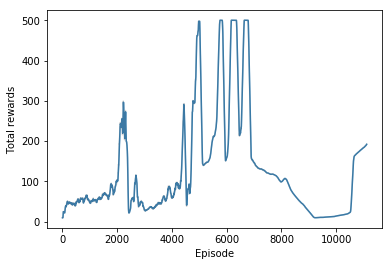

In [61]:
eps, arr = np.array(rewards_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('Total rewards')

Text(0,0.5,'G losses')

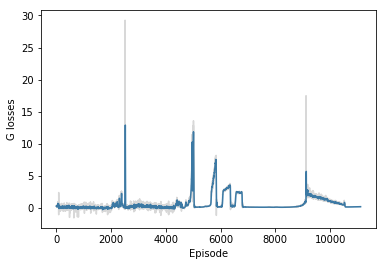

In [62]:
eps, arr = np.array(g_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('G losses')

Text(0,0.5,'D losses')

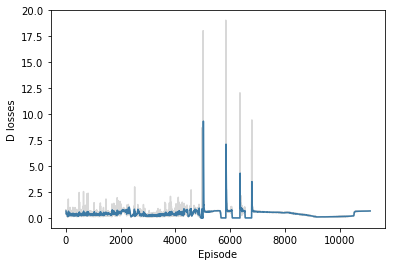

In [63]:
eps, arr = np.array(d_loss_list).T
smoothed_arr = running_mean(arr, 10)
plt.plot(eps[-len(smoothed_arr):], smoothed_arr)
plt.plot(eps, arr, color='grey', alpha=0.3)
plt.xlabel('Episode')
plt.ylabel('D losses')

## Testing

Let's checkout how our trained agent plays the game.

In [108]:
import gym
env = gym.make('CartPole-v0')
env = gym.make('CartPole-v1')
# env = gym.make('Acrobot-v1')
# env = gym.make('MountainCar-v0')
# env = gym.make('Pendulum-v0')
# env = gym.make('Blackjack-v0')
# env = gym.make('FrozenLake-v0')
# env = gym.make('AirRaid-ram-v0')
# env = gym.make('AirRaid-v0')
# env = gym.make('BipedalWalker-v2')
# env = gym.make('Copy-v0')
# env = gym.make('CarRacing-v0')
# env = gym.make('Ant-v2') #mujoco
# env = gym.make('FetchPickAndPlace-v1') # mujoco required!

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    #saver.restore(sess, 'checkpoints/model.ckpt')    
    saver.restore(sess, tf.train.latest_checkpoint('checkpoints'))
    
    # Episodes/epochs
    for _ in range(1):
    #while True:
        state = env.reset()
        total_reward = 0

        # Steps/batches
        #for _ in range(111111111111111111):
        while True:
            env.render()
            action_logits = sess.run(model.actions_logits, feed_dict={model.states: np.reshape(state, [1, -1])})
            action = np.argmax(action_logits)
            state, reward, done, _ = env.step(action)
            total_reward += reward
            if done:
                break
        # Print and break condition
        print('total_reward: {}'.format(total_reward))
        if total_reward == 500:
            break
                
# Closing the env
env.close()

/home/arasdar/anaconda3/envs/env/lib/python3.6/site-packages/gym/__init__.py:22: UserWarning: DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.
  warnings.warn('DEPRECATION WARNING: to improve load times, gym no longer automatically loads gym.spaces. Please run "import gym.spaces" to load gym.spaces on your own. This warning will turn into an error in a future version of gym.')


WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
WARN: gym.spaces.Box autodetected dtype as <class 'numpy.float32'>. Please provide explicit dtype.
INFO:tensorflow:Restoring parameters from checkpoints/model.ckpt
total_reward: 500.0


## Extending this

So, Cart-Pole is a pretty simple game. However, the same model can be used to train an agent to play something much more complicated like Pong or Space Invaders. Instead of a state like we're using here though, you'd want to use convolutional layers to get the state from the screen images.

![Deep Q-Learning Atari](assets/atari-network.png)

I'll leave it as a challenge for you to use deep Q-learning to train an agent to play Atari games. Here's the original paper which will get you started: http://www.davidqiu.com:8888/research/nature14236.pdf.